# Multi-Task Learning Notebook 

`I hope this is the last iteration`

We are going to import three datasets:
1. Children’s fairy tales (1000-100-100, ekman categorical)
2. Emobank (9000-300-300, vad regression)
3. SemEval-2018 (~7k - 1k - 3k, multi-label)

# Install & imports

In [1]:
!pip install transformers -q
!pip install wandb -qq
!pip install -Uqq ipdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 KB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 25.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.0 MB/s eta 0:00:00


In [2]:
import torch 
import torch.nn as nn
import transformers
import pdb
import wandb
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import ones_like, zeros_like

import os
import math
import copy
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm.notebook import tqdm

from transformers import AutoModel, BertTokenizerFast

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

# set manual seed 
np.random.seed(42)
torch.manual_seed(42)

cuda:0


## Give Access

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

wandb.login()

# this is for the shared project, but it doesn't seem to work:
# API KEY: 013ecd9857196cedaf8d4d8d9fc8653f60335ea0

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Import dataset from github

In [4]:
!git clone https://github.com/LeonY117/EmotionAnalysis.git -q

# Read and process data

### Fairy Tale dataset & Emobank

In [5]:
# load the cleaned up dataset from github
CLEAN_DATA_DIR = "/content/EmotionAnalysis/data/clean/"
CHILDREN_filename = "children_highAgree.csv"
EMOBANK_filename = "emobank.csv"

df_children = pd.read_csv(os.path.join(CLEAN_DATA_DIR, CHILDREN_filename))
df_emobank = pd.read_csv(os.path.join(CLEAN_DATA_DIR, EMOBANK_filename))

print(f'Children story dataset: {len(df_children)}')
print(f'Emobank dataset: {len(df_emobank)}')
print(df_children.head())
print(df_emobank.head())

Children story dataset: 1207
Emobank dataset: 9814
   Unnamed: 0                                           sentence  label
0           0  He looked around on every side and exclaimed, ...      4
1           1  Then he got up and clambered out of the cave, ...      3
2           2                    "Alas, thou canst not help me."      3
3           3  They leapt nimbly upstairs and downstairs, and...      2
4           4  Then she opened the door of the small house, a...      2
                    id  split     V     A     D  \
0  110CYL068_1036_1079  train  3.00  3.00  3.20   
1  110CYL068_1079_1110   test  2.80  3.10  2.80   
2  110CYL068_1127_1130  train  3.00  3.00  3.00   
3  110CYL068_1137_1188  train  3.44  3.00  3.22   
4  110CYL068_1189_1328  train  3.55  3.27  3.46   

                                                text  
0        Remember what she said in my last letter? "  
1                          If I wasn't working here.  
2                                            

### Sem-Eval Dataset

Which already has train-val-test split

In [6]:
sem_train_filename = "SemEval2018_train.csv"
sem_val_filename = "SemEval2018_val.csv"
sem_test_filename = "SemEval2018_test.csv"

df_sem_train = pd.read_csv(os.path.join(CLEAN_DATA_DIR, sem_train_filename))
df_sem_val = pd.read_csv(os.path.join(CLEAN_DATA_DIR, sem_val_filename))
df_sem_test = pd.read_csv(os.path.join(CLEAN_DATA_DIR, sem_test_filename))

df_sem_train.head()

text  anger  anticipation  \
0  “Worry is a down payment on a problem you may ...      0             1   
1  Whatever you decide to do make sure it makes y...      0             0   
2  @Max_Kellerman  it also helps that the majorit...      1             0   
3  Accept the challenges so that you can literall...      0             0   
4  My roommate: it's okay that we can't spell bec...      1             0   

   disgust  fear  joy  love  optimism  pessimism  sadness  surprise  trust  
0        0     0    0     0         1          0        0         0      1  
1        0     0    1     1         1          0        0         0      0  
2        1     0    1     0         1          0        0         0      0  
3        0     0    1     0         1          0        0         0      0  
4        1     0    0     0         0          0        0         0      0

## Define Global Variables

In [7]:
EKMAN_EMOTIONS = ['anger-disgust', 'fear', 'happy', 'sad', 'surprise']
SEM_EMOTIONS = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']
VAD_EMOTIONS = ['V', 'A', 'D']

# outputs heads (prediction heads)
NUM_CLASSES_EKMAN = len(EKMAN_EMOTIONS) # 5
NUM_CLASSES_SEM = len(SEM_EMOTIONS) # 11
NUM_CLASSES_VAD = len(VAD_EMOTIONS) # 3

OUT_DIMS = {
    'ekman': NUM_CLASSES_EKMAN, 'vad': NUM_CLASSES_VAD, 'sem': NUM_CLASSES_SEM
}

# label lengths (this is how many slots it takes to store the labels)
Y_DIM_EKMAN = 1
Y_DIM_VAD = NUM_CLASSES_VAD
Y_DIM_SEM = NUM_CLASSES_SEM

Y_DIMS = {
    'ekman': Y_DIM_EKMAN, 'vad': Y_DIM_VAD, 'sem': Y_DIM_SEM
}

## Load data from table to numpy array

In [8]:
# Load data into numpy
x_ekman_raw = list(df_children['sentence'])
y_ekman_raw = df_children['label'].to_numpy()

x_vad_raw = list(df_emobank['text'])
y_vad_raw = df_emobank[VAD_EMOTIONS].to_numpy()

x_sem_train_raw = list(df_sem_train['text'])
y_sem_train_raw = df_sem_train[SEM_EMOTIONS].to_numpy()

x_sem_val_raw = list(df_sem_val['text'])
y_sem_val_raw = df_sem_val[SEM_EMOTIONS].to_numpy()

x_sem_test_raw = list(df_sem_test['text'])
y_sem_test_raw = df_sem_test[SEM_EMOTIONS].to_numpy()

# Example:
print(x_ekman_raw[0])
print(y_ekman_raw[0])

print(x_vad_raw[0])
print(y_vad_raw[0])

print(x_sem_train_raw[0])
print(y_sem_train_raw[0])

He looked around on every side and exclaimed, "Oh, heavens, where am I?"
4
Remember what she said in my last letter? "
[3.  3.  3.2]
“Worry is a down payment on a problem you may never have'.  Joyce Meyer.  #motivation #leadership #worry
[0 1 0 0 0 0 1 0 0 0 1]


## Download Bert and tokenizer

In [ ]:
# Load the BERT tokenizer
pretrained_checkpoint = 'bert-base-uncased' 

tokenizer = BertTokenizerFast.from_pretrained(pretrained_checkpoint)

# import BERT-base pretrained model
bert = AutoModel.from_pretrained(pretrained_checkpoint)

In [ ]:
# Move bert to GPU
for param in bert.parameters():
  param.requires_grad = False
bert.to(DEVICE)
print(f'moved bert to {DEVICE}')

### Preprocess with Tokenizer

In [ ]:
tokenized_xs = {}

encoded_input = tokenizer(x_ekman_raw, padding=True, truncation=True, return_tensors="pt")
X_ekman_input = encoded_input['input_ids']
X_ekman_mask = encoded_input['attention_mask']
tokenized_xs['ekman'] = [X_ekman_input, X_ekman_mask]

encoded_input = tokenizer(x_vad_raw, padding=True, truncation=True, return_tensors="pt")
X_vad_input = encoded_input['input_ids']
X_vad_mask = encoded_input['attention_mask']
tokenized_xs['vad'] = [X_vad_input, X_vad_mask]

encoded_input = tokenizer(x_sem_train_raw, padding=True, truncation=True, return_tensors="pt")
X_input = encoded_input['input_ids']
X_mask = encoded_input['attention_mask']
tokenized_xs['sem_train'] = [X_input, X_mask]

encoded_input = tokenizer(x_sem_val_raw, padding=True, truncation=True, return_tensors="pt")
X_input = encoded_input['input_ids']
X_mask = encoded_input['attention_mask']
tokenized_xs['sem_val'] = [X_input, X_mask]

encoded_input = tokenizer(x_sem_test_raw, padding=True, truncation=True, return_tensors="pt")
X_input = encoded_input['input_ids']
X_mask = encoded_input['attention_mask']
tokenized_xs['sem_test'] = [X_input, X_mask]

### Preprocess with BERT

In [ ]:
BERT_OUT_SIZE = 768
preprocessed_xs = {}

for name, X in tokenized_xs.items():
  # allocate memory
  n = X[0].shape[0]
  preprocessed_xs[name] = torch.empty(size=(n, BERT_OUT_SIZE), dtype=torch.float)

  # use minibatch to process data
  b = 100
  num_batches = math.ceil(n // b)

  print(f'Preprocessing {name}...')
  for i in tqdm(range(num_batches)):
    x_ids = X[0][i*b: (i+1)*b].to(DEVICE)
    x_masks = X[1][i*b: (i+1)*b].to(DEVICE)

    output = bert(x_ids, attention_mask=x_masks)

    hidden_state = output['last_hidden_state']
    pooler_output = output['pooler_output']
    
    preprocessed_xs[name][i*b: (i+1)*b] = pooler_output

### Preprocess labels 
All labels need to be the same length, and we pad with 0s

In [ ]:
preprocessed_ys = {}

# create placeholder tensors
ekman_zeros = torch.zeros((1, Y_DIMS['ekman']), )
vad_zeros = torch.zeros((1, Y_DIMS['vad']), )
sem_zeros = torch.zeros((1, Y_DIMS['sem']), )

# EKMAN
y = torch.tensor(y_ekman_raw, dtype=torch.float).unsqueeze(-1)
n = y.shape[0]
y = torch.concatenate((y, vad_zeros.repeat(n, 1), sem_zeros.repeat(n, 1)), dim=-1)
preprocessed_ys['ekman'] = y

# VAD
y = torch.tensor(y_vad_raw, dtype=torch.float)
n = y.shape[0]
y = torch.concatenate((ekman_zeros.repeat(n, 1), y, sem_zeros.repeat(n, 1)), dim=-1)

# normalize vad
# y = F.normalize(y, dim=-1)
y = y/y.max()
preprocessed_ys['vad'] = y

# sem
y = torch.tensor(y_sem_train_raw, dtype=torch.float)
n = y.shape[0]
y = torch.concatenate((ekman_zeros.repeat(n, 1), vad_zeros.repeat(n, 1), y), dim=-1)
preprocessed_ys['sem_train'] = y

y = torch.tensor(y_sem_val_raw, dtype=torch.float)
n = y.shape[0]
y = torch.concatenate((ekman_zeros.repeat(n, 1), vad_zeros.repeat(n, 1), y), dim=-1)
preprocessed_ys['sem_val'] = y

y = torch.tensor(y_sem_test_raw, dtype=torch.float)
n = y.shape[0]
y = torch.concatenate((ekman_zeros.repeat(n, 1), vad_zeros.repeat(n, 1), y), dim=-1)
preprocessed_ys['sem_test'] = y

In [ ]:
# check that everything is alright so far:

for key in preprocessed_ys.keys():
  x = preprocessed_xs[key]
  y = preprocessed_ys[key]

  print(f'{key}: X: {x.shape}, y: {y.shape}')
  # print(f'Example: {x[0]}')
  print(f'label: {y[0]}')
  print('--------------------------------')

  # 
# check that everything is alright so far:

for key in preprocessed_ys.keys():
  x = preprocessed_xs[key]
  y = preprocessed_ys[key]

  print(f'{key}: X: {x.shape}, y: {y.shape}')
  # print(f'Example: {x[0]}')
  print(f'label: {y[0]}')
  print('--------------------------------')

  
# ekman: X: torch.Size([1207, 768]), y: torch.Size([1207, 15])
# label: tensor([4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
# --------------------------------
# vad: X: torch.Size([9814, 768]), y: torch.Size([9814, 15])
# label: tensor([0.0000, 0.6522, 0.6522, 0.6957, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
#         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
# --------------------------------
# sem_train: X: torch.Size([6838, 768]), y: torch.Size([6838, 15])
# label: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.])
# --------------------------------
# sem_val: X: torch.Size([886, 768]), y: torch.Size([886, 15])
# label: tensor([0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
# --------------------------------
# sem_test: X: torch.Size([3259, 768]), y: torch.Size([3259, 15])
# label: tensor([0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.])

# Train-val-test split

* split ekman dataset into 8-1-1
* split vad dataset into around 8-1-1

In [64]:
def train_val_test_split(X, y, train_ratio, val_ratio, test_ratio):
  '''
  splits the dataset into train, val, test sets
  '''
  torch.manual_seed(0) # !important

  n = X.shape[0]

  perm = torch.randperm(n)

  train_ratio = train_ratio / (train_ratio+val_ratio+test_ratio)
  val_ratio = val_ratio / (train_ratio+val_ratio+test_ratio)
  test_ratio = test_ratio / (train_ratio+val_ratio+test_ratio)

  tr_n = int(train_ratio * n)
  val_n = int(val_ratio * n)
  test_n = int(test_ratio * n)

  X_train, y_train = X[perm[:tr_n]], y[perm[:tr_n]]
  X_val, y_val = X[perm[tr_n:tr_n+val_n]], y[perm[tr_n:tr_n+val_n]]
  X_test, y_test = X[perm[val_n:val_n+test_n]], y[perm[val_n:val_n+test_n]]

  return X_train, y_train, X_val, y_val, X_test, y_test

## Split data and attach task labels

In [70]:
split_datasets = {'ekman': {}, 'vad': {}, 'sem': {}, 'ekman-sem': {}, 'ekman-vad': {}, 'vad-sem': {}, 'combined': {}}

# EKMAN
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(preprocessed_xs['ekman'], preprocessed_ys['ekman'], 8, 1, 1)

# attach task labels
task_train = torch.tensor([1, 0, 0]).unsqueeze(0).repeat((len(X_train), 1))
task_val = torch.tensor([1, 0, 0]).unsqueeze(0).repeat((len(X_val), 1))
task_test = torch.tensor([1, 0, 0]).unsqueeze(0).repeat((len(X_test), 1))

split_datasets['ekman']['train'] = [X_train, y_train, task_train]
split_datasets['ekman']['val'] = [X_val, y_val, task_val]
split_datasets['ekman']['test'] = [X_test, y_test, task_test]

# VAD
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(preprocessed_xs['vad'], preprocessed_ys['vad'], 8, 1, 1)

# attach task labels
task_train = torch.tensor([0, 1, 0]).unsqueeze(0).repeat((len(X_train), 1))
task_val = torch.tensor([0, 1, 0]).unsqueeze(0).repeat((len(X_val), 1))
task_test = torch.tensor([0, 1, 0]).unsqueeze(0).repeat((len(X_test), 1))

split_datasets['vad']['train'] = [X_train, y_train, task_train]
split_datasets['vad']['val'] = [X_val, y_val, task_val]
split_datasets['vad']['test'] = [X_test, y_test, task_test]

# SEM (already split)
task_train = torch.tensor([0, 0, 1]).unsqueeze(0).repeat((len(preprocessed_xs['sem_train']), 1))
task_val = torch.tensor([0, 0, 1]).unsqueeze(0).repeat((len(preprocessed_xs['sem_val']), 1))
task_test = torch.tensor([0, 0, 1]).unsqueeze(0).repeat((len(preprocessed_xs['sem_test']), 1))

split_datasets['sem']['train'] = [preprocessed_xs['sem_train'], preprocessed_ys['sem_train'], task_train]
split_datasets['sem']['val'] = [preprocessed_xs['sem_val'], preprocessed_ys['sem_val'], task_val]
split_datasets['sem']['test'] = [preprocessed_xs['sem_test'], preprocessed_ys['sem_test'], task_test]

In [71]:
# IMPORTANT: CHECK THAT SEED IS WORKING
print(split_datasets['ekman']['train'][1][0])
print(split_datasets['ekman']['train'][1][1])
print(split_datasets['vad']['train'][1][0])
print(split_datasets['vad']['train'][1][1])
print(split_datasets['sem']['train'][1][0])
print(split_datasets['sem']['train'][1][1])

# tensor([4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
# tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
# tensor([0.0000, 0.5870, 0.6304, 0.5652, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
#         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
# tensor([0.0000, 0.6522, 0.6087, 0.6304, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
#         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
# tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.])
# tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.])

tensor([4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0.0000, 0.5870, 0.6304, 0.5652, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
tensor([0.0000, 0.6522, 0.6087, 0.6304, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.])


## Create combined data

In [19]:
for split in ['train', 'val', 'test']:
  X1 = split_datasets['ekman'][split][0]
  X2 = split_datasets['vad'][split][0]
  X3 = split_datasets['sem'][split][0]

  y1 = split_datasets['ekman'][split][1]
  y2 = split_datasets['vad'][split][1]
  y3 = split_datasets['sem'][split][1]

  t1 = split_datasets['ekman'][split][2]
  t2 = split_datasets['vad'][split][2]
  t3 = split_datasets['sem'][split][2]
  
  # sem_ekman
  x = torch.concatenate((X1, X3), dim=0)
  y = torch.concatenate((y1, y3), dim=0)
  t = torch.concatenate((t1, t3), dim=0)
  split_datasets['ekman-sem'][split] = [x, y, t]

  # ekman_vad
  x = torch.concatenate((X1, X2), dim=0)
  y = torch.concatenate((y1, y2), dim=0)
  t = torch.concatenate((t1, t2), dim=0)
  split_datasets['ekman-vad'][split] = [x, y, t]

  # ekman_sem
  x = torch.concatenate((X1, X3), dim=0)
  y = torch.concatenate((y1, y3), dim=0)
  t = torch.concatenate((t1, t3), dim=0)
  split_datasets['vad-sem'][split] = [x, y, t]

  # combined
  x = torch.concatenate((X1, X2, X3), dim=0)
  y = torch.concatenate((y1, y2, y3), dim=0)
  t = torch.concatenate((t1, t2, t3), dim=0)
  split_datasets['combined'][split] = [x, y, t]


## Put everything into dataset objects

Also moving to GPU

In [20]:
class Emotion_dataset(Dataset):
  def __init__(self, X, y, task, transform=None):
    self.X = X
    self.y = y 
    self.task = task 

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, idx):
    sample = (self.X[idx], self.y[idx], self.task[idx])
    return sample


In [21]:
datasets = {}

for key, splits in split_datasets.items():
  datasets[key] = {}
  for split, data in splits.items():
    # move everything to gpu
    data[0] = data[0].to(DEVICE)
    data[1] = data[1].to(DEVICE)
    data[2] = data[2].to(DEVICE)
    # create dataset
    datasets[key][split] = Emotion_dataset(data[0], data[1], data[2])

## Dataloaders

In [22]:
dataloaders = {}

for key, splits in datasets.items():
  dataloaders[key] = {}
  for split, data in splits.items():
    dataloaders[key][split] = DataLoader(data, batch_size = 64, shuffle=True)

# Training Architecture

Define some key classes for training
* model
* loss metric
* accuracy metric
* grad norm

## Model Definition

In [23]:
class MultiheadNetwork(nn.Module):
  def __init__(self, h_size=256, dropout=0):
    super().__init__()
    
    self.shared_base = nn.Linear(768, h_size)
    self.ekman_predictor = nn.Linear(h_size, OUT_DIMS['ekman'])
    self.vad_predictor = nn.Linear(h_size, OUT_DIMS['vad'])
    self.sem_predictor = nn.Linear(h_size, OUT_DIMS['sem'])

    self.dropout = nn.Dropout(p=dropout, inplace=False)
    self.relu = nn.ReLU()
    # self.softmax = nn.Softmax(dim=1)
    self.sigmoid = nn.Sigmoid()
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, X, task):  
    
    X = self.relu(self.shared_base(X))
    X = self.dropout(X)

    ekman_filter = task[:, 0].unsqueeze(-1)
    y_ekman = ekman_filter * self.ekman_predictor(X)
    y_ekman = self.softmax(y_ekman)

    vad_filter = task[:, 1].unsqueeze(-1)
    y_vad = vad_filter * self.vad_predictor(X)
    y_vad = self.relu(y_vad)

    sem_filter = task[:, 2].unsqueeze(-1)
    y_sem = sem_filter * self.sem_predictor(X)
    y_sem = self.sigmoid(y_sem)

    y = torch.concat((y_ekman, y_vad, y_sem), dim=1)

    return y

## Loss Function

In [24]:
class MultiTaskLoss(object):
  def __init__(self):
    self.ekman_criterion = nn.CrossEntropyLoss(reduction='none')
    self.vad_criterion = nn.MSELoss(reduction='none')
    self.sem_criterion = nn.BCELoss(reduction='none')
  
  def __call__(self, y_pred, y_gt, task) -> torch.tensor:
    '''
    Returns as loss vector with one loss for each task, normalized to number of samples
    '''
    ekman_count = task[:, 0].sum() + 1e-8
    vad_count = task[:, 1].sum() + 1e-8
    sem_count = task[:, 2].sum() + 1e-8

    losses = torch.zeros(3, dtype=torch.float, device=y_pred.device)

    # ekman loss (categorical)
    s1, f1 = 0, OUT_DIMS['ekman']
    s2, f2 = 0, Y_DIMS['ekman']
    ekman_mask = task[:, 0]
    ekman_loss_unfiltered = self.ekman_criterion(y_pred[:, s1:f1], y_gt[:, s2:f2].squeeze(dim=1).to(int))
    ekman_loss = ekman_loss_unfiltered * ekman_mask
    losses[0] = ekman_loss.sum() / ekman_count

    # vad loss (MSE)
    s1, f1 = s1+OUT_DIMS['ekman'], f1+OUT_DIMS['vad']
    s2, f2 = s2+Y_DIMS['ekman'], f2+Y_DIMS['vad']
    vad_mask = task[:, 1]
    vad_loss_unfiltered = self.vad_criterion(y_pred[:, s1:f1], y_gt[:, s2:f2]).sum(dim=-1)
    vad_loss = vad_loss_unfiltered *vad_mask
    losses[1] = torch.sqrt(vad_loss.sum() / vad_count)
    
    # sem loss (binary CE)
    s1, f1 = s1+OUT_DIMS['vad'], f1+OUT_DIMS['sem']
    s2, f2 = s2+Y_DIMS['vad'], f2+Y_DIMS['sem']
    sem_mask = task[:, 2]
    # print(y_pred[:, s1:f1])
    # print(y_pred[:, s1:f1].max())
    sem_loss_unfiltered = self.sem_criterion(y_pred[:, s1:f1], y_gt[:, s2:f2]).sum(dim=-1)
    
    sem_loss = sem_loss_unfiltered *sem_mask
    losses[2] = sem_loss.sum() / sem_count

    return losses

## Metric 

In [25]:
def compute_F1(y_pred, y_gt, mask, detailed=False):
  '''
  Args
  -----
  y_pred: (n x 5)
  y_gt: (n x 1)
  mask: (n x 1)
  detailed: if True, return F1 for every class

  Returns
  -----
  Jaccard_accuracy: float
  '''
  gt_class = y_gt.to(int).squeeze(dim=1)
  pred_class = torch.argmax(y_pred, dim=-1).to(int)
  mask = mask.squeeze(dim=1).to(int)
  
  # print(torch.where(gt_class==c and pred_class==1, ones_like(gt_class), zeros_like(gt_class)))

  F1s = []
  TPs, FPs, FNs = 0, 0, 0
  for c in range(NUM_CLASSES_EKMAN):
    TP = ((gt_class==c)&(pred_class==c)&(mask==1)).sum()
    FP = ((pred_class==c)&(gt_class!=c)&(mask==1)).sum()
    FN = ((pred_class!=c)&(gt_class==c)&(mask==1)).sum()
    if detailed:
      F1s.append(TP/ (TP + 0.5 * (FP + FN) + 1e-8))
    TPs += TP
    FPs += FP
    FNs += FN
  
  # print(f'TP: {TPs}, FP: {FPs}, FN: {FNs}')
  F1 = TPs/ (TPs + 0.5 * (FPs + FNs) + 1e-8)

  if detailed: 
    output = (F1, F1s)
  else:
    output = F1
  return output

def compute_Jaccard(y_pred, y_gt, mask):
  '''
  Args
  -----
  y_pred: (n x 11)
  y_gt: (n x 11)
  mask: (n x 1)

  Returns
  -----
  Jaccard_accuracy: float
  '''

  # print(((y_pred==1)&(y_gt==1)).shape)
  # print(((y_pred==1)&(y_gt==1)).sum(axis=-1).shape)

  # mask = mask.squeeze()

  n = mask.sum() + 1e-8
  y_pred = y_pred > 0.5

  # print(((y_pred==1)&(y_gt==1)))
  # print(((y_pred==1)&(y_gt==1)).shape)
  # print((((y_pred==1)&(y_gt==1))*mask).shape)
  # print(union)

  intersect = ((y_pred==1)&(y_gt==1))*mask
  union = (((y_pred==1)|(y_gt==1)))*mask
  jaccards = intersect.sum(dim=-1) / (union.sum(dim=-1)+1e-8)
  jaccard = 1/n * jaccards.sum()
  # jaccard = 1/n * intersect.sum() / (union.sum() + 1e-8)

  return jaccard

  
def compute_MSE(y_pred, y_gt, mask):
  '''
  Args
  -----
  y_pred: (n x 3)
  y_gt: (n x 3)
  mask: (n x 1)

  Returns
  -----
  Jaccard_accuracy: float
  '''
  loss = nn.MSELoss(reduction='none')
  MSE = loss(y_pred, y_gt) * mask

  MSE = MSE.sum() / (mask.sum()+1e-8)

  return MSE


class MultiTaskMetric(object):
  def __init__(self):
    pass

  def __call__(self, y_pred, y_gt, task):
    ekman_count = task[:, 0].sum() + 1e-8
    vad_count = task[:, 1].sum() + 1e-8
    sem_count = task[:, 2].sum() + 1e-8

    metric = torch.zeros(3, dtype=torch.float, device=y_pred.device)

    # F1
    s1, f1 = 0, OUT_DIMS['ekman']
    s2, f2 = 0, Y_DIMS['ekman']
    pred = y_pred[:, s1:f1]
    gt = y_gt[:, s2:f2]
    mask = task[:, 0:1]
    F1 = compute_F1(pred, gt, mask)

    # Regression
    s1, f1 = s1+OUT_DIMS['ekman'], f1+OUT_DIMS['vad']
    s2, f2 = s2+Y_DIMS['ekman'], f2+Y_DIMS['vad']
    pred = y_pred[:, s1:f1]
    gt = y_gt[:, s2:f2]
    mask = task[:, 1:2]
    MSE = compute_MSE(pred, gt, mask)
    
    # Jaccard
    s1, f1 = s1+OUT_DIMS['vad'], f1+OUT_DIMS['sem']
    s2, f2 = s2+Y_DIMS['vad'], f2+Y_DIMS['sem']
    pred = y_pred[:, s1:f1]
    gt = y_gt[:, s2:f2]
    mask = task[:, 2:]
    Jaccard = compute_Jaccard(pred, gt, mask)

    return F1, MSE, Jaccard



In [26]:
# Test metric & loss function
net = MultiheadNetwork()
net.to(DEVICE)
criterion = MultiTaskLoss()
metric = MultiTaskMetric()

with torch.no_grad():
  x, y, task = next(iter(dataloaders['combined']['train']))

  y_pred = net(x, task)

  loss = criterion(y_pred, y, task)

  f1, mse, jaccard = metric(y_pred, y, task)

print(loss)
print(f1)
print(mse)
print(jaccard)

tensor([1.5751, 0.9905, 7.6260], device='cuda:0')
tensor(0.4286, device='cuda:0')
tensor(0.9810, device='cuda:0')
tensor(0.1517, device='cuda:0')


## GradNorm

In [27]:
class GradNorm():
  def __init__(self, initial_loss, layers, alpha=1.0, weights=None):
    # the last share layer
    self.layers = layers
    # hyperparameter
    self.alpha = alpha
    if not weights:
      # init weights
      self.weights = torch.nn.Parameter(torch.ones_like(initial_loss))
    else:
      # take some custom initial weights
      self.weights = weights

    # set optimizer for weights
    self.optimizer_GradNorm = torch.optim.Adam([self.weights])

    # set L(0)
    self.l0 = initial_loss.clone().detach()

    self.updated_l0 = True

  def get_weights(self):
    return self.weights.clone().detach()
  
  def get_loss_ratios(self):
    return self.loss_ratio

  def update_L0(self, L0):
    self.l0 = L0.clone().detach()
    self.updated_l0 = True

  def update_weights(self, losses):
    # compute the L2 norm of the gradients for each task
    gw = []
    for i in range(len(losses)):
      dl = torch.autograd.grad(self.weights[i]*losses[i], self.layers.parameters(), retain_graph=True, create_graph=True)[0]
      # take norm of the gradient as proxy for how much it's updating
      gw.append(torch.norm(dl))
      
    gw = torch.stack(gw)
    # compute the average gradient norm
    gw_avg = gw.mean().detach()

    # compute loss ratio per task
    self.loss_ratio = losses.detach() / self.l0
    # compute the relative inverse training rate per task
    rt = self.loss_ratio / self.loss_ratio.mean()

    # compute the GradNorm loss
    constant = (gw_avg * rt ** self.alpha).detach()
    gradnorm_loss = torch.abs(gw - constant).sum()

    # clear gradients of weights
    self.optimizer_GradNorm.zero_grad()
    
    weights_grad = torch.autograd.grad(gradnorm_loss, self.weights)
    self.weights._grad = weights_grad[0]
    # update loss weights
    self.optimizer_GradNorm.step()

    with torch.no_grad():
      normalizer = len(self.weights) / self.weights.sum()
      self.weights *= normalizer
    

# Training Manager

In [28]:
torch.cuda.empty_cache()

In [44]:
class TrainingManager():
  def __init__(self, dataloader, config, net=None, wandb=False):
    self.alpha = config['alpha']
    self.with_gradNorm = config['gradNorm']
    self.train_label = config['dataset']
    self.val_label = config['val_dataset']
    self.weight_decay = config['weight_decay']
    self.wandb = wandb
    self.lr = config['lr']

    if not net:
      self.net = MultiheadNetwork(h_size=config['h_size'], dropout=config['dropout'])
      self.net.to(DEVICE)
    else:
      self.net = net
    
    self.dataloader = dataloader

    # self.criterion = nn.MSELoss()
    self.criterion = MultiTaskLoss()
    self.metric = MultiTaskMetric()

    self.optimizer = torch.optim.Adam(self.net.parameters(), weight_decay=self.weight_decay, lr=self.lr)

    self.GN = None

    self.best_net = None
    self.best_loss = 0

    self.curr_epoch = 0
    self.history = {
        'ekman_loss/train': [],
        'ekman_loss/val': [],
        'vad_loss/train': [],
        'vad_loss/val': [],
        'sem_loss/train': [],
        'sem_loss/val': [],
        'avg_loss/train': [],
        'avg_loss/val': [],
        'val_f1': [],
        'val_jaccard': [],
        'weights/ekman': [],
        'weights/vad': [],
        'weights/sem': [],
    }


  def train(self, epochs, train_label=None, val_label=None, log=True):
    torch.cuda.empty_cache() # helps clearing RAM
    self.net.train()
    # default to internal labels unless specified otherwise
    if train_label == None: 
      train_label = self.train_label
    if val_label == None:
      val_label = self.val_label

    for e in range(epochs):
      total_loss_ekman = 0
      total_loss_vad = 0
      total_loss_sem = 0
      total_loss_avg = 0
      total_loss_weights = torch.zeros(3,)

      for X, y, task in tqdm(self.dataloader[train_label]['train']):
        self.optimizer.zero_grad()

        y_pred = self.net(X, task)

        losses = self.criterion(y_pred, y, task)

        # GradNorm initialization (only on first step)
        if self.with_gradNorm:
          if self.GN == None:
            self.GN = GradNorm(losses, self.net.shared_base, self.alpha)

          # update L0 on first epoch
          if self.curr_epoch == 1 and not self.GN.updated_l0:
            self.GN.update_L0(L0_temp)
          # retreive weights first
          weights = self.GN.weights.clone().detach()
          # update weights
          self.GN.update_weights(losses)
          # see loss_ratio for logging
          loss_ratio = self.GN.get_loss_ratios()

          # log 
          total_loss_weights += weights.detach().cpu().clone()

        else:
          weights = torch.ones_like(losses)

        # compute the weighted loss
        # TODO: check weights shape
        weighted_loss = weights @ losses

        # clear gradients of network
        self.optimizer.zero_grad()

        # retain graph because we still need to update weights
        weighted_loss.backward()

        # storing minibatch results
        # total_loss_ekman += (weights[0]*losses[0]).cpu().item()
        # total_loss_vad += (weights[1]*losses[1]).cpu().item()
        # total_loss_avg += torch.norm(weighted_loss).cpu().item()

        total_loss_ekman += (losses[0]*(task[:, 0].sum())).cpu().item()
        total_loss_vad += (losses[1]*(task[:, 1].sum())).cpu().item()
        total_loss_sem += (losses[2]*(task[:, 2].sum())).cpu().item()
        # total_loss_avg += total_loss_ekman + total_loss_vad + total_loss_sem

        # update model weights
        self.optimizer.step()

      # storing epoch results
      val_losses, val_f1, val_mse, val_jaccard = self._evaluate(self.dataloader[val_label]['val'])
      
      if val_losses.sum() < self.best_loss:
        print('updating best net')
        self.best_net = copy.deepcopy(self.net)
        self.best_loss = val_losses.sum()

      log_loss_weights = (total_loss_weights / len(self.dataloader[train_label]['train'])).tolist()
      
      total_loss_ekman /= len(self.dataloader['ekman']['train'].dataset)
      total_loss_vad /= len(self.dataloader['vad']['train'].dataset)
      total_loss_sem /= len(self.dataloader['sem']['train'].dataset)
      total_loss_avg = total_loss_ekman + total_loss_vad + total_loss_sem

      if self.with_gradNorm and not self.GN.updated_l0:
        print('recomputing L0...')
        losses, _, _, _ = self._evaluate(self.dataloader[train_label]['train'])
        L0_temp = torch.tensor([losses[0], losses[1], losses[2]], device=y.device)
      
      self.curr_epoch += 1
      self.history['ekman_loss/train'].append(total_loss_ekman)
      self.history['vad_loss/train'].append(total_loss_vad)
      self.history['sem_loss/train'].append(total_loss_sem)
      self.history['avg_loss/train'].append(total_loss_avg)
      self.history['ekman_loss/val'].append(val_losses[0].cpu().item())
      self.history['vad_loss/val'].append(val_losses[1].cpu().item())
      self.history['sem_loss/val'].append(val_losses[2].cpu().item())
      self.history['avg_loss/val'].append(val_losses.sum().cpu().item())
      self.history['val_f1'].append(val_f1.item())
      self.history['val_jaccard'].append(val_jaccard.item())
      self.history['weights/ekman'].append(log_loss_weights[0])
      self.history['weights/vad'].append(log_loss_weights[1])
      self.history['weights/sem'].append(log_loss_weights[2])

      if self.wandb:
        to_log = {name: arr[-1] for name, arr in self.history.items()}
        to_log['epoch'] = self.curr_epoch
        wandb.log(to_log)

      # print(f'Epoch {e+1}: train_avg_loss = {total_loss_avg:.3f}')
      print(f'Epoch {e+1}: train ekman_loss = {total_loss_ekman:.3f}, vad loss = {total_loss_vad:.3f}, sem loss = {total_loss_sem:.3f}')
      # print(f'Epoch {e+1}: val_avg_loss = {val_loss_avg:.3f}')
      print(f'Epoch {e+1}: val ekman loss = {val_losses[0]:.3f}, vad loss = {val_losses[1]:.3f}, sem loss = {val_losses[2]:.3f}')
      print(f'Epoch {e+1}: f1 = {val_f1:.3f}, jaccard = {val_jaccard:.3f}')
      if self.with_gradNorm:
        print(f'Epoch {e+1}: avg. loss_weights = {log_loss_weights}, {self.GN.l0}')
        # print(f'Epoch {e+1}: avg. loss_ratios (inv. train rate) = {log_loss_ratios}')
  
  def _evaluate(self, dataloader=None, net=None):
    if not net: 
      net = self.net
    net.eval()
    if dataloader == None:
      dataloader = self.dataloader['ekman']['test']
    with torch.no_grad():
      total_loss = 0
      total_loss_ekman = 0
      total_loss_vad = 0
      ekman_top1_correct = 0
      total_ekman = 0 
      total_vad = 0 
      # metric needs everything to be computed in one go
      n = len(dataloader.dataset)
      y_preds = torch.empty(n, sum(OUT_DIMS.values()), dtype=torch.float) # n x 19
      y_gts = torch.empty(n, sum(Y_DIMS.values()), dtype=torch.float) # n x 15
      tasks = torch.empty(n, 3) # 3
      i = 0
      for X, y, task in dataloader:
        b = X.shape[0]
        y_pred = net(X, task)
        y_preds[i:i+b] = y_pred
        y_gts[i:i+b] = y
        tasks[i:i+b] = task
        i += b
  
      losses = self.criterion(y_preds, y_gts, tasks)

      f1, mse, jaccard = self.metric(y_preds, y_gts, tasks)

      return losses, f1, mse, jaccard

  def evaluate(self, label='combined'):
    losses, f1, mse, jaccard = self._evaluate(self.dataloader[label]['test'])

    print(f'TEST SET ({label})')
    print(f'Total Loss = {losses.sum():.3f}')
    print(f'Ekman Loss = {losses[0]:.3f}')
    print(f'VAD Loss = {losses[1]:.3f}')
    print(f'sem Loss = {losses[2]:.3f}')
    print(f'F1 = {f1:.4f}')
    print(f'MSE = {mse:.4f}')
    print(f'Jaccard = {jaccard:.4f}')
    
    if self.best_net != None:
      losses, f1, mse, jaccard = self._evaluate(self.dataloader[label]['test'], net=self.best_net)
      print(f'-----------------------')
      print(f'EVALUATING WITH BEST NET')
      print(f'TEST SET ({label})')
      print(f'Total Loss = {losses.sum():.3f}')
      print(f'Ekman Loss = {losses[0]:.3f}')
      print(f'VAD Loss = {losses[1]:.3f}')
      print(f'sem Loss = {losses[2]:.3f}')
      print(f'F1 = {f1:.4f}')
      print(f'MSE = {mse:.4f}')
      print(f'Jaccard = {jaccard:.4f}')


  def save_checkpoint(self):
    pass

  def plot_history(self):
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 3, 1)
    plt.title('Ekman Loss')
    plt.plot(self.history['ekman_loss/train'], label='train')
    plt.plot(self.history['ekman_loss/val'], label='val')
    plt.legend()

    plt.subplot(2, 3, 2)
    plt.title('VAD Loss')
    plt.plot(self.history['vad_loss/train'], label='train')
    plt.plot(self.history['vad_loss/val'], label='val')
    plt.legend()

    plt.subplot(2, 3, 3)
    plt.title('sem Loss')
    plt.plot(self.history['sem_loss/train'], label='train')
    plt.plot(self.history['sem_loss/val'], label='val')
    plt.legend()

    plt.subplot(2, 3, 4)
    plt.title('Weight')
    plt.plot(self.history['weights/ekman'], label='ekman')
    plt.plot(self.history['weights/vad'], label='vad')
    plt.plot(self.history['weights/sem'], label='sem')
    plt.legend()

    plt.subplot(2, 3, 5)
    plt.title('F1')
    plt.plot(self.history['val_f1'], label='val')
    plt.legend()

    plt.subplot(2, 3, 6)
    plt.title('Jaccard')
    plt.plot(self.history['val_jaccard'], label='val')
    plt.legend()

    plt.show()

  def save_model(self, folder, filename, save_weights=True, save_logs=True):
    print('saving experiment...')
    filename += f'_{self.curr_epoch}e'
    if save_weights:
      torch.save(self.net.state_dict(), os.path.join(folder, filename+'.pt'))
  
    if save_logs:
      df_log = pd.DataFrame.from_dict(self.history)
      df_log.to_csv(os.path.join(folder, filename+'_logs.csv'))

      ekman_loss, vad_loss, loss, acc = self._evaluate(self.dataloader['combined']['test'])

      with open(os.path.join(folder, filename+'.txt'), 'w+') as f:
        f.write(f'{ekman_loss}, {vad_loss}, {loss}, {acc}')
      
    print(f'All files saved with experiment name = {filename} to folder {folder}')


In [30]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#00bb88', '#0033ff', '#aa3399', '#ff6600']) 

# Result Summary 

In [31]:
from scipy.interpolate import make_interp_spline

def plot_summary(history, save_to=None):
    for key, value in history.items():
      history[key] = np.array(value)
      
    x = np.arange(history['ekman_loss/train'].shape[1]) + 1
    x_dense = np.linspace(x.min(), x.max(), 100)

    plt.figure(figsize=(20, 10))

    plots = [
        {
          'title': 'Weights',
          'lines': {
              'Ekman': history['weights/ekman'],
              'Vad': history['weights/vad'],
              'Sem': history['weights/sem']
            }
        },
        {
          'title': 'Ekman Loss',
          'lines': {
              'train': history['ekman_loss/train'],
              'val': history['ekman_loss/val']
            }
        },
        {
          'title': 'VAD Loss',
          'lines': {
              'train': history['vad_loss/train'],
              'val': history['vad_loss/val']
            }
        },
        {
          'title': 'SEM Loss',
          'lines': {
              'train': history['sem_loss/train'],
              'val': history['sem_loss/val']
            }
        },
        {
          'title': 'Ekman F1',
          'lines': {
              'val': history['val_f1'],
            }
        },
        {
          'title': 'SEM Jaccard',
          'lines': {
              'val': history['val_jaccard'],
            }
        },
    ]

    colors = ['#00bb88', '#0033ff', '#aa3399', '#ff6600']
    for (i, plot) in enumerate(plots):
        plt.subplot(2, 3, i+1)
        plt.title(plot['title'])
        for j, (label, lines) in enumerate(plot['lines'].items()):
          mean =  lines.mean(axis=0).squeeze()
          std = lines.std(axis=0).squeeze()

          mean = make_interp_spline(x, mean)(x_dense)
          std = make_interp_spline(x, std)(x_dense)

          plt.plot(x_dense, mean, color=colors[j], label=label)
          plt.fill_between(x_dense, mean+std, mean-std, color=colors[j], alpha=0.3)
        plt.legend()
    plt.show()

    if save_to != None:
      plt.savefig(save_to, dpi=300)

In [32]:
import json

class Results_Summary():
  def __init__(self):
    self.history = {
        'ekman_loss/train': [],
        'ekman_loss/val': [],
        'vad_loss/train': [],
        'vad_loss/val': [],
        'sem_loss/train': [],
        'sem_loss/val': [],
        'avg_loss/train': [],
        'avg_loss/val': [],
        'val_f1': [],
        'val_jaccard': [],
        'weights/ekman': [],
        'weights/vad': [],
        'weights/sem': [],
    }

    self.test_results = {
        'ekman_loss': [], 
        'vad_loss': [],
        'sem_loss': [],
        'loss': [],
        'f1': [],
        'jaccard': [],
    }
  
  def add_history(self, history):
    for key, value in history.items():
      self.history[key].append(value)
  
  def add_test_results(self, test_results):
    for key, value in test_results.items():
      self.test_results[key].append(value)

  def plot(self, save_to=None):
    plot_summary(self.history, save_to)
  
  def save(self, folder, filename):
    json.dump(self.history, open(os.path.join(folder, filename+'.json'), 'w'))

  def summary(self):
    z = 1.96
    ekman_loss = np.array(self.test_results['ekman_loss'])
    n = len(ekman_loss)
    CI = z * ekman_loss.std() / (n**0.5)
    print(f'Ekman Loss: {ekman_loss.mean():.3f} +- {CI:.3f}')

    vad_loss = np.array(self.test_results['vad_loss'])
    CI = z * vad_loss.std() / (n**0.5)
    print(f'VAD Loss: {vad_loss.mean():.3f} +- {CI:.3f}')

    sem_loss = np.array(self.test_results['sem_loss'])
    CI = z * sem_loss.std() / (n**0.5)
    print(f'sem Loss: {sem_loss.mean():.3f} +- {CI:.3f}')

    loss = np.array(self.test_results['loss'])
    CI = z * loss.std() / (n**0.5)
    print(f'Avg Loss: {loss.mean():.3f} +- {CI:.3f}')

    ekman_acc = np.array(self.test_results['f1'])
    CI = z * ekman_acc.std() / (n**0.5)
    print(f'Avg F1: {ekman_acc.mean():.3f} +- {CI:.3f}')

    jaccard = np.array(self.test_results['jaccard'])
    CI = z * jaccard.std() / (n**0.5)
    print(f'Avg Jaccard: {jaccard.mean():.3f} +- {CI:.3f}')


# Experiments

In [48]:
def close_wandb():
  wandb.init(project='', mode='offline')
  wandb.finish()

wandb: ERROR Control-C detected -- Run data was not synced


## Finalized Experiment Section

Use the following hyperparameters
```
config = {
    "dataset": "combined",
    "val_dataset": "combined",
    "gradNorm": False,
    "alpha": 1.0,
    "dropout": 0.5,
    'h_size': 256,
    'weight_decay': 1e-5,
    'lr': 5e-4,
}
```

In [ ]:
%%capture experiment
summary = Results_Summary()

log_with_wandb = True

config = {
    "dataset": "combined",
    "val_dataset": "combined",
    "gradNorm": False,
    "alpha": 1.0,
    "dropout": 0.5,
    'h_size': 256,
    'weight_decay': 1e-5,
    'lr': 5e-4,
}

for i in range(10):
  if log_with_wandb:
    wandb.init(project="MultiEmo", name=f'Combined_{i+1}', config=config)

  exp = TrainingManager(dataloaders, config, wandb=log_with_wandb)
  exp.train(epochs=100, log=True)

  losses, f1, mse, jaccard = exp._evaluate(dataloaders['combined']['test'])
  test_results = {'ekman_loss': losses[0], 'vad_loss': losses[1], 'sem_loss': losses[2], 'loss': losses.sum(), 'f1': f1, 'jaccard': jaccard}

  summary.add_history(exp.history)
  summary.add_test_results(test_results)

  if log_with_wandb:
    for k, v in test_results.items():
      wandb.summary[k+'_test'] = v

close_wandb()

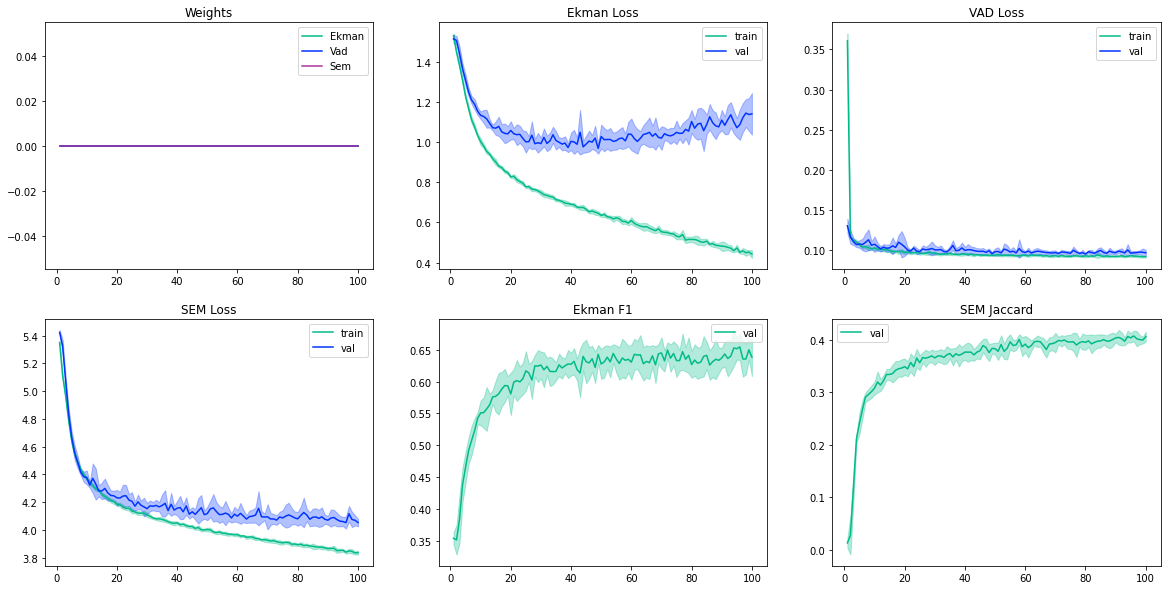

In [148]:
summary.plot()

In [149]:
# Combined, no GradNorm
summary.summary()

Ekman Loss: 0.510 +- 0.043
VAD Loss: 0.092 +- 0.002
sem Loss: 3.994 +- 0.017
Avg Loss: 4.596 +- 0.053
Avg F1: 0.825 +- 0.018
Avg Jaccard: 0.437 +- 0.006


## Ekman + SEM

In [150]:
%%capture experiment
summary2 = Results_Summary()

log_with_wandb = True

config = {
    "dataset": "ekman-sem",
    "val_dataset": "ekman-sem",
    "gradNorm": False,
    "alpha": 1.0,
    "dropout": 0.5,
    'h_size': 256,
    'weight_decay': 1e-5,
    'lr': 5e-4,
}

for i in range(10):
  if log_with_wandb:
    wandb.init(project="MultiEmo", name=f'Ekman+Sem_{i+1}', config=config)

  exp2 = TrainingManager(dataloaders, config, wandb=log_with_wandb)
  exp2.train(epochs=100, log=True)

  losses, f1, mse, jaccard = exp2._evaluate(dataloaders['combined']['test'])
  test_results = {'ekman_loss': losses[0], 'vad_loss': losses[1], 'sem_loss': losses[2], 'loss': losses.sum(), 'f1': f1, 'jaccard': jaccard}

  summary2.add_history(exp2.history)
  summary2.add_test_results(test_results)

  if log_with_wandb:
    for k, v in test_results.items():
      wandb.summary[k+'_test'] = v
    close_wandb()

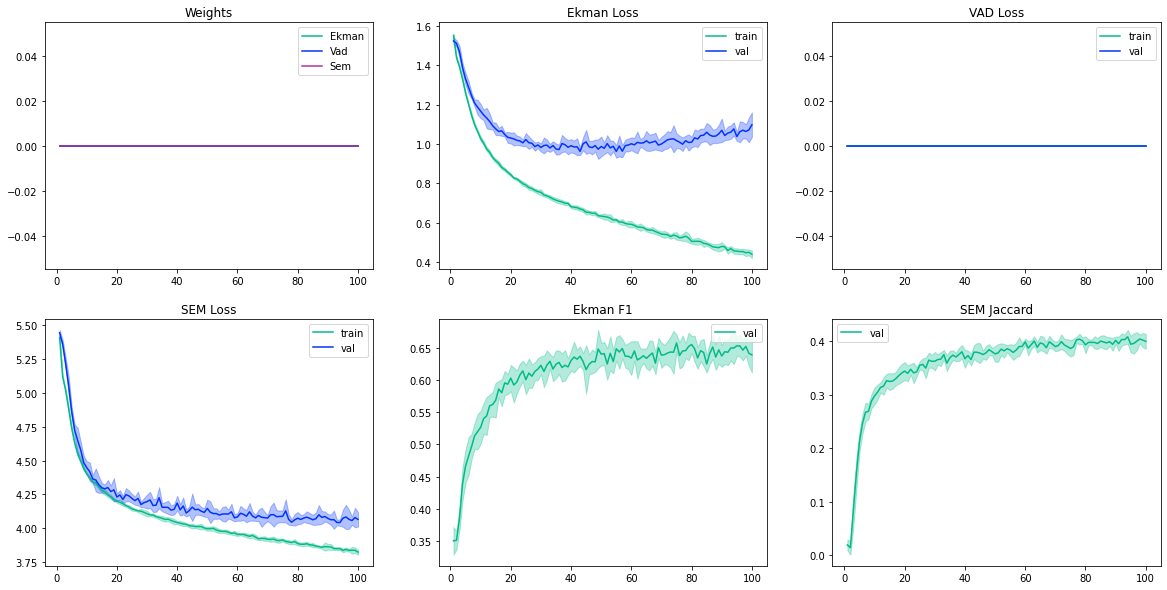

In [151]:
summary2.plot()

In [152]:
summary2.summary()

Ekman Loss: 0.498 +- 0.024
VAD Loss: 1.145 +- 0.000
sem Loss: 4.012 +- 0.038
Avg Loss: 5.655 +- 0.046
Avg F1: 0.827 +- 0.012
Avg Jaccard: 0.435 +- 0.008


## Ekman + VAD

In [153]:
%%capture experiment
summary3 = Results_Summary()

log_with_wandb = True

config = {
    "dataset": "ekman-vad",
    "val_dataset": "ekman-vad",
    "gradNorm": False,
    "alpha": 1.0,
    "dropout": 0.5,
    'h_size': 256,
    'weight_decay': 1e-5,
    'lr': 5e-4,
}

for i in range(10):
  if log_with_wandb:
    wandb.init(project="MultiEmo", name=f'Ekman+VAD{i+1}', config=config)

  exp3 = TrainingManager(dataloaders, config, wandb=log_with_wandb)
  exp3.train(epochs=100, log=True)

  losses, f1, mse, jaccard = exp3._evaluate(dataloaders['combined']['test'])
  test_results = {'ekman_loss': losses[0], 'vad_loss': losses[1], 'sem_loss': losses[2], 'loss': losses.sum(), 'f1': f1, 'jaccard': jaccard}

  summary3.add_history(exp3.history)
  summary3.add_test_results(test_results)

  if log_with_wandb:
    for k, v in test_results.items():
      wandb.summary[k+'_test'] = v
    close_wandb()

ValueError: ignored

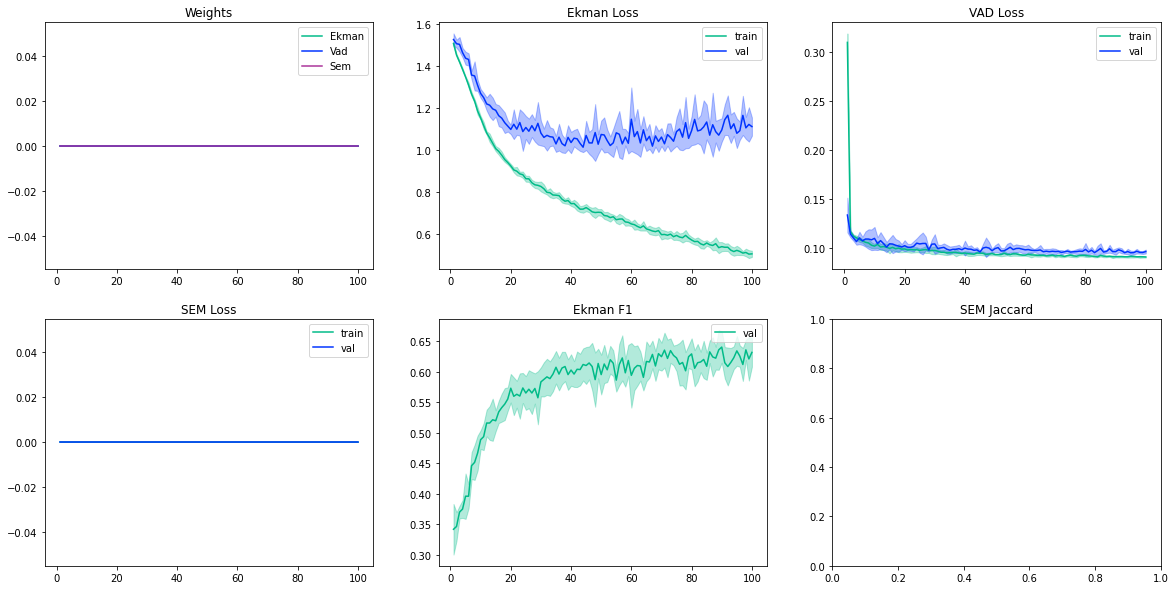

In [154]:
summary3.plot()

In [155]:
summary3.summary()

Ekman Loss: 0.541 +- 0.029
VAD Loss: 0.092 +- 0.001
sem Loss: 7.625 +- 0.000
Avg Loss: 8.258 +- 0.029
Avg F1: 0.811 +- 0.009
Avg Jaccard: 0.000 +- 0.000


## VAD + SEM

In [ ]:
%%capture experiment
summary5 = Results_Summary()

log_with_wandb = True

config = {
    "dataset": "vad-sem",
    "val_dataset": "vad-sem",
    "gradNorm": False,
    "alpha": 1.0,
    "dropout": 0.5,
    'h_size': 256,
    'weight_decay': 1e-5,
    'lr': 5e-4,
}

for i in range(10):
  if log_with_wandb:
    wandb.init(project="MultiEmo", name=f'vad+sem{i+1}', config=config)

  exp5 = TrainingManager(dataloaders, config, wandb=log_with_wandb)
  exp5.train(epochs=100, log=True)

  losses, f1, mse, jaccard = exp5._evaluate(dataloaders['combined']['test'])
  test_results = {'ekman_loss': losses[0], 'vad_loss': losses[1], 'sem_loss': losses[2], 'loss': losses.sum(), 'f1': f1, 'jaccard': jaccard}

  summary5.add_history(exp5.history)
  summary5.add_test_results(test_results)

  if log_with_wandb:
    for k, v in test_results.items():
      wandb.summary[k+'_test'] = v
    close_wandb()

## Combined, with GradNorm

In [ ]:
%%capture experiment
summary4 = Results_Summary()

log_with_wandb = True

config = {
    "dataset": "combined",
    "val_dataset": "combined",
    "gradNorm": True,
    "alpha": 1.5,
    "dropout": 0.5,
    'h_size': 256,
    'weight_decay': 1e-5,
    'lr': 5e-4,
}

for i in range(10):
  if log_with_wandb:
    wandb.init(project="MultiEmo", name=f'Combined_GN_{i+1}', config=config)

  exp = TrainingManager(dataloaders, config, wandb=log_with_wandb)
  exp.train(epochs=100, log=True)

  losses, f1, mse, jaccard = exp._evaluate(dataloaders['combined']['test'])
  test_results = {'ekman_loss': losses[0], 'vad_loss': losses[1], 'sem_loss': losses[2], 'loss': losses.sum(), 'f1': f1, 'jaccard': jaccard}

  summary4.add_history(exp.history)
  summary4.add_test_results(test_results)

  if log_with_wandb:
    for k, v in test_results.items():
      wandb.summary[k+'_test'] = v
    # close_wandb()

Epoch 1: train ekman_loss = 1.580, vad loss = 0.401, sem loss = 5.338
Epoch 1: val ekman loss = 1.477, vad loss = 0.120, sem loss = 5.430
Epoch 1: f1 = 0.388, jaccard = 0.000
Epoch 1: avg. loss_weights = [1.0052893161773682, 0.982641339302063, 1.012068510055542], tensor([1.5979, 1.0292, 7.7913], device='cuda:0')
Epoch 2: train ekman_loss = 1.482, vad loss = 0.122, sem loss = 5.113
Epoch 2: val ekman loss = 1.408, vad loss = 0.115, sem loss = 5.262
Epoch 2: f1 = 0.393, jaccard = 0.036
Epoch 2: avg. loss_weights = [1.1093686819076538, 0.7919503450393677, 1.098681092262268], tensor([1.5979, 1.0292, 7.7913], device='cuda:0')
Epoch 3: train ekman_loss = 1.417, vad loss = 0.128, sem loss = 4.958
Epoch 3: val ekman loss = 1.328, vad loss = 0.154, sem loss = 5.070
Epoch 3: f1 = 0.434, jaccard = 0.138
Epoch 3: avg. loss_weights = [1.2536859512329102, 0.5731328725814819, 1.1731812953948975], tensor([1.5979, 1.0292, 7.7913], device='cuda:0')
Epoch 4: train ekman_loss = 1.341, vad loss = 0.120, se

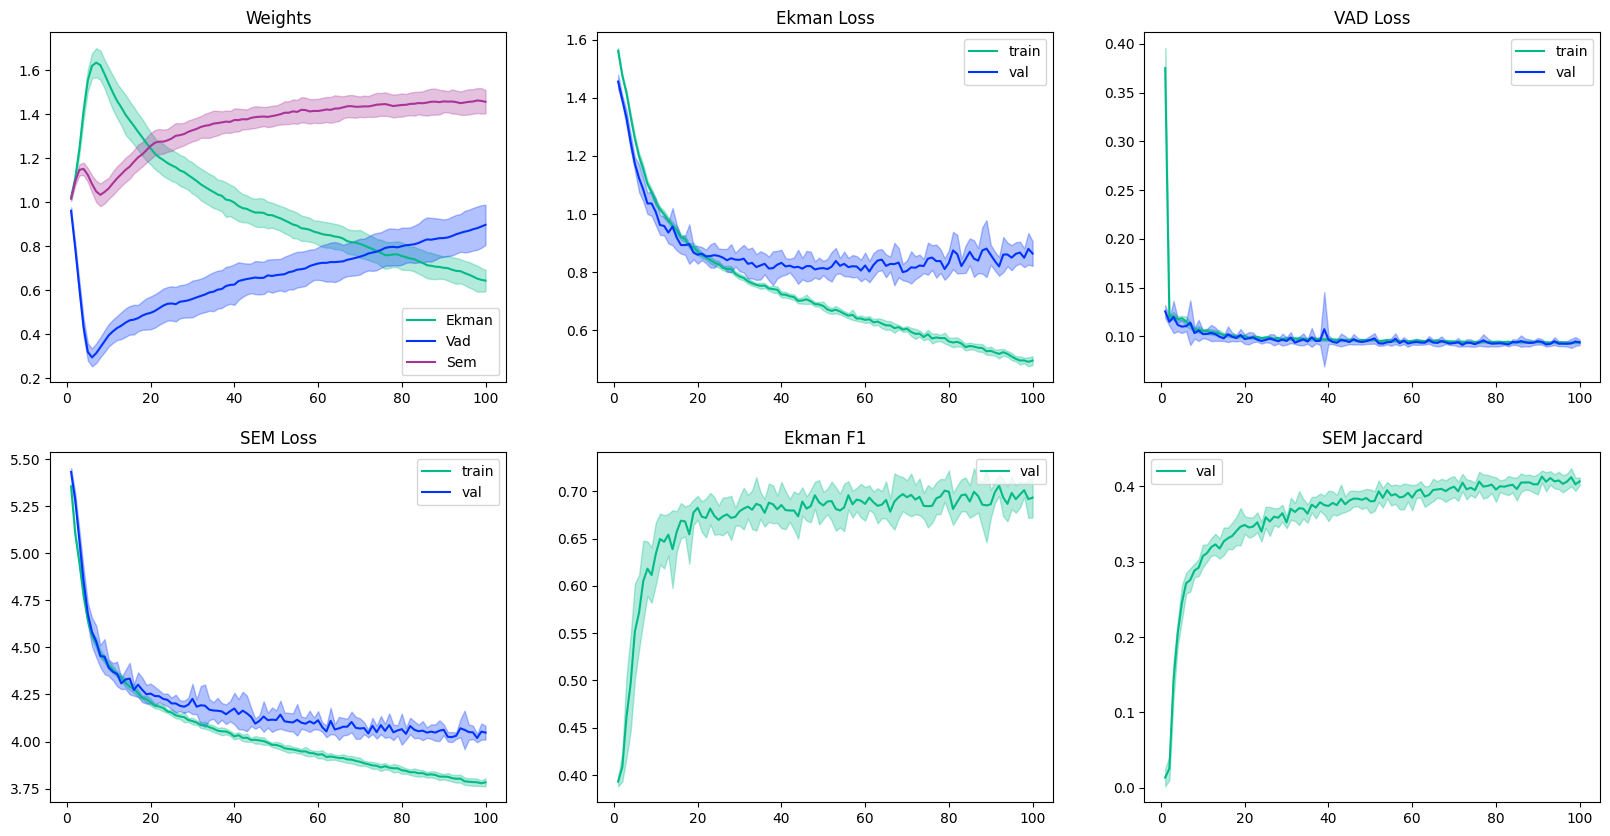

In [41]:
summary4.plot()

In [43]:
summary4.summary()

Ekman Loss: 0.501 +- 0.018
VAD Loss: 0.095 +- 0.002
sem Loss: 3.990 +- 0.026
Avg Loss: 4.586 +- 0.037
Avg F1: 0.815 +- 0.010
Avg Jaccard: 0.443 +- 0.005


# Archived Experiments

## Test weight decay

In [ ]:
# %%capture experiment
summary = Results_Summary()

log_with_wandb = False

config = {
    "dataset": "combined",
    "val_dataset": "combined",
    "gradNorm": True,
    "alpha": 1.0,
    "dropout": 0.5,
    'h_size': 256,
    'weight_decay': 1e-5,
}

i = 0

if log_with_wandb:
  wandb.init(project="MultiEmo", name=f'Experiment{i+1}', config=config)

exp2 = TrainingManager(dataloaders, config, wandb=log_with_wandb)
exp2.train(epochs=80, log=True)

losses, f1, mse, jaccard = exp2._evaluate(dataloaders['combined']['test'])
test_results = {'ekman_loss': losses[0], 'vad_loss': losses[1], 'sem_loss': losses[2], 'loss': losses.sum(), 'f1': f1, 'jaccard': jaccard}

summary.add_history(exp2.history)
summary.add_test_results(test_results)

if log_with_wandb:
  for k, v in test_results.items():
    wandb.summary[k+'_test'] = v
  close_wandb()


In [ ]:
exp2.evaluate()

TEST SET (combined)
Total Loss = 4.577
Ekman Loss = 0.586
VAD Loss = 0.004
sem Loss = 3.986
F1 = 0.8193
MSE = 0.0045
Jaccard = 0.4457
-----------------------
EVALUATING WITH BEST NET
TEST SET (combined)
Total Loss = 4.577
Ekman Loss = 0.586
VAD Loss = 0.004
sem Loss = 3.986
F1 = 0.8193
MSE = 0.0045
Jaccard = 0.4457


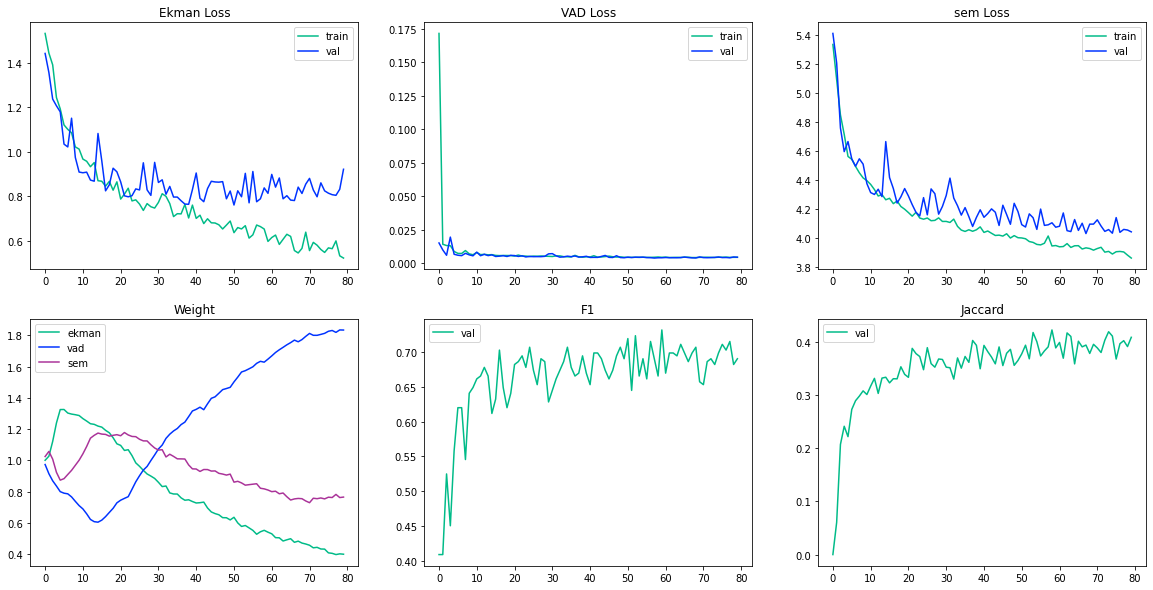

In [ ]:
exp2.plot_history()

In [ ]:
summary.summary()

Ekman Loss: 0.640 +- 0.037
VAD Loss: 0.004 +- 0.000
sem Loss: 4.117 +- 0.072
Avg Loss: 4.760 +- 0.104
Avg F1: 0.767 +- 0.018
Avg Jaccard: 0.417 +- 0.020


## Test weight decay

In [ ]:
config = {
    "dataset": "combined",
    "val_dataset": "combined",
    "gradNorm": True,
    "alpha": 1.0,
    "dropout": 0.5,
    'h_size': 256,
    'weight_decay': 1e-5,
}

exp2 = TrainingManager(dataloaders, config, wandb=False)

In [ ]:
exp2.evaluate()

TEST SET (combined)
Total Loss = 4.553
Ekman Loss = 0.504
VAD Loss = 0.089
sem Loss = 3.960
F1 = 0.8408
MSE = 0.0080
Jaccard = 0.4482
-----------------------
EVALUATING WITH BEST NET
TEST SET (combined)
Total Loss = 4.862
Ekman Loss = 0.718
VAD Loss = 0.095
sem Loss = 4.048
F1 = 0.7209
MSE = 0.0091
Jaccard = 0.4370


In [ ]:
exp2.train(epochs=50)

  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 1: train ekman_loss = 0.951, vad loss = 0.150, sem loss = 4.587
Epoch 1: val ekman loss = 1.014, vad loss = 0.108, sem loss = 4.182
Epoch 1: f1 = 0.603, jaccard = 0.344
Epoch 1: avg. loss_weights = [0.5597122311592102, 1.696653127670288, 0.7436347007751465], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 2: train ekman_loss = 0.642, vad loss = 0.094, sem loss = 4.056
Epoch 2: val ekman loss = 0.999, vad loss = 0.099, sem loss = 4.090
Epoch 2: f1 = 0.645, jaccard = 0.410
Epoch 2: avg. loss_weights = [0.5112734436988831, 1.8113594055175781, 0.6773676872253418], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 3: train ekman_loss = 0.625, vad loss = 0.092, sem loss = 3.996
Epoch 3: val ekman loss = 1.037, vad loss = 0.100, sem loss = 4.069
Epoch 3: f1 = 0.657, jaccard = 0.383
Epoch 3: avg. loss_weights = [0.46048232913017273, 1.891591191291809, 0.6479267477989197], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 4: train ekman_loss = 0.614, vad loss = 0.093, sem loss = 4.007
Epoch 4: val ekman loss = 1.086, vad loss = 0.097, sem loss = 4.120
Epoch 4: f1 = 0.620, jaccard = 0.390
Epoch 4: avg. loss_weights = [0.412378191947937, 1.9554911851882935, 0.6321302056312561], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 5: train ekman_loss = 0.578, vad loss = 0.092, sem loss = 3.986
Epoch 5: val ekman loss = 1.019, vad loss = 0.103, sem loss = 4.089
Epoch 5: f1 = 0.653, jaccard = 0.383
Epoch 5: avg. loss_weights = [0.3872111737728119, 2.0076091289520264, 0.605180025100708], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 6: train ekman_loss = 0.585, vad loss = 0.093, sem loss = 3.962
Epoch 6: val ekman loss = 1.038, vad loss = 0.095, sem loss = 4.128
Epoch 6: f1 = 0.632, jaccard = 0.361
Epoch 6: avg. loss_weights = [0.37047189474105835, 2.0541605949401855, 0.5753669142723083], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 7: train ekman_loss = 0.567, vad loss = 0.092, sem loss = 3.949
Epoch 7: val ekman loss = 1.097, vad loss = 0.094, sem loss = 4.082
Epoch 7: f1 = 0.645, jaccard = 0.394
Epoch 7: avg. loss_weights = [0.362166166305542, 2.0814177989959717, 0.5564159154891968], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 8: train ekman_loss = 0.571, vad loss = 0.092, sem loss = 3.958
Epoch 8: val ekman loss = 1.048, vad loss = 0.098, sem loss = 4.041
Epoch 8: f1 = 0.628, jaccard = 0.401
Epoch 8: avg. loss_weights = [0.33873724937438965, 2.102691888809204, 0.5585705637931824], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 9: train ekman_loss = 0.580, vad loss = 0.092, sem loss = 3.958
Epoch 9: val ekman loss = 1.142, vad loss = 0.094, sem loss = 4.188
Epoch 9: f1 = 0.632, jaccard = 0.385
Epoch 9: avg. loss_weights = [0.3399008810520172, 2.127823829650879, 0.5322760343551636], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 10: train ekman_loss = 0.572, vad loss = 0.093, sem loss = 3.954
Epoch 10: val ekman loss = 1.086, vad loss = 0.099, sem loss = 4.064
Epoch 10: f1 = 0.620, jaccard = 0.403
Epoch 10: avg. loss_weights = [0.32886597514152527, 2.1549291610717773, 0.5162054896354675], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 11: train ekman_loss = 0.560, vad loss = 0.093, sem loss = 3.950
Epoch 11: val ekman loss = 1.026, vad loss = 0.096, sem loss = 4.107
Epoch 11: f1 = 0.628, jaccard = 0.378
Epoch 11: avg. loss_weights = [0.317669540643692, 2.173112154006958, 0.5092178583145142], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 12: train ekman_loss = 0.552, vad loss = 0.091, sem loss = 3.930
Epoch 12: val ekman loss = 1.059, vad loss = 0.095, sem loss = 4.064
Epoch 12: f1 = 0.645, jaccard = 0.389
Epoch 12: avg. loss_weights = [0.3064500093460083, 2.1960930824279785, 0.4974571764469147], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 13: train ekman_loss = 0.571, vad loss = 0.093, sem loss = 3.946
Epoch 13: val ekman loss = 1.069, vad loss = 0.101, sem loss = 4.084
Epoch 13: f1 = 0.636, jaccard = 0.402
Epoch 13: avg. loss_weights = [0.3021140992641449, 2.2190041542053223, 0.478881299495697], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 14: train ekman_loss = 0.571, vad loss = 0.092, sem loss = 3.946
Epoch 14: val ekman loss = 1.061, vad loss = 0.095, sem loss = 4.100
Epoch 14: f1 = 0.636, jaccard = 0.362
Epoch 14: avg. loss_weights = [0.30835050344467163, 2.2124714851379395, 0.4791770875453949], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 15: train ekman_loss = 0.573, vad loss = 0.091, sem loss = 3.934
Epoch 15: val ekman loss = 1.114, vad loss = 0.094, sem loss = 4.056
Epoch 15: f1 = 0.640, jaccard = 0.393
Epoch 15: avg. loss_weights = [0.30188804864883423, 2.2152702808380127, 0.48284244537353516], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 16: train ekman_loss = 0.558, vad loss = 0.091, sem loss = 3.947
Epoch 16: val ekman loss = 1.073, vad loss = 0.093, sem loss = 4.116
Epoch 16: f1 = 0.653, jaccard = 0.412
Epoch 16: avg. loss_weights = [0.2840030789375305, 2.240004777908325, 0.47599175572395325], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 17: train ekman_loss = 0.560, vad loss = 0.092, sem loss = 3.939
Epoch 17: val ekman loss = 1.051, vad loss = 0.094, sem loss = 4.105
Epoch 17: f1 = 0.665, jaccard = 0.391
Epoch 17: avg. loss_weights = [0.28698745369911194, 2.2495081424713135, 0.46350419521331787], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 18: train ekman_loss = 0.546, vad loss = 0.092, sem loss = 3.936
Epoch 18: val ekman loss = 1.116, vad loss = 0.095, sem loss = 4.060
Epoch 18: f1 = 0.612, jaccard = 0.403
Epoch 18: avg. loss_weights = [0.28574076294898987, 2.253380298614502, 0.4608793258666992], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 19: train ekman_loss = 0.553, vad loss = 0.093, sem loss = 3.929
Epoch 19: val ekman loss = 1.101, vad loss = 0.096, sem loss = 4.141
Epoch 19: f1 = 0.624, jaccard = 0.402
Epoch 19: avg. loss_weights = [0.29178857803344727, 2.249359369277954, 0.4588521420955658], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 20: train ekman_loss = 0.535, vad loss = 0.092, sem loss = 3.932
Epoch 20: val ekman loss = 1.061, vad loss = 0.094, sem loss = 4.061
Epoch 20: f1 = 0.620, jaccard = 0.409
Epoch 20: avg. loss_weights = [0.27871066331863403, 2.2569172382354736, 0.46437302231788635], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 21: train ekman_loss = 0.537, vad loss = 0.092, sem loss = 3.905
Epoch 21: val ekman loss = 1.076, vad loss = 0.096, sem loss = 4.114
Epoch 21: f1 = 0.674, jaccard = 0.387
Epoch 21: avg. loss_weights = [0.27433428168296814, 2.265681743621826, 0.45998361706733704], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 22: train ekman_loss = 0.541, vad loss = 0.091, sem loss = 3.927
Epoch 22: val ekman loss = 1.101, vad loss = 0.102, sem loss = 4.120
Epoch 22: f1 = 0.649, jaccard = 0.392
Epoch 22: avg. loss_weights = [0.2815471589565277, 2.256678581237793, 0.461774080991745], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 23: train ekman_loss = 0.575, vad loss = 0.092, sem loss = 3.923
Epoch 23: val ekman loss = 1.116, vad loss = 0.095, sem loss = 4.178
Epoch 23: f1 = 0.645, jaccard = 0.383
Epoch 23: avg. loss_weights = [0.2731322646141052, 2.264511823654175, 0.462355375289917], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 24: train ekman_loss = 0.544, vad loss = 0.091, sem loss = 3.924
Epoch 24: val ekman loss = 1.143, vad loss = 0.094, sem loss = 4.216
Epoch 24: f1 = 0.661, jaccard = 0.370
Epoch 24: avg. loss_weights = [0.27510255575180054, 2.275339126586914, 0.44955766201019287], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 25: train ekman_loss = 0.578, vad loss = 0.091, sem loss = 3.917
Epoch 25: val ekman loss = 1.063, vad loss = 0.095, sem loss = 4.032
Epoch 25: f1 = 0.674, jaccard = 0.409
Epoch 25: avg. loss_weights = [0.27152219414711, 2.2803409099578857, 0.4481368064880371], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 26: train ekman_loss = 0.525, vad loss = 0.090, sem loss = 3.901
Epoch 26: val ekman loss = 1.321, vad loss = 0.098, sem loss = 4.028
Epoch 26: f1 = 0.620, jaccard = 0.412
Epoch 26: avg. loss_weights = [0.26624420285224915, 2.295236825942993, 0.43851855397224426], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 27: train ekman_loss = 0.518, vad loss = 0.091, sem loss = 3.897
Epoch 27: val ekman loss = 1.073, vad loss = 0.097, sem loss = 4.024
Epoch 27: f1 = 0.649, jaccard = 0.383
Epoch 27: avg. loss_weights = [0.246766597032547, 2.3112761974334717, 0.4419578015804291], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 28: train ekman_loss = 0.541, vad loss = 0.091, sem loss = 3.889
Epoch 28: val ekman loss = 1.088, vad loss = 0.093, sem loss = 4.114
Epoch 28: f1 = 0.653, jaccard = 0.395
Epoch 28: avg. loss_weights = [0.24979554116725922, 2.2971031665802, 0.45310068130493164], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 29: train ekman_loss = 0.510, vad loss = 0.090, sem loss = 3.890
Epoch 29: val ekman loss = 1.165, vad loss = 0.095, sem loss = 4.149
Epoch 29: f1 = 0.607, jaccard = 0.392
Epoch 29: avg. loss_weights = [0.2525956630706787, 2.306941032409668, 0.44046342372894287], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 30: train ekman_loss = 0.491, vad loss = 0.091, sem loss = 3.884
Epoch 30: val ekman loss = 1.088, vad loss = 0.095, sem loss = 4.120
Epoch 30: f1 = 0.640, jaccard = 0.406
Epoch 30: avg. loss_weights = [0.24740946292877197, 2.3018062114715576, 0.45078328251838684], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 31: train ekman_loss = 0.478, vad loss = 0.091, sem loss = 3.899
Epoch 31: val ekman loss = 1.190, vad loss = 0.100, sem loss = 4.131
Epoch 31: f1 = 0.616, jaccard = 0.388
Epoch 31: avg. loss_weights = [0.25110283493995667, 2.2959179878234863, 0.45297980308532715], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 32: train ekman_loss = 0.504, vad loss = 0.091, sem loss = 3.906
Epoch 32: val ekman loss = 1.107, vad loss = 0.093, sem loss = 4.091
Epoch 32: f1 = 0.632, jaccard = 0.411
Epoch 32: avg. loss_weights = [0.25899040699005127, 2.3023910522460938, 0.43861833214759827], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 33: train ekman_loss = 0.538, vad loss = 0.091, sem loss = 3.885
Epoch 33: val ekman loss = 1.286, vad loss = 0.098, sem loss = 4.051
Epoch 33: f1 = 0.616, jaccard = 0.386
Epoch 33: avg. loss_weights = [0.2407171130180359, 2.320887327194214, 0.4383961856365204], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 34: train ekman_loss = 0.487, vad loss = 0.090, sem loss = 3.870
Epoch 34: val ekman loss = 1.174, vad loss = 0.097, sem loss = 4.028
Epoch 34: f1 = 0.612, jaccard = 0.404
Epoch 34: avg. loss_weights = [0.23706017434597015, 2.339855194091797, 0.42308488488197327], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 35: train ekman_loss = 0.502, vad loss = 0.091, sem loss = 3.878
Epoch 35: val ekman loss = 1.205, vad loss = 0.092, sem loss = 4.021
Epoch 35: f1 = 0.640, jaccard = 0.411
Epoch 35: avg. loss_weights = [0.2385198324918747, 2.3535327911376953, 0.4079478085041046], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 36: train ekman_loss = 0.479, vad loss = 0.090, sem loss = 3.876
Epoch 36: val ekman loss = 1.190, vad loss = 0.092, sem loss = 4.039
Epoch 36: f1 = 0.624, jaccard = 0.401
Epoch 36: avg. loss_weights = [0.22193503379821777, 2.3661227226257324, 0.4119417667388916], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 37: train ekman_loss = 0.497, vad loss = 0.090, sem loss = 3.869
Epoch 37: val ekman loss = 1.180, vad loss = 0.095, sem loss = 4.035
Epoch 37: f1 = 0.661, jaccard = 0.393
Epoch 37: avg. loss_weights = [0.2312619984149933, 2.353848934173584, 0.41488954424858093], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 38: train ekman_loss = 0.551, vad loss = 0.090, sem loss = 3.891
Epoch 38: val ekman loss = 1.182, vad loss = 0.093, sem loss = 4.023
Epoch 38: f1 = 0.645, jaccard = 0.410
Epoch 38: avg. loss_weights = [0.2387431114912033, 2.3441994190216064, 0.41705745458602905], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 39: train ekman_loss = 0.467, vad loss = 0.090, sem loss = 3.877
Epoch 39: val ekman loss = 1.088, vad loss = 0.094, sem loss = 4.034
Epoch 39: f1 = 0.632, jaccard = 0.409
Epoch 39: avg. loss_weights = [0.23449844121932983, 2.346705675125122, 0.41879573464393616], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 40: train ekman_loss = 0.478, vad loss = 0.091, sem loss = 3.866
Epoch 40: val ekman loss = 1.109, vad loss = 0.092, sem loss = 4.034
Epoch 40: f1 = 0.657, jaccard = 0.418
Epoch 40: avg. loss_weights = [0.23279857635498047, 2.3470630645751953, 0.42013779282569885], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 41: train ekman_loss = 0.451, vad loss = 0.091, sem loss = 3.867
Epoch 41: val ekman loss = 1.131, vad loss = 0.091, sem loss = 4.098
Epoch 41: f1 = 0.628, jaccard = 0.402
Epoch 41: avg. loss_weights = [0.23023198544979095, 2.3517093658447266, 0.41805902123451233], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 42: train ekman_loss = 0.529, vad loss = 0.091, sem loss = 3.870
Epoch 42: val ekman loss = 1.162, vad loss = 0.092, sem loss = 4.045
Epoch 42: f1 = 0.628, jaccard = 0.402
Epoch 42: avg. loss_weights = [0.21393178403377533, 2.380100727081299, 0.4059675335884094], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 43: train ekman_loss = 0.485, vad loss = 0.090, sem loss = 3.837
Epoch 43: val ekman loss = 1.145, vad loss = 0.092, sem loss = 4.171
Epoch 43: f1 = 0.661, jaccard = 0.368
Epoch 43: avg. loss_weights = [0.2181895226240158, 2.3777265548706055, 0.404084175825119], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 44: train ekman_loss = 0.452, vad loss = 0.090, sem loss = 3.848
Epoch 44: val ekman loss = 1.138, vad loss = 0.093, sem loss = 4.046
Epoch 44: f1 = 0.640, jaccard = 0.422
Epoch 44: avg. loss_weights = [0.21370857954025269, 2.3832688331604004, 0.40302351117134094], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 45: train ekman_loss = 0.511, vad loss = 0.090, sem loss = 3.854
Epoch 45: val ekman loss = 1.213, vad loss = 0.093, sem loss = 4.047
Epoch 45: f1 = 0.616, jaccard = 0.416
Epoch 45: avg. loss_weights = [0.20932120084762573, 2.387402296066284, 0.4032764136791229], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 46: train ekman_loss = 0.471, vad loss = 0.090, sem loss = 3.847
Epoch 46: val ekman loss = 1.179, vad loss = 0.093, sem loss = 4.139
Epoch 46: f1 = 0.645, jaccard = 0.415
Epoch 46: avg. loss_weights = [0.2086023986339569, 2.3973050117492676, 0.3940926492214203], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 47: train ekman_loss = 0.466, vad loss = 0.089, sem loss = 3.829
Epoch 47: val ekman loss = 1.105, vad loss = 0.096, sem loss = 4.072
Epoch 47: f1 = 0.624, jaccard = 0.423
Epoch 47: avg. loss_weights = [0.20854882895946503, 2.3958051204681396, 0.3956466317176819], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 48: train ekman_loss = 0.484, vad loss = 0.090, sem loss = 3.855
Epoch 48: val ekman loss = 1.118, vad loss = 0.097, sem loss = 4.166
Epoch 48: f1 = 0.669, jaccard = 0.415
Epoch 48: avg. loss_weights = [0.2175898551940918, 2.3717474937438965, 0.410663902759552], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 49: train ekman_loss = 0.432, vad loss = 0.091, sem loss = 3.843
Epoch 49: val ekman loss = 1.139, vad loss = 0.093, sem loss = 4.127
Epoch 49: f1 = 0.682, jaccard = 0.379
Epoch 49: avg. loss_weights = [0.20855145156383514, 2.3777713775634766, 0.413677453994751], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 50: train ekman_loss = 0.456, vad loss = 0.090, sem loss = 3.845
Epoch 50: val ekman loss = 1.196, vad loss = 0.093, sem loss = 4.009
Epoch 50: f1 = 0.628, jaccard = 0.413
Epoch 50: avg. loss_weights = [0.21815824508666992, 2.388763666152954, 0.39307788014411926], tensor([1.4156, 1.0048, 7.6551], device='cuda:0')


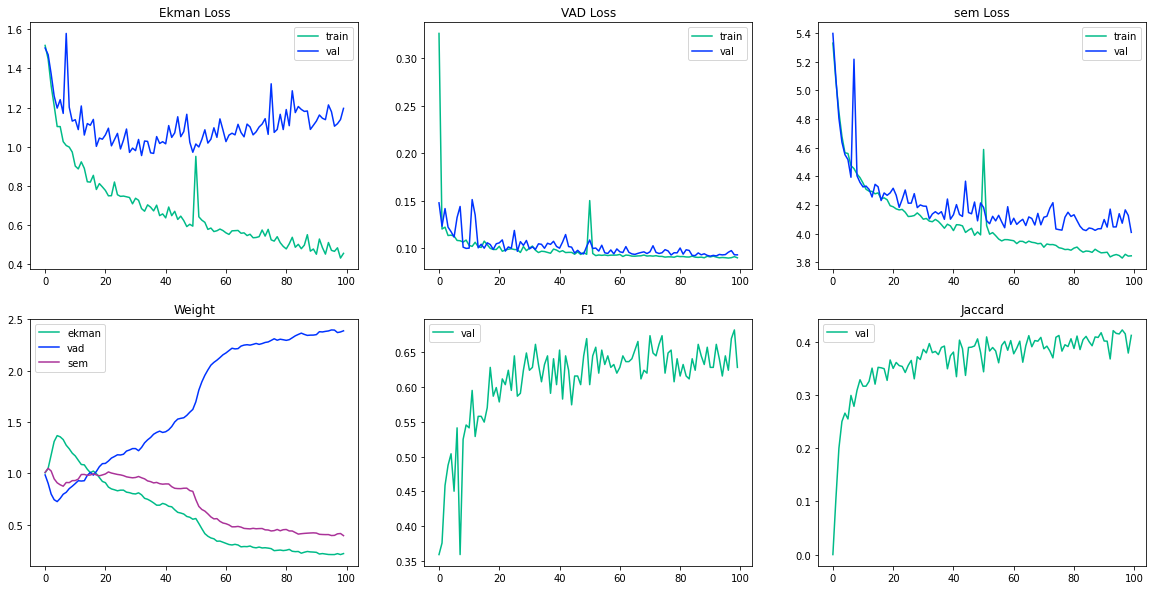

In [ ]:
exp2.plot_history()

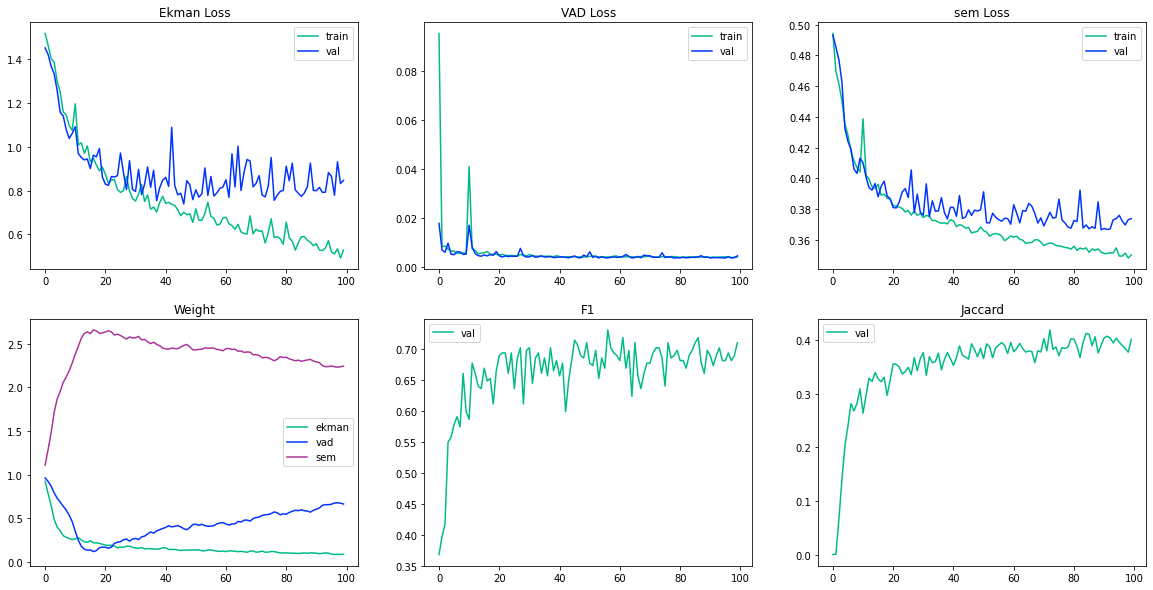

In [ ]:
exp2.plot_history()

### Test lower alpha

In [ ]:
config = {
    "dataset": "combined",
    "val_dataset": "combined",
    "gradNorm": True,
    "alpha": 0.5,
    "dropout": 0.5,
    'h_size': 256,
    'weight_decay': 1e-5,
}

exp3 = TrainingManager(dataloaders, config, wandb=False)

In [ ]:
exp3.evaluate()

TEST SET (combined)
Total Loss = 4.881
Ekman Loss = 0.735
VAD Loss = 0.094
sem Loss = 4.051
F1 = 0.7048
MSE = 0.0089
Jaccard = 0.4218
-----------------------
EVALUATING WITH BEST NET
TEST SET (combined)
Total Loss = 4.811
Ekman Loss = 0.676
VAD Loss = 0.090
sem Loss = 4.045
F1 = 0.7639
MSE = 0.0081
Jaccard = 0.4026


In [ ]:
exp3.train(epochs=50)

  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 1: train ekman_loss = 1.518, vad loss = 0.328, sem loss = 5.330
Epoch 1: val ekman loss = 1.529, vad loss = 0.163, sem loss = 5.428
Epoch 1: f1 = 0.277, jaccard = 0.000
Epoch 1: avg. loss_weights = [0.9300736784934998, 1.0329113006591797, 1.0370148420333862], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 2: train ekman_loss = 1.399, vad loss = 0.120, sem loss = 5.042
Epoch 2: val ekman loss = 1.513, vad loss = 0.135, sem loss = 5.090
Epoch 2: f1 = 0.343, jaccard = 0.114
Epoch 2: avg. loss_weights = [0.8979395031929016, 1.025743007659912, 1.0763169527053833], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 3: train ekman_loss = 1.295, vad loss = 0.111, sem loss = 4.788
Epoch 3: val ekman loss = 1.348, vad loss = 0.105, sem loss = 5.003
Epoch 3: f1 = 0.442, jaccard = 0.195
Epoch 3: avg. loss_weights = [0.9437825679779053, 1.0454320907592773, 1.0107848644256592], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 4: train ekman_loss = 1.217, vad loss = 0.113, sem loss = 4.626
Epoch 4: val ekman loss = 1.307, vad loss = 0.107, sem loss = 4.620
Epoch 4: f1 = 0.463, jaccard = 0.260
Epoch 4: avg. loss_weights = [0.9756213426589966, 1.1236133575439453, 0.9007654786109924], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 5: train ekman_loss = 1.146, vad loss = 0.106, sem loss = 4.547
Epoch 5: val ekman loss = 1.208, vad loss = 0.111, sem loss = 4.501
Epoch 5: f1 = 0.517, jaccard = 0.263
Epoch 5: avg. loss_weights = [0.9641595482826233, 1.2317992448806763, 0.8040416240692139], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 6: train ekman_loss = 1.079, vad loss = 0.103, sem loss = 4.484
Epoch 6: val ekman loss = 1.147, vad loss = 0.143, sem loss = 4.497
Epoch 6: f1 = 0.570, jaccard = 0.275
Epoch 6: avg. loss_weights = [0.9164298176765442, 1.351914405822754, 0.731656014919281], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 7: train ekman_loss = 1.064, vad loss = 0.104, sem loss = 4.442
Epoch 7: val ekman loss = 1.161, vad loss = 0.115, sem loss = 4.389
Epoch 7: f1 = 0.521, jaccard = 0.279
Epoch 7: avg. loss_weights = [0.8387302160263062, 1.448266625404358, 0.7130026817321777], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 8: train ekman_loss = 0.986, vad loss = 0.102, sem loss = 4.400
Epoch 8: val ekman loss = 1.131, vad loss = 0.105, sem loss = 4.524
Epoch 8: f1 = 0.579, jaccard = 0.305
Epoch 8: avg. loss_weights = [0.769403338432312, 1.5449212789535522, 0.6856756806373596], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 9: train ekman_loss = 0.942, vad loss = 0.102, sem loss = 4.370
Epoch 9: val ekman loss = 1.139, vad loss = 0.100, sem loss = 4.411
Epoch 9: f1 = 0.545, jaccard = 0.313
Epoch 9: avg. loss_weights = [0.7069682478904724, 1.6407959461212158, 0.652237057685852], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 10: train ekman_loss = 0.929, vad loss = 0.100, sem loss = 4.356
Epoch 10: val ekman loss = 1.087, vad loss = 0.121, sem loss = 4.401
Epoch 10: f1 = 0.558, jaccard = 0.314
Epoch 10: avg. loss_weights = [0.6317594647407532, 1.7281635999679565, 0.6400774717330933], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 11: train ekman_loss = 0.881, vad loss = 0.100, sem loss = 4.318
Epoch 11: val ekman loss = 1.199, vad loss = 0.103, sem loss = 4.283
Epoch 11: f1 = 0.525, jaccard = 0.334
Epoch 11: avg. loss_weights = [0.5951129198074341, 1.7916373014450073, 0.6132501363754272], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 12: train ekman_loss = 0.880, vad loss = 0.097, sem loss = 4.303
Epoch 12: val ekman loss = 1.087, vad loss = 0.097, sem loss = 4.334
Epoch 12: f1 = 0.558, jaccard = 0.319
Epoch 12: avg. loss_weights = [0.5698681473731995, 1.8714983463287354, 0.5586335062980652], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 13: train ekman_loss = 0.896, vad loss = 0.099, sem loss = 4.280
Epoch 13: val ekman loss = 1.086, vad loss = 0.114, sem loss = 4.237
Epoch 13: f1 = 0.570, jaccard = 0.357
Epoch 13: avg. loss_weights = [0.5288621783256531, 1.9307974576950073, 0.5403400659561157], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 14: train ekman_loss = 0.863, vad loss = 0.098, sem loss = 4.253
Epoch 14: val ekman loss = 1.064, vad loss = 0.101, sem loss = 4.352
Epoch 14: f1 = 0.603, jaccard = 0.328
Epoch 14: avg. loss_weights = [0.49551528692245483, 1.9761091470718384, 0.5283756256103516], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 15: train ekman_loss = 0.860, vad loss = 0.096, sem loss = 4.229
Epoch 15: val ekman loss = 1.013, vad loss = 0.102, sem loss = 4.216
Epoch 15: f1 = 0.599, jaccard = 0.361
Epoch 15: avg. loss_weights = [0.4576992094516754, 2.034651517868042, 0.5076497197151184], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 16: train ekman_loss = 0.841, vad loss = 0.096, sem loss = 4.216
Epoch 16: val ekman loss = 1.031, vad loss = 0.098, sem loss = 4.242
Epoch 16: f1 = 0.591, jaccard = 0.383
Epoch 16: avg. loss_weights = [0.44071564078330994, 2.071553945541382, 0.48772966861724854], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 17: train ekman_loss = 0.826, vad loss = 0.096, sem loss = 4.229
Epoch 17: val ekman loss = 1.140, vad loss = 0.097, sem loss = 4.280
Epoch 17: f1 = 0.558, jaccard = 0.356
Epoch 17: avg. loss_weights = [0.4044176936149597, 2.114037036895752, 0.48154523968696594], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 18: train ekman_loss = 0.780, vad loss = 0.099, sem loss = 4.206
Epoch 18: val ekman loss = 1.005, vad loss = 0.112, sem loss = 4.193
Epoch 18: f1 = 0.603, jaccard = 0.340
Epoch 18: avg. loss_weights = [0.4033096134662628, 2.135950803756714, 0.46073976159095764], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 19: train ekman_loss = 0.845, vad loss = 0.098, sem loss = 4.179
Epoch 19: val ekman loss = 1.087, vad loss = 0.104, sem loss = 4.336
Epoch 19: f1 = 0.574, jaccard = 0.354
Epoch 19: avg. loss_weights = [0.411569207906723, 2.1287384033203125, 0.4596922695636749], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 20: train ekman_loss = 0.790, vad loss = 0.093, sem loss = 4.159
Epoch 20: val ekman loss = 0.988, vad loss = 0.097, sem loss = 4.243
Epoch 20: f1 = 0.632, jaccard = 0.348
Epoch 20: avg. loss_weights = [0.38896721601486206, 2.1631557941436768, 0.44787687063217163], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 21: train ekman_loss = 0.800, vad loss = 0.096, sem loss = 4.177
Epoch 21: val ekman loss = 0.992, vad loss = 0.097, sem loss = 4.196
Epoch 21: f1 = 0.607, jaccard = 0.345
Epoch 21: avg. loss_weights = [0.3562059998512268, 2.2156760692596436, 0.42811861634254456], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 22: train ekman_loss = 0.756, vad loss = 0.092, sem loss = 4.130
Epoch 22: val ekman loss = 0.997, vad loss = 0.096, sem loss = 4.148
Epoch 22: f1 = 0.603, jaccard = 0.366
Epoch 22: avg. loss_weights = [0.33670809864997864, 2.261770248413086, 0.40152090787887573], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 23: train ekman_loss = 0.782, vad loss = 0.094, sem loss = 4.132
Epoch 23: val ekman loss = 1.034, vad loss = 0.098, sem loss = 4.148
Epoch 23: f1 = 0.603, jaccard = 0.362
Epoch 23: avg. loss_weights = [0.3218078315258026, 2.2852730751037598, 0.3929188847541809], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 24: train ekman_loss = 0.771, vad loss = 0.091, sem loss = 4.104
Epoch 24: val ekman loss = 0.982, vad loss = 0.093, sem loss = 4.151
Epoch 24: f1 = 0.624, jaccard = 0.351
Epoch 24: avg. loss_weights = [0.29045289754867554, 2.325986385345459, 0.3835605978965759], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 25: train ekman_loss = 0.752, vad loss = 0.094, sem loss = 4.112
Epoch 25: val ekman loss = 1.011, vad loss = 0.097, sem loss = 4.284
Epoch 25: f1 = 0.595, jaccard = 0.331
Epoch 25: avg. loss_weights = [0.29280707240104675, 2.3445215225219727, 0.3626706600189209], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 26: train ekman_loss = 0.748, vad loss = 0.093, sem loss = 4.108
Epoch 26: val ekman loss = 0.992, vad loss = 0.098, sem loss = 4.136
Epoch 26: f1 = 0.632, jaccard = 0.375
Epoch 26: avg. loss_weights = [0.287057101726532, 2.342643976211548, 0.37029922008514404], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 27: train ekman_loss = 0.722, vad loss = 0.093, sem loss = 4.082
Epoch 27: val ekman loss = 0.973, vad loss = 0.099, sem loss = 4.148
Epoch 27: f1 = 0.645, jaccard = 0.349
Epoch 27: avg. loss_weights = [0.28472188115119934, 2.350846290588379, 0.36443212628364563], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 28: train ekman_loss = 0.749, vad loss = 0.092, sem loss = 4.088
Epoch 28: val ekman loss = 1.016, vad loss = 0.094, sem loss = 4.196
Epoch 28: f1 = 0.612, jaccard = 0.347
Epoch 28: avg. loss_weights = [0.28358301520347595, 2.333258867263794, 0.38315799832344055], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 29: train ekman_loss = 0.725, vad loss = 0.094, sem loss = 4.100
Epoch 29: val ekman loss = 1.004, vad loss = 0.101, sem loss = 4.232
Epoch 29: f1 = 0.607, jaccard = 0.357
Epoch 29: avg. loss_weights = [0.2750323712825775, 2.352461814880371, 0.3725052773952484], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 30: train ekman_loss = 0.735, vad loss = 0.092, sem loss = 4.098
Epoch 30: val ekman loss = 0.984, vad loss = 0.093, sem loss = 4.141
Epoch 30: f1 = 0.636, jaccard = 0.377
Epoch 30: avg. loss_weights = [0.2755807936191559, 2.3890221118927, 0.3353962004184723], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 31: train ekman_loss = 0.709, vad loss = 0.092, sem loss = 4.077
Epoch 31: val ekman loss = 1.060, vad loss = 0.097, sem loss = 4.196
Epoch 31: f1 = 0.566, jaccard = 0.354
Epoch 31: avg. loss_weights = [0.2701616883277893, 2.379836082458496, 0.350002259016037], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 32: train ekman_loss = 0.812, vad loss = 0.092, sem loss = 4.064
Epoch 32: val ekman loss = 0.990, vad loss = 0.105, sem loss = 4.143
Epoch 32: f1 = 0.616, jaccard = 0.375
Epoch 32: avg. loss_weights = [0.2558183968067169, 2.3995442390441895, 0.34463781118392944], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 33: train ekman_loss = 0.728, vad loss = 0.091, sem loss = 4.068
Epoch 33: val ekman loss = 0.978, vad loss = 0.094, sem loss = 4.139
Epoch 33: f1 = 0.649, jaccard = 0.388
Epoch 33: avg. loss_weights = [0.2551518976688385, 2.4270520210266113, 0.31779441237449646], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 34: train ekman_loss = 0.688, vad loss = 0.091, sem loss = 4.037
Epoch 34: val ekman loss = 1.084, vad loss = 0.096, sem loss = 4.103
Epoch 34: f1 = 0.587, jaccard = 0.398
Epoch 34: avg. loss_weights = [0.23660129308700562, 2.4525392055511475, 0.31085947155952454], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 35: train ekman_loss = 0.701, vad loss = 0.091, sem loss = 4.050
Epoch 35: val ekman loss = 1.091, vad loss = 0.096, sem loss = 4.143
Epoch 35: f1 = 0.612, jaccard = 0.382
Epoch 35: avg. loss_weights = [0.2423858344554901, 2.439617872238159, 0.3179956078529358], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 36: train ekman_loss = 0.662, vad loss = 0.091, sem loss = 4.042
Epoch 36: val ekman loss = 1.050, vad loss = 0.092, sem loss = 4.174
Epoch 36: f1 = 0.628, jaccard = 0.349
Epoch 36: avg. loss_weights = [0.2372056543827057, 2.4474844932556152, 0.3153088390827179], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 37: train ekman_loss = 0.716, vad loss = 0.091, sem loss = 4.049
Epoch 37: val ekman loss = 0.968, vad loss = 0.094, sem loss = 4.154
Epoch 37: f1 = 0.653, jaccard = 0.359
Epoch 37: avg. loss_weights = [0.23729224503040314, 2.4498908519744873, 0.31281688809394836], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 38: train ekman_loss = 0.671, vad loss = 0.091, sem loss = 4.020
Epoch 38: val ekman loss = 1.046, vad loss = 0.094, sem loss = 4.087
Epoch 38: f1 = 0.595, jaccard = 0.380
Epoch 38: avg. loss_weights = [0.23636393249034882, 2.455474376678467, 0.30816182494163513], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 39: train ekman_loss = 0.708, vad loss = 0.092, sem loss = 4.047
Epoch 39: val ekman loss = 1.320, vad loss = 0.092, sem loss = 4.146
Epoch 39: f1 = 0.537, jaccard = 0.361
Epoch 39: avg. loss_weights = [0.2390574812889099, 2.4463820457458496, 0.3145606219768524], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 40: train ekman_loss = 0.663, vad loss = 0.091, sem loss = 4.029
Epoch 40: val ekman loss = 0.933, vad loss = 0.094, sem loss = 4.093
Epoch 40: f1 = 0.632, jaccard = 0.372
Epoch 40: avg. loss_weights = [0.22556598484516144, 2.4676315784454346, 0.3068026900291443], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 41: train ekman_loss = 0.702, vad loss = 0.091, sem loss = 4.037
Epoch 41: val ekman loss = 0.973, vad loss = 0.095, sem loss = 4.079
Epoch 41: f1 = 0.632, jaccard = 0.411
Epoch 41: avg. loss_weights = [0.22369696199893951, 2.479585886001587, 0.2967163324356079], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 42: train ekman_loss = 0.661, vad loss = 0.090, sem loss = 4.014
Epoch 42: val ekman loss = 0.944, vad loss = 0.096, sem loss = 4.123
Epoch 42: f1 = 0.612, jaccard = 0.389
Epoch 42: avg. loss_weights = [0.22294878959655762, 2.469893217086792, 0.30715784430503845], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 43: train ekman_loss = 0.633, vad loss = 0.090, sem loss = 4.016
Epoch 43: val ekman loss = 0.981, vad loss = 0.097, sem loss = 4.127
Epoch 43: f1 = 0.636, jaccard = 0.373
Epoch 43: avg. loss_weights = [0.2198384553194046, 2.4892334938049316, 0.29092925786972046], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 44: train ekman_loss = 0.653, vad loss = 0.090, sem loss = 4.011
Epoch 44: val ekman loss = 0.964, vad loss = 0.093, sem loss = 4.087
Epoch 44: f1 = 0.649, jaccard = 0.359
Epoch 44: avg. loss_weights = [0.20818768441677094, 2.509244441986084, 0.2825681269168854], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 45: train ekman_loss = 0.664, vad loss = 0.089, sem loss = 4.030
Epoch 45: val ekman loss = 0.938, vad loss = 0.093, sem loss = 4.132
Epoch 45: f1 = 0.678, jaccard = 0.371
Epoch 45: avg. loss_weights = [0.2061837762594223, 2.507647752761841, 0.2861686944961548], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 46: train ekman_loss = 0.620, vad loss = 0.090, sem loss = 4.005
Epoch 46: val ekman loss = 1.000, vad loss = 0.092, sem loss = 4.094
Epoch 46: f1 = 0.624, jaccard = 0.391
Epoch 46: avg. loss_weights = [0.21401238441467285, 2.495600938796997, 0.290387362241745], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 47: train ekman_loss = 0.673, vad loss = 0.091, sem loss = 4.015
Epoch 47: val ekman loss = 0.976, vad loss = 0.094, sem loss = 4.082
Epoch 47: f1 = 0.649, jaccard = 0.366
Epoch 47: avg. loss_weights = [0.2135559767484665, 2.492846965789795, 0.29359662532806396], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 48: train ekman_loss = 0.655, vad loss = 0.090, sem loss = 4.003
Epoch 48: val ekman loss = 1.001, vad loss = 0.093, sem loss = 4.077
Epoch 48: f1 = 0.616, jaccard = 0.372
Epoch 48: avg. loss_weights = [0.1936643421649933, 2.518596649169922, 0.2877391576766968], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 49: train ekman_loss = 0.644, vad loss = 0.090, sem loss = 4.005
Epoch 49: val ekman loss = 1.008, vad loss = 0.093, sem loss = 4.077
Epoch 49: f1 = 0.636, jaccard = 0.380
Epoch 49: avg. loss_weights = [0.19598698616027832, 2.523606538772583, 0.2804052233695984], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 50: train ekman_loss = 0.603, vad loss = 0.089, sem loss = 3.970
Epoch 50: val ekman loss = 1.003, vad loss = 0.097, sem loss = 4.077
Epoch 50: f1 = 0.640, jaccard = 0.380
Epoch 50: avg. loss_weights = [0.19419652223587036, 2.545062303543091, 0.260741263628006], tensor([1.7300, 1.0934, 7.8855], device='cuda:0')


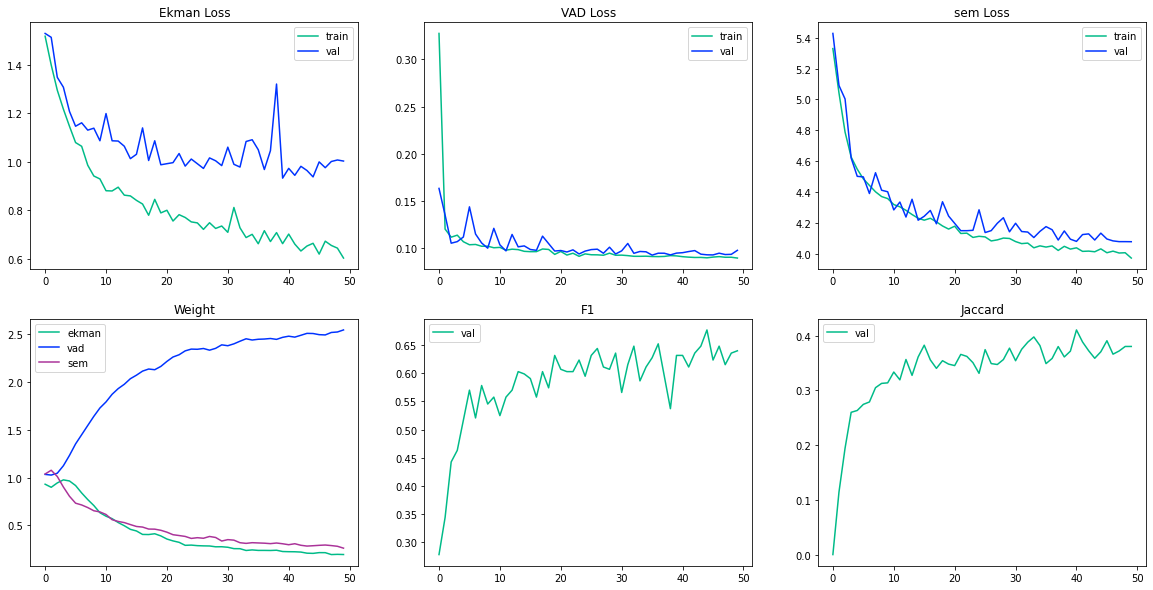

In [ ]:
exp3.plot_history()

### Test higher alpha

In [ ]:
config = {
    "dataset": "combined",
    "val_dataset": "combined",
    "gradNorm": True,
    "alpha": 2,
    "dropout": 0.5,
    'h_size': 256,
    'weight_decay': 1e-5,
}

exp4 = TrainingManager(dataloaders, config, wandb=False)

In [ ]:
exp4.evaluate()

TEST SET (combined)
Total Loss = 4.570
Ekman Loss = 0.475
VAD Loss = 0.092
sem Loss = 4.003
F1 = 0.8301
MSE = 0.0084
Jaccard = 0.4372
-----------------------
EVALUATING WITH BEST NET
TEST SET (combined)
Total Loss = 4.700
Ekman Loss = 0.630
VAD Loss = 0.093
sem Loss = 3.977
F1 = 0.7746
MSE = 0.0087
Jaccard = 0.4303


In [ ]:
exp4.train(epochs=50)

  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 1: train ekman_loss = 0.909, vad loss = 0.127, sem loss = 4.600
Epoch 1: val ekman loss = 1.073, vad loss = 0.101, sem loss = 4.355
Epoch 1: f1 = 0.612, jaccard = 0.343
Epoch 1: avg. loss_weights = [0.9086822271347046, 0.6148211359977722, 1.4764965772628784], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 2: train ekman_loss = 0.623, vad loss = 0.095, sem loss = 4.006
Epoch 2: val ekman loss = 1.083, vad loss = 0.101, sem loss = 4.199
Epoch 2: f1 = 0.607, jaccard = 0.385
Epoch 2: avg. loss_weights = [0.9038312435150146, 0.6468169093132019, 1.4493519067764282], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 3: train ekman_loss = 0.603, vad loss = 0.094, sem loss = 3.987
Epoch 3: val ekman loss = 0.973, vad loss = 0.098, sem loss = 4.092
Epoch 3: f1 = 0.653, jaccard = 0.403
Epoch 3: avg. loss_weights = [0.8871762752532959, 0.6668936014175415, 1.4459307193756104], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 4: train ekman_loss = 0.643, vad loss = 0.094, sem loss = 3.985
Epoch 4: val ekman loss = 0.943, vad loss = 0.099, sem loss = 4.078
Epoch 4: f1 = 0.665, jaccard = 0.391
Epoch 4: avg. loss_weights = [0.8640278577804565, 0.6969550848007202, 1.4390171766281128], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 5: train ekman_loss = 0.576, vad loss = 0.094, sem loss = 3.971
Epoch 5: val ekman loss = 1.008, vad loss = 0.097, sem loss = 4.116
Epoch 5: f1 = 0.632, jaccard = 0.401
Epoch 5: avg. loss_weights = [0.831359326839447, 0.7325922250747681, 1.4360482692718506], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 6: train ekman_loss = 0.611, vad loss = 0.094, sem loss = 3.977
Epoch 6: val ekman loss = 1.182, vad loss = 0.100, sem loss = 4.303
Epoch 6: f1 = 0.583, jaccard = 0.362
Epoch 6: avg. loss_weights = [0.8088518381118774, 0.7640284895896912, 1.4271202087402344], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 7: train ekman_loss = 0.569, vad loss = 0.095, sem loss = 3.988
Epoch 7: val ekman loss = 1.058, vad loss = 0.097, sem loss = 4.321
Epoch 7: f1 = 0.636, jaccard = 0.384
Epoch 7: avg. loss_weights = [0.7916190028190613, 0.7992599606513977, 1.4091203212738037], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 8: train ekman_loss = 0.610, vad loss = 0.094, sem loss = 3.948
Epoch 8: val ekman loss = 1.038, vad loss = 0.096, sem loss = 4.149
Epoch 8: f1 = 0.640, jaccard = 0.391
Epoch 8: avg. loss_weights = [0.776721179485321, 0.8175517320632935, 1.4057265520095825], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 9: train ekman_loss = 0.616, vad loss = 0.094, sem loss = 3.973
Epoch 9: val ekman loss = 1.009, vad loss = 0.100, sem loss = 4.077
Epoch 9: f1 = 0.640, jaccard = 0.402
Epoch 9: avg. loss_weights = [0.7568746209144592, 0.8301077485084534, 1.413016676902771], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 10: train ekman_loss = 0.581, vad loss = 0.094, sem loss = 3.949
Epoch 10: val ekman loss = 1.069, vad loss = 0.098, sem loss = 4.106
Epoch 10: f1 = 0.632, jaccard = 0.400
Epoch 10: avg. loss_weights = [0.7626887559890747, 0.8349601626396179, 1.4023516178131104], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 11: train ekman_loss = 0.613, vad loss = 0.096, sem loss = 3.960
Epoch 11: val ekman loss = 1.098, vad loss = 0.096, sem loss = 4.041
Epoch 11: f1 = 0.645, jaccard = 0.404
Epoch 11: avg. loss_weights = [0.7511506080627441, 0.859466552734375, 1.3893826007843018], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 12: train ekman_loss = 0.576, vad loss = 0.094, sem loss = 3.943
Epoch 12: val ekman loss = 1.116, vad loss = 0.095, sem loss = 4.057
Epoch 12: f1 = 0.640, jaccard = 0.400
Epoch 12: avg. loss_weights = [0.7446296811103821, 0.8751434087753296, 1.3802270889282227], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 13: train ekman_loss = 0.619, vad loss = 0.097, sem loss = 3.993
Epoch 13: val ekman loss = 0.978, vad loss = 0.096, sem loss = 4.085
Epoch 13: f1 = 0.653, jaccard = 0.401
Epoch 13: avg. loss_weights = [0.7279548048973083, 0.9093250632286072, 1.3627198934555054], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 14: train ekman_loss = 0.539, vad loss = 0.094, sem loss = 3.934
Epoch 14: val ekman loss = 1.266, vad loss = 0.097, sem loss = 4.106
Epoch 14: f1 = 0.591, jaccard = 0.406
Epoch 14: avg. loss_weights = [0.7205687165260315, 0.920983612537384, 1.358447551727295], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 15: train ekman_loss = 0.567, vad loss = 0.095, sem loss = 3.942
Epoch 15: val ekman loss = 0.991, vad loss = 0.097, sem loss = 4.024
Epoch 15: f1 = 0.682, jaccard = 0.408
Epoch 15: avg. loss_weights = [0.7064149379730225, 0.936385452747345, 1.3571991920471191], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 16: train ekman_loss = 0.547, vad loss = 0.095, sem loss = 3.922
Epoch 16: val ekman loss = 1.121, vad loss = 0.097, sem loss = 4.218
Epoch 16: f1 = 0.649, jaccard = 0.390
Epoch 16: avg. loss_weights = [0.701572835445404, 0.9436715841293335, 1.3547559976577759], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 17: train ekman_loss = 0.523, vad loss = 0.094, sem loss = 3.894
Epoch 17: val ekman loss = 1.150, vad loss = 0.095, sem loss = 4.118
Epoch 17: f1 = 0.603, jaccard = 0.404
Epoch 17: avg. loss_weights = [0.6860833168029785, 0.9691233038902283, 1.3447937965393066], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 18: train ekman_loss = 0.546, vad loss = 0.095, sem loss = 3.933
Epoch 18: val ekman loss = 1.019, vad loss = 0.107, sem loss = 4.032
Epoch 18: f1 = 0.657, jaccard = 0.410
Epoch 18: avg. loss_weights = [0.6633429527282715, 0.9820676445960999, 1.3545891046524048], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 19: train ekman_loss = 0.565, vad loss = 0.095, sem loss = 3.932
Epoch 19: val ekman loss = 1.031, vad loss = 0.098, sem loss = 4.044
Epoch 19: f1 = 0.665, jaccard = 0.385
Epoch 19: avg. loss_weights = [0.6531901359558105, 0.9945641756057739, 1.352245807647705], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 20: train ekman_loss = 0.555, vad loss = 0.094, sem loss = 3.917
Epoch 20: val ekman loss = 1.021, vad loss = 0.095, sem loss = 4.029
Epoch 20: f1 = 0.640, jaccard = 0.404
Epoch 20: avg. loss_weights = [0.650671124458313, 1.0066280364990234, 1.3427002429962158], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 21: train ekman_loss = 0.532, vad loss = 0.095, sem loss = 3.920
Epoch 21: val ekman loss = 1.070, vad loss = 0.098, sem loss = 4.062
Epoch 21: f1 = 0.661, jaccard = 0.413
Epoch 21: avg. loss_weights = [0.6431735754013062, 1.0116747617721558, 1.345151424407959], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 22: train ekman_loss = 0.538, vad loss = 0.094, sem loss = 3.897
Epoch 22: val ekman loss = 1.125, vad loss = 0.097, sem loss = 4.048
Epoch 22: f1 = 0.636, jaccard = 0.411
Epoch 22: avg. loss_weights = [0.6357375979423523, 1.0226702690124512, 1.3415918350219727], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 23: train ekman_loss = 0.516, vad loss = 0.093, sem loss = 3.893
Epoch 23: val ekman loss = 1.123, vad loss = 0.097, sem loss = 4.019
Epoch 23: f1 = 0.620, jaccard = 0.414
Epoch 23: avg. loss_weights = [0.6240372061729431, 1.0371907949447632, 1.3387715816497803], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 24: train ekman_loss = 0.562, vad loss = 0.094, sem loss = 3.902
Epoch 24: val ekman loss = 1.287, vad loss = 0.098, sem loss = 4.083
Epoch 24: f1 = 0.583, jaccard = 0.412
Epoch 24: avg. loss_weights = [0.6172155737876892, 1.0501443147659302, 1.3326395750045776], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 25: train ekman_loss = 0.533, vad loss = 0.094, sem loss = 3.909
Epoch 25: val ekman loss = 1.053, vad loss = 0.101, sem loss = 4.057
Epoch 25: f1 = 0.653, jaccard = 0.395
Epoch 25: avg. loss_weights = [0.6176599264144897, 1.055375576019287, 1.326965093612671], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 26: train ekman_loss = 0.547, vad loss = 0.095, sem loss = 3.883
Epoch 26: val ekman loss = 1.073, vad loss = 0.098, sem loss = 4.088
Epoch 26: f1 = 0.624, jaccard = 0.378
Epoch 26: avg. loss_weights = [0.6098693609237671, 1.0720402002334595, 1.3180912733078003], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 27: train ekman_loss = 0.449, vad loss = 0.094, sem loss = 3.885
Epoch 27: val ekman loss = 1.085, vad loss = 0.095, sem loss = 4.035
Epoch 27: f1 = 0.678, jaccard = 0.400
Epoch 27: avg. loss_weights = [0.5708220601081848, 1.0997332334518433, 1.3294436931610107], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 28: train ekman_loss = 0.529, vad loss = 0.093, sem loss = 3.889
Epoch 28: val ekman loss = 1.102, vad loss = 0.095, sem loss = 4.026
Epoch 28: f1 = 0.628, jaccard = 0.405
Epoch 28: avg. loss_weights = [0.549401581287384, 1.1056482791900635, 1.3449499607086182], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 29: train ekman_loss = 0.494, vad loss = 0.093, sem loss = 3.860
Epoch 29: val ekman loss = 1.099, vad loss = 0.095, sem loss = 4.099
Epoch 29: f1 = 0.661, jaccard = 0.394
Epoch 29: avg. loss_weights = [0.5607172846794128, 1.0972167253494263, 1.3420655727386475], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 30: train ekman_loss = 0.584, vad loss = 0.094, sem loss = 3.893
Epoch 30: val ekman loss = 1.103, vad loss = 0.098, sem loss = 4.012
Epoch 30: f1 = 0.653, jaccard = 0.407
Epoch 30: avg. loss_weights = [0.5671224594116211, 1.0884064435958862, 1.3444716930389404], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 31: train ekman_loss = 0.506, vad loss = 0.093, sem loss = 3.861
Epoch 31: val ekman loss = 1.090, vad loss = 0.097, sem loss = 4.040
Epoch 31: f1 = 0.669, jaccard = 0.408
Epoch 31: avg. loss_weights = [0.5803428292274475, 1.095063328742981, 1.3245935440063477], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 32: train ekman_loss = 0.489, vad loss = 0.094, sem loss = 3.869
Epoch 32: val ekman loss = 1.139, vad loss = 0.098, sem loss = 4.126
Epoch 32: f1 = 0.595, jaccard = 0.383
Epoch 32: avg. loss_weights = [0.5619419813156128, 1.102096438407898, 1.3359612226486206], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 33: train ekman_loss = 0.556, vad loss = 0.094, sem loss = 3.869
Epoch 33: val ekman loss = 1.112, vad loss = 0.097, sem loss = 4.043
Epoch 33: f1 = 0.657, jaccard = 0.407
Epoch 33: avg. loss_weights = [0.5662397742271423, 1.1071665287017822, 1.3265931606292725], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 34: train ekman_loss = 0.461, vad loss = 0.094, sem loss = 3.868
Epoch 34: val ekman loss = 1.074, vad loss = 0.096, sem loss = 4.088
Epoch 34: f1 = 0.686, jaccard = 0.400
Epoch 34: avg. loss_weights = [0.5493057370185852, 1.121320366859436, 1.3293734788894653], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 35: train ekman_loss = 0.466, vad loss = 0.093, sem loss = 3.873
Epoch 35: val ekman loss = 1.069, vad loss = 0.096, sem loss = 4.069
Epoch 35: f1 = 0.636, jaccard = 0.404
Epoch 35: avg. loss_weights = [0.5356784462928772, 1.1345840692520142, 1.3297380208969116], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 36: train ekman_loss = 0.441, vad loss = 0.094, sem loss = 3.869
Epoch 36: val ekman loss = 1.124, vad loss = 0.098, sem loss = 4.053
Epoch 36: f1 = 0.649, jaccard = 0.389
Epoch 36: avg. loss_weights = [0.5167988538742065, 1.1458916664123535, 1.3373087644577026], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 37: train ekman_loss = 0.445, vad loss = 0.093, sem loss = 3.849
Epoch 37: val ekman loss = 1.148, vad loss = 0.103, sem loss = 4.076
Epoch 37: f1 = 0.645, jaccard = 0.401
Epoch 37: avg. loss_weights = [0.4873136281967163, 1.1736912727355957, 1.3389958143234253], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 38: train ekman_loss = 0.482, vad loss = 0.094, sem loss = 3.828
Epoch 38: val ekman loss = 1.092, vad loss = 0.109, sem loss = 4.100
Epoch 38: f1 = 0.636, jaccard = 0.406
Epoch 38: avg. loss_weights = [0.4919261932373047, 1.1756192445755005, 1.3324553966522217], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 39: train ekman_loss = 0.491, vad loss = 0.094, sem loss = 3.860
Epoch 39: val ekman loss = 1.135, vad loss = 0.102, sem loss = 4.131
Epoch 39: f1 = 0.640, jaccard = 0.405
Epoch 39: avg. loss_weights = [0.49692195653915405, 1.1796821355819702, 1.3233957290649414], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 40: train ekman_loss = 0.498, vad loss = 0.093, sem loss = 3.848
Epoch 40: val ekman loss = 1.173, vad loss = 0.099, sem loss = 4.103
Epoch 40: f1 = 0.628, jaccard = 0.402
Epoch 40: avg. loss_weights = [0.5014536380767822, 1.182640552520752, 1.3159056901931763], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 41: train ekman_loss = 0.472, vad loss = 0.093, sem loss = 3.838
Epoch 41: val ekman loss = 1.189, vad loss = 0.098, sem loss = 4.063
Epoch 41: f1 = 0.632, jaccard = 0.397
Epoch 41: avg. loss_weights = [0.5045041441917419, 1.1835551261901855, 1.3119398355484009], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 42: train ekman_loss = 0.500, vad loss = 0.094, sem loss = 3.842
Epoch 42: val ekman loss = 1.123, vad loss = 0.097, sem loss = 4.068
Epoch 42: f1 = 0.640, jaccard = 0.404
Epoch 42: avg. loss_weights = [0.4918060302734375, 1.199514389038086, 1.3086799383163452], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 43: train ekman_loss = 0.433, vad loss = 0.093, sem loss = 3.836
Epoch 43: val ekman loss = 1.190, vad loss = 0.104, sem loss = 4.054
Epoch 43: f1 = 0.628, jaccard = 0.410
Epoch 43: avg. loss_weights = [0.4882475733757019, 1.2007272243499756, 1.3110252618789673], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 44: train ekman_loss = 0.475, vad loss = 0.094, sem loss = 3.814
Epoch 44: val ekman loss = 1.147, vad loss = 0.096, sem loss = 4.016
Epoch 44: f1 = 0.628, jaccard = 0.406
Epoch 44: avg. loss_weights = [0.4701426923274994, 1.21010422706604, 1.3197529315948486], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 45: train ekman_loss = 0.470, vad loss = 0.093, sem loss = 3.829
Epoch 45: val ekman loss = 1.150, vad loss = 0.095, sem loss = 4.037
Epoch 45: f1 = 0.607, jaccard = 0.401
Epoch 45: avg. loss_weights = [0.49173974990844727, 1.2124711275100708, 1.2957890033721924], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 46: train ekman_loss = 0.420, vad loss = 0.094, sem loss = 3.822
Epoch 46: val ekman loss = 1.173, vad loss = 0.099, sem loss = 4.076
Epoch 46: f1 = 0.628, jaccard = 0.400
Epoch 46: avg. loss_weights = [0.4823094308376312, 1.2219500541687012, 1.2957406044006348], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 47: train ekman_loss = 0.424, vad loss = 0.094, sem loss = 3.835
Epoch 47: val ekman loss = 1.143, vad loss = 0.099, sem loss = 4.014
Epoch 47: f1 = 0.661, jaccard = 0.421
Epoch 47: avg. loss_weights = [0.46328628063201904, 1.2252435684204102, 1.3114702701568604], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 48: train ekman_loss = 0.442, vad loss = 0.094, sem loss = 3.832
Epoch 48: val ekman loss = 1.118, vad loss = 0.098, sem loss = 4.049
Epoch 48: f1 = 0.665, jaccard = 0.421
Epoch 48: avg. loss_weights = [0.46352002024650574, 1.2193270921707153, 1.3171536922454834], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 49: train ekman_loss = 0.451, vad loss = 0.095, sem loss = 3.824
Epoch 49: val ekman loss = 1.163, vad loss = 0.099, sem loss = 4.017
Epoch 49: f1 = 0.653, jaccard = 0.411
Epoch 49: avg. loss_weights = [0.4700612425804138, 1.222428560256958, 1.307510495185852], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 50: train ekman_loss = 0.423, vad loss = 0.092, sem loss = 3.806
Epoch 50: val ekman loss = 1.220, vad loss = 0.094, sem loss = 4.042
Epoch 50: f1 = 0.649, jaccard = 0.412
Epoch 50: avg. loss_weights = [0.45708250999450684, 1.2364615201950073, 1.306455373764038], tensor([1.5353, 1.1065, 7.7555], device='cuda:0')


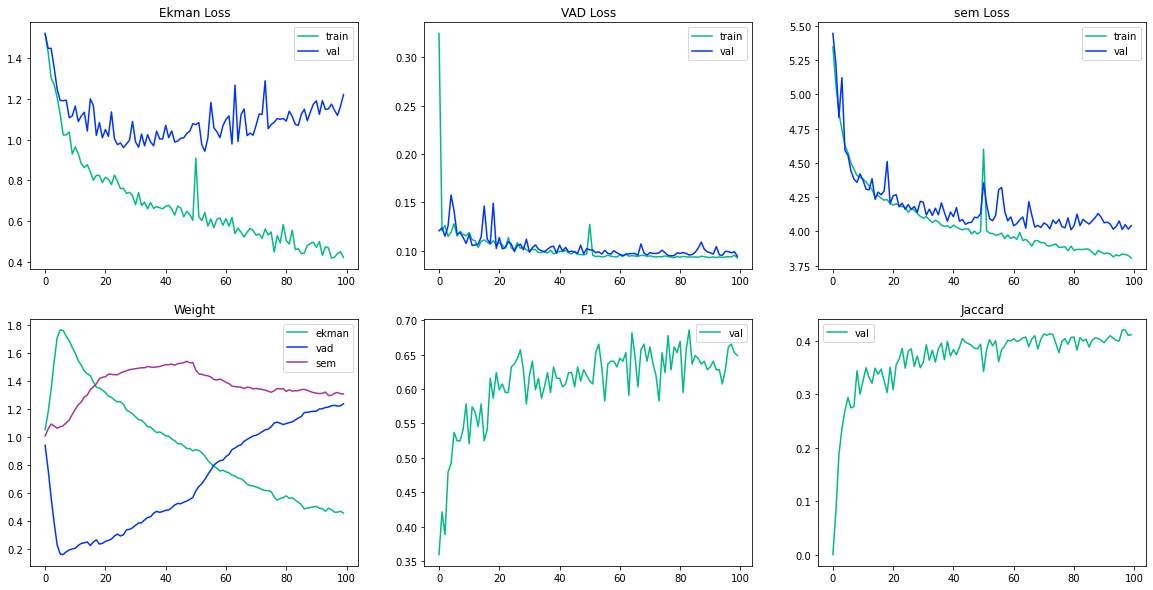

In [ ]:
exp4.plot_history()

### Test lower lr for weights

In [ ]:
config = {
    "dataset": "combined",
    "val_dataset": "combined",
    "gradNorm": True,
    "alpha": 2,
    "dropout": 0.5,
    'h_size': 256,
    'weight_decay': 1e-5,
}

exp5 = TrainingManager(dataloaders, config, wandb=False)

In [ ]:
exp5.evaluate()

TEST SET (combined)
Total Loss = 4.724
Ekman Loss = 0.495
VAD Loss = 0.093
sem Loss = 4.136
F1 = 0.8408
MSE = 0.0087
Jaccard = 0.4360
-----------------------
EVALUATING WITH BEST NET
TEST SET (combined)
Total Loss = 4.645
Ekman Loss = 0.567
VAD Loss = 0.092
sem Loss = 3.987
F1 = 0.8050
MSE = 0.0085
Jaccard = 0.4253


In [ ]:
exp5.train(epochs=50)

  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 1: train ekman_loss = 0.964, vad loss = 0.127, sem loss = 4.608
Epoch 1: val ekman loss = 1.017, vad loss = 0.099, sem loss = 4.208
Epoch 1: f1 = 0.632, jaccard = 0.334
Epoch 1: avg. loss_weights = [0.9478886127471924, 0.681990921497345, 1.3701205253601074], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 2: train ekman_loss = 0.697, vad loss = 0.095, sem loss = 4.025
Epoch 2: val ekman loss = 1.041, vad loss = 0.100, sem loss = 4.158
Epoch 2: f1 = 0.616, jaccard = 0.388
Epoch 2: avg. loss_weights = [0.9455700516700745, 0.6853061318397522, 1.369124412536621], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 3: train ekman_loss = 0.617, vad loss = 0.096, sem loss = 3.986
Epoch 3: val ekman loss = 1.053, vad loss = 0.100, sem loss = 4.068
Epoch 3: f1 = 0.616, jaccard = 0.392
Epoch 3: avg. loss_weights = [0.9387349486351013, 0.6902773380279541, 1.3709884881973267], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 4: train ekman_loss = 0.614, vad loss = 0.095, sem loss = 3.987
Epoch 4: val ekman loss = 1.014, vad loss = 0.101, sem loss = 4.056
Epoch 4: f1 = 0.632, jaccard = 0.380
Epoch 4: avg. loss_weights = [0.9302451610565186, 0.6965534090995789, 1.373201608657837], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 5: train ekman_loss = 0.595, vad loss = 0.095, sem loss = 3.962
Epoch 5: val ekman loss = 1.000, vad loss = 0.100, sem loss = 4.119
Epoch 5: f1 = 0.632, jaccard = 0.388
Epoch 5: avg. loss_weights = [0.9203954935073853, 0.7036005258560181, 1.3760040998458862], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 6: train ekman_loss = 0.631, vad loss = 0.095, sem loss = 3.988
Epoch 6: val ekman loss = 1.119, vad loss = 0.098, sem loss = 4.237
Epoch 6: f1 = 0.566, jaccard = 0.380
Epoch 6: avg. loss_weights = [0.9127257466316223, 0.710112988948822, 1.3771612644195557], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 7: train ekman_loss = 0.601, vad loss = 0.095, sem loss = 3.986
Epoch 7: val ekman loss = 1.027, vad loss = 0.110, sem loss = 4.142
Epoch 7: f1 = 0.628, jaccard = 0.380
Epoch 7: avg. loss_weights = [0.9025848507881165, 0.7175206542015076, 1.379894733428955], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 8: train ekman_loss = 0.610, vad loss = 0.094, sem loss = 3.953
Epoch 8: val ekman loss = 1.037, vad loss = 0.096, sem loss = 4.097
Epoch 8: f1 = 0.636, jaccard = 0.397
Epoch 8: avg. loss_weights = [0.8936537504196167, 0.7262923717498779, 1.3800536394119263], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 9: train ekman_loss = 0.634, vad loss = 0.094, sem loss = 3.944
Epoch 9: val ekman loss = 1.026, vad loss = 0.095, sem loss = 4.030
Epoch 9: f1 = 0.645, jaccard = 0.400
Epoch 9: avg. loss_weights = [0.8851498961448669, 0.7339839935302734, 1.3808660507202148], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 10: train ekman_loss = 0.582, vad loss = 0.093, sem loss = 3.967
Epoch 10: val ekman loss = 1.052, vad loss = 0.098, sem loss = 4.199
Epoch 10: f1 = 0.640, jaccard = 0.390
Epoch 10: avg. loss_weights = [0.8770999908447266, 0.7420308589935303, 1.3808698654174805], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 11: train ekman_loss = 0.609, vad loss = 0.094, sem loss = 3.972
Epoch 11: val ekman loss = 1.082, vad loss = 0.095, sem loss = 4.078
Epoch 11: f1 = 0.624, jaccard = 0.400
Epoch 11: avg. loss_weights = [0.8666849732398987, 0.7515619993209839, 1.3817527294158936], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 12: train ekman_loss = 0.595, vad loss = 0.094, sem loss = 3.942
Epoch 12: val ekman loss = 1.077, vad loss = 0.096, sem loss = 4.082
Epoch 12: f1 = 0.616, jaccard = 0.421
Epoch 12: avg. loss_weights = [0.8560147881507874, 0.761824905872345, 1.3821604251861572], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 13: train ekman_loss = 0.573, vad loss = 0.096, sem loss = 3.934
Epoch 13: val ekman loss = 1.036, vad loss = 0.099, sem loss = 4.037
Epoch 13: f1 = 0.661, jaccard = 0.384
Epoch 13: avg. loss_weights = [0.8458670973777771, 0.7717615365982056, 1.3823713064193726], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 14: train ekman_loss = 0.577, vad loss = 0.093, sem loss = 3.915
Epoch 14: val ekman loss = 1.015, vad loss = 0.098, sem loss = 4.114
Epoch 14: f1 = 0.678, jaccard = 0.400
Epoch 14: avg. loss_weights = [0.8358080387115479, 0.7813635468482971, 1.3828288316726685], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 15: train ekman_loss = 0.596, vad loss = 0.093, sem loss = 3.911
Epoch 15: val ekman loss = 1.112, vad loss = 0.098, sem loss = 4.213
Epoch 15: f1 = 0.612, jaccard = 0.389
Epoch 15: avg. loss_weights = [0.8256955146789551, 0.7909854054450989, 1.3833190202713013], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 16: train ekman_loss = 0.580, vad loss = 0.094, sem loss = 3.925
Epoch 16: val ekman loss = 1.138, vad loss = 0.099, sem loss = 4.303
Epoch 16: f1 = 0.624, jaccard = 0.374
Epoch 16: avg. loss_weights = [0.8163201808929443, 0.8010975122451782, 1.3825825452804565], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 17: train ekman_loss = 0.539, vad loss = 0.095, sem loss = 3.928
Epoch 17: val ekman loss = 1.138, vad loss = 0.101, sem loss = 4.296
Epoch 17: f1 = 0.603, jaccard = 0.370
Epoch 17: avg. loss_weights = [0.8062371611595154, 0.8114226460456848, 1.3823398351669312], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 18: train ekman_loss = 0.585, vad loss = 0.094, sem loss = 3.930
Epoch 18: val ekman loss = 1.105, vad loss = 0.099, sem loss = 4.060
Epoch 18: f1 = 0.657, jaccard = 0.385
Epoch 18: avg. loss_weights = [0.797294557094574, 0.8221403956413269, 1.3805644512176514], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 19: train ekman_loss = 0.592, vad loss = 0.097, sem loss = 3.945
Epoch 19: val ekman loss = 0.976, vad loss = 0.094, sem loss = 4.060
Epoch 19: f1 = 0.653, jaccard = 0.396
Epoch 19: avg. loss_weights = [0.7887457609176636, 0.8324581384658813, 1.378796935081482], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 20: train ekman_loss = 0.580, vad loss = 0.095, sem loss = 3.912
Epoch 20: val ekman loss = 1.044, vad loss = 0.096, sem loss = 4.131
Epoch 20: f1 = 0.624, jaccard = 0.387
Epoch 20: avg. loss_weights = [0.7788465023040771, 0.8428604602813721, 1.3782941102981567], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 21: train ekman_loss = 0.516, vad loss = 0.093, sem loss = 3.908
Epoch 21: val ekman loss = 1.060, vad loss = 0.096, sem loss = 4.061
Epoch 21: f1 = 0.607, jaccard = 0.400
Epoch 21: avg. loss_weights = [0.7696830034255981, 0.8521989583969116, 1.3781176805496216], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 22: train ekman_loss = 0.539, vad loss = 0.095, sem loss = 3.900
Epoch 22: val ekman loss = 1.029, vad loss = 0.096, sem loss = 4.154
Epoch 22: f1 = 0.645, jaccard = 0.403
Epoch 22: avg. loss_weights = [0.7594316601753235, 0.8624342679977417, 1.3781343698501587], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 23: train ekman_loss = 0.516, vad loss = 0.094, sem loss = 3.919
Epoch 23: val ekman loss = 1.063, vad loss = 0.113, sem loss = 4.079
Epoch 23: f1 = 0.669, jaccard = 0.399
Epoch 23: avg. loss_weights = [0.7498039603233337, 0.8719677329063416, 1.3782280683517456], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 24: train ekman_loss = 0.551, vad loss = 0.094, sem loss = 3.889
Epoch 24: val ekman loss = 1.164, vad loss = 0.098, sem loss = 4.110
Epoch 24: f1 = 0.612, jaccard = 0.388
Epoch 24: avg. loss_weights = [0.7394885420799255, 0.8815902471542358, 1.3789211511611938], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 25: train ekman_loss = 0.505, vad loss = 0.094, sem loss = 3.885
Epoch 25: val ekman loss = 1.234, vad loss = 0.098, sem loss = 4.141
Epoch 25: f1 = 0.591, jaccard = 0.384
Epoch 25: avg. loss_weights = [0.7302521467208862, 0.8907238245010376, 1.379023790359497], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 26: train ekman_loss = 0.546, vad loss = 0.095, sem loss = 3.910
Epoch 26: val ekman loss = 1.092, vad loss = 0.108, sem loss = 4.051
Epoch 26: f1 = 0.686, jaccard = 0.398
Epoch 26: avg. loss_weights = [0.721476137638092, 0.900490403175354, 1.3780336380004883], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 27: train ekman_loss = 0.519, vad loss = 0.093, sem loss = 3.876
Epoch 27: val ekman loss = 1.066, vad loss = 0.100, sem loss = 4.117
Epoch 27: f1 = 0.649, jaccard = 0.379
Epoch 27: avg. loss_weights = [0.7122147083282471, 0.9101859331130981, 1.3775994777679443], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 28: train ekman_loss = 0.561, vad loss = 0.094, sem loss = 3.885
Epoch 28: val ekman loss = 1.113, vad loss = 0.097, sem loss = 4.121
Epoch 28: f1 = 0.640, jaccard = 0.399
Epoch 28: avg. loss_weights = [0.7020166516304016, 0.9200986623764038, 1.3778847455978394], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 29: train ekman_loss = 0.508, vad loss = 0.094, sem loss = 3.894
Epoch 29: val ekman loss = 1.060, vad loss = 0.099, sem loss = 4.045
Epoch 29: f1 = 0.665, jaccard = 0.389
Epoch 29: avg. loss_weights = [0.694297730922699, 0.928693950176239, 1.377008318901062], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 30: train ekman_loss = 0.481, vad loss = 0.094, sem loss = 3.868
Epoch 30: val ekman loss = 1.078, vad loss = 0.105, sem loss = 4.027
Epoch 30: f1 = 0.649, jaccard = 0.421
Epoch 30: avg. loss_weights = [0.6848604679107666, 0.9382922053337097, 1.376847743988037], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 31: train ekman_loss = 0.496, vad loss = 0.093, sem loss = 3.878
Epoch 31: val ekman loss = 0.985, vad loss = 0.098, sem loss = 4.062
Epoch 31: f1 = 0.674, jaccard = 0.396
Epoch 31: avg. loss_weights = [0.6747936606407166, 0.9476227164268494, 1.3775840997695923], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 32: train ekman_loss = 0.506, vad loss = 0.094, sem loss = 3.882
Epoch 32: val ekman loss = 1.160, vad loss = 0.096, sem loss = 4.071
Epoch 32: f1 = 0.616, jaccard = 0.384
Epoch 32: avg. loss_weights = [0.6667798757553101, 0.9567508101463318, 1.3764691352844238], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 33: train ekman_loss = 0.520, vad loss = 0.093, sem loss = 3.870
Epoch 33: val ekman loss = 1.084, vad loss = 0.096, sem loss = 4.054
Epoch 33: f1 = 0.649, jaccard = 0.410
Epoch 33: avg. loss_weights = [0.6591368913650513, 0.9660559892654419, 1.3748068809509277], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 34: train ekman_loss = 0.561, vad loss = 0.094, sem loss = 3.855
Epoch 34: val ekman loss = 1.102, vad loss = 0.100, sem loss = 4.132
Epoch 34: f1 = 0.669, jaccard = 0.406
Epoch 34: avg. loss_weights = [0.6529218554496765, 0.9734441637992859, 1.3736337423324585], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 35: train ekman_loss = 0.454, vad loss = 0.094, sem loss = 3.855
Epoch 35: val ekman loss = 1.132, vad loss = 0.100, sem loss = 4.113
Epoch 35: f1 = 0.620, jaccard = 0.390
Epoch 35: avg. loss_weights = [0.6431763172149658, 0.9822640419006348, 1.3745603561401367], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 36: train ekman_loss = 0.484, vad loss = 0.094, sem loss = 3.857
Epoch 36: val ekman loss = 1.130, vad loss = 0.097, sem loss = 4.100
Epoch 36: f1 = 0.669, jaccard = 0.396
Epoch 36: avg. loss_weights = [0.6344768404960632, 0.9905659556388855, 1.3749573230743408], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 37: train ekman_loss = 0.442, vad loss = 0.094, sem loss = 3.849
Epoch 37: val ekman loss = 1.171, vad loss = 0.097, sem loss = 4.229
Epoch 37: f1 = 0.636, jaccard = 0.381
Epoch 37: avg. loss_weights = [0.625817060470581, 0.9993116855621338, 1.3748714923858643], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 38: train ekman_loss = 0.485, vad loss = 0.093, sem loss = 3.871
Epoch 38: val ekman loss = 1.137, vad loss = 0.094, sem loss = 4.041
Epoch 38: f1 = 0.616, jaccard = 0.408
Epoch 38: avg. loss_weights = [0.6170064210891724, 1.0082509517669678, 1.3747426271438599], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 39: train ekman_loss = 0.493, vad loss = 0.094, sem loss = 3.873
Epoch 39: val ekman loss = 1.236, vad loss = 0.097, sem loss = 4.127
Epoch 39: f1 = 0.636, jaccard = 0.400
Epoch 39: avg. loss_weights = [0.6114560961723328, 1.0156872272491455, 1.3728560209274292], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 40: train ekman_loss = 0.514, vad loss = 0.094, sem loss = 3.842
Epoch 40: val ekman loss = 1.066, vad loss = 0.095, sem loss = 4.058
Epoch 40: f1 = 0.661, jaccard = 0.417
Epoch 40: avg. loss_weights = [0.6046844720840454, 1.0246106386184692, 1.3707046508789062], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 41: train ekman_loss = 0.477, vad loss = 0.093, sem loss = 3.835
Epoch 41: val ekman loss = 1.157, vad loss = 0.099, sem loss = 4.069
Epoch 41: f1 = 0.628, jaccard = 0.407
Epoch 41: avg. loss_weights = [0.5980688333511353, 1.0333620309829712, 1.368569254875183], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 42: train ekman_loss = 0.449, vad loss = 0.093, sem loss = 3.835
Epoch 42: val ekman loss = 1.142, vad loss = 0.097, sem loss = 4.056
Epoch 42: f1 = 0.636, jaccard = 0.414
Epoch 42: avg. loss_weights = [0.5913666486740112, 1.0413422584533691, 1.3672912120819092], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 43: train ekman_loss = 0.466, vad loss = 0.094, sem loss = 3.840
Epoch 43: val ekman loss = 1.149, vad loss = 0.096, sem loss = 4.053
Epoch 43: f1 = 0.640, jaccard = 0.401
Epoch 43: avg. loss_weights = [0.5822029113769531, 1.0504815578460693, 1.3673158884048462], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 44: train ekman_loss = 0.421, vad loss = 0.094, sem loss = 3.821
Epoch 44: val ekman loss = 1.106, vad loss = 0.095, sem loss = 4.100
Epoch 44: f1 = 0.649, jaccard = 0.403
Epoch 44: avg. loss_weights = [0.5735432505607605, 1.0588263273239136, 1.3676310777664185], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 45: train ekman_loss = 0.483, vad loss = 0.093, sem loss = 3.839
Epoch 45: val ekman loss = 1.114, vad loss = 0.096, sem loss = 4.068
Epoch 45: f1 = 0.636, jaccard = 0.398
Epoch 45: avg. loss_weights = [0.5662204623222351, 1.066049575805664, 1.3677300214767456], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 46: train ekman_loss = 0.441, vad loss = 0.094, sem loss = 3.835
Epoch 46: val ekman loss = 1.109, vad loss = 0.095, sem loss = 4.021
Epoch 46: f1 = 0.661, jaccard = 0.419
Epoch 46: avg. loss_weights = [0.5591557621955872, 1.0738694667816162, 1.3669743537902832], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 47: train ekman_loss = 0.494, vad loss = 0.093, sem loss = 3.817
Epoch 47: val ekman loss = 1.106, vad loss = 0.097, sem loss = 4.085
Epoch 47: f1 = 0.645, jaccard = 0.402
Epoch 47: avg. loss_weights = [0.552869975566864, 1.0818629264831543, 1.3652667999267578], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 48: train ekman_loss = 0.468, vad loss = 0.093, sem loss = 3.839
Epoch 48: val ekman loss = 1.117, vad loss = 0.095, sem loss = 4.091
Epoch 48: f1 = 0.653, jaccard = 0.386
Epoch 48: avg. loss_weights = [0.547930121421814, 1.0888612270355225, 1.3632084131240845], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 49: train ekman_loss = 0.524, vad loss = 0.093, sem loss = 3.831
Epoch 49: val ekman loss = 1.160, vad loss = 0.096, sem loss = 4.099
Epoch 49: f1 = 0.612, jaccard = 0.399
Epoch 49: avg. loss_weights = [0.541427493095398, 1.0958898067474365, 1.362682819366455], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 50: train ekman_loss = 0.523, vad loss = 0.093, sem loss = 3.845
Epoch 50: val ekman loss = 1.137, vad loss = 0.095, sem loss = 4.183
Epoch 50: f1 = 0.624, jaccard = 0.402
Epoch 50: avg. loss_weights = [0.5372521877288818, 1.1024565696716309, 1.3602906465530396], tensor([1.7614, 0.8902, 7.8424], device='cuda:0')


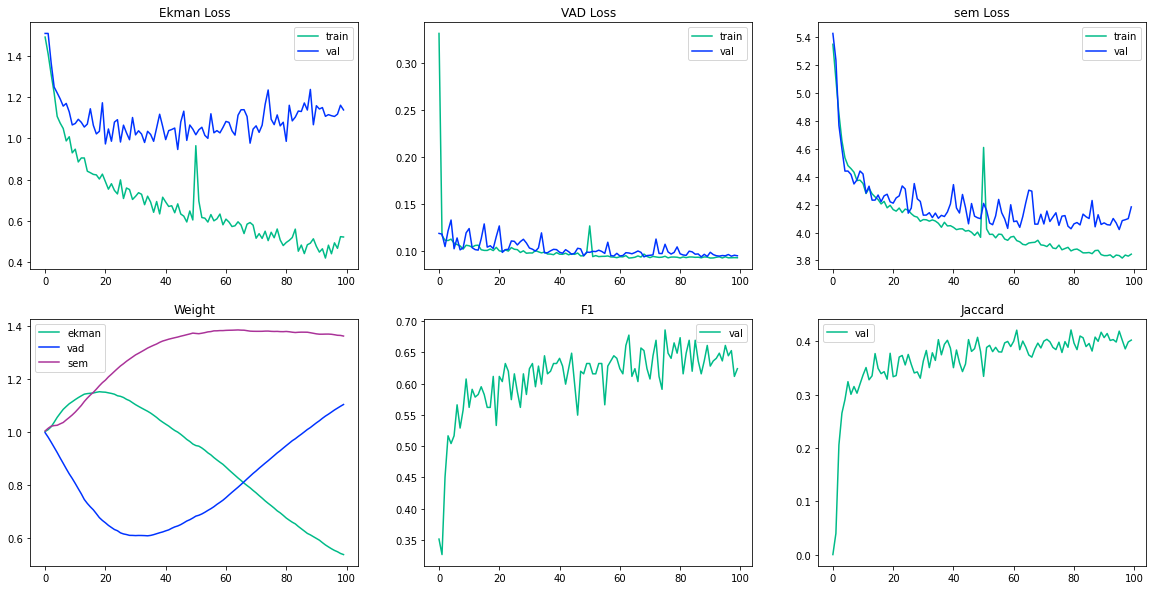

In [ ]:
exp5.plot_history()

### Test different lower lr for main updates

In [ ]:
# 1e-5
config = {
    "dataset": "combined",
    "val_dataset": "combined",
    "gradNorm": True,
    "alpha": 2,
    "dropout": 0.5,
    'h_size': 256,
    'weight_decay': 1e-5,
}

exp6 = TrainingManager(dataloaders, config, wandb=False)

In [ ]:
exp6.evaluate()

TEST SET (combined)
Total Loss = 10.262
Ekman Loss = 1.634
VAD Loss = 1.035
sem Loss = 7.593
F1 = 0.1306
MSE = 1.0711
Jaccard = 0.1897


In [ ]:
exp6.train(epochs=50)

  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 1: train ekman_loss = 1.577, vad loss = 0.618, sem loss = 6.699
Epoch 1: val ekman loss = 1.552, vad loss = 0.264, sem loss = 6.165
Epoch 1: f1 = 0.351, jaccard = 0.026
Epoch 1: avg. loss_weights = [1.0695855617523193, 0.9705824255943298, 0.9598322510719299], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 2: train ekman_loss = 1.478, vad loss = 0.167, sem loss = 5.639
Epoch 2: val ekman loss = 1.523, vad loss = 0.135, sem loss = 5.645
Epoch 2: f1 = 0.355, jaccard = 0.026
Epoch 2: avg. loss_weights = [1.1813474893569946, 0.8116644024848938, 1.0069886445999146], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 3: train ekman_loss = 1.444, vad loss = 0.128, sem loss = 5.307
Epoch 3: val ekman loss = 1.521, vad loss = 0.126, sem loss = 5.525
Epoch 3: f1 = 0.351, jaccard = 0.028
Epoch 3: avg. loss_weights = [1.2726253271102905, 0.6433079242706299, 1.0840660333633423], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 4: train ekman_loss = 1.452, vad loss = 0.124, sem loss = 5.240
Epoch 4: val ekman loss = 1.522, vad loss = 0.124, sem loss = 5.495
Epoch 4: f1 = 0.355, jaccard = 0.028
Epoch 4: avg. loss_weights = [1.3656259775161743, 0.47340962290763855, 1.1609644889831543], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 5: train ekman_loss = 1.438, vad loss = 0.122, sem loss = 5.218
Epoch 5: val ekman loss = 1.519, vad loss = 0.122, sem loss = 5.475
Epoch 5: f1 = 0.355, jaccard = 0.028
Epoch 5: avg. loss_weights = [1.4574424028396606, 0.29769212007522583, 1.2448655366897583], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 6: train ekman_loss = 1.434, vad loss = 0.122, sem loss = 5.197
Epoch 6: val ekman loss = 1.516, vad loss = 0.124, sem loss = 5.469
Epoch 6: f1 = 0.360, jaccard = 0.028
Epoch 6: avg. loss_weights = [1.537813663482666, 0.1283375769853592, 1.3338489532470703], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 7: train ekman_loss = 1.431, vad loss = 0.122, sem loss = 5.195
Epoch 7: val ekman loss = 1.512, vad loss = 0.124, sem loss = 5.461
Epoch 7: f1 = 0.360, jaccard = 0.028
Epoch 7: avg. loss_weights = [1.5592904090881348, 0.0640285536646843, 1.3766815662384033], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 8: train ekman_loss = 1.410, vad loss = 0.124, sem loss = 5.180
Epoch 8: val ekman loss = 1.516, vad loss = 0.124, sem loss = 5.448
Epoch 8: f1 = 0.360, jaccard = 0.028
Epoch 8: avg. loss_weights = [1.5536209344863892, 0.05626830831170082, 1.3901104927062988], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 9: train ekman_loss = 1.409, vad loss = 0.123, sem loss = 5.171
Epoch 9: val ekman loss = 1.508, vad loss = 0.124, sem loss = 5.449
Epoch 9: f1 = 0.355, jaccard = 0.026
Epoch 9: avg. loss_weights = [1.5293279886245728, 0.06459974497556686, 1.4060715436935425], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 10: train ekman_loss = 1.388, vad loss = 0.123, sem loss = 5.168
Epoch 10: val ekman loss = 1.508, vad loss = 0.123, sem loss = 5.451
Epoch 10: f1 = 0.360, jaccard = 0.026
Epoch 10: avg. loss_weights = [1.512195110321045, 0.06551562249660492, 1.4222882986068726], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 11: train ekman_loss = 1.417, vad loss = 0.123, sem loss = 5.161
Epoch 11: val ekman loss = 1.503, vad loss = 0.124, sem loss = 5.440
Epoch 11: f1 = 0.355, jaccard = 0.026
Epoch 11: avg. loss_weights = [1.4969265460968018, 0.06545853614807129, 1.4376144409179688], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 12: train ekman_loss = 1.425, vad loss = 0.124, sem loss = 5.161
Epoch 12: val ekman loss = 1.498, vad loss = 0.125, sem loss = 5.436
Epoch 12: f1 = 0.355, jaccard = 0.026
Epoch 12: avg. loss_weights = [1.5005820989608765, 0.059958867728710175, 1.439459204673767], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 13: train ekman_loss = 1.388, vad loss = 0.123, sem loss = 5.150
Epoch 13: val ekman loss = 1.500, vad loss = 0.124, sem loss = 5.434
Epoch 13: f1 = 0.355, jaccard = 0.026
Epoch 13: avg. loss_weights = [1.4972760677337646, 0.06913669407367706, 1.4335873126983643], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 14: train ekman_loss = 1.408, vad loss = 0.122, sem loss = 5.137
Epoch 14: val ekman loss = 1.498, vad loss = 0.123, sem loss = 5.422
Epoch 14: f1 = 0.355, jaccard = 0.026
Epoch 14: avg. loss_weights = [1.482763409614563, 0.07313904911279678, 1.444097876548767], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 15: train ekman_loss = 1.401, vad loss = 0.122, sem loss = 5.137
Epoch 15: val ekman loss = 1.496, vad loss = 0.123, sem loss = 5.421
Epoch 15: f1 = 0.360, jaccard = 0.026
Epoch 15: avg. loss_weights = [1.478514552116394, 0.07447361201047897, 1.447011947631836], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 16: train ekman_loss = 1.371, vad loss = 0.121, sem loss = 5.125
Epoch 16: val ekman loss = 1.498, vad loss = 0.122, sem loss = 5.418
Epoch 16: f1 = 0.368, jaccard = 0.026
Epoch 16: avg. loss_weights = [1.4693104028701782, 0.07066495716571808, 1.4600248336791992], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 17: train ekman_loss = 1.394, vad loss = 0.121, sem loss = 5.119
Epoch 17: val ekman loss = 1.489, vad loss = 0.122, sem loss = 5.411
Epoch 17: f1 = 0.368, jaccard = 0.026
Epoch 17: avg. loss_weights = [1.4604562520980835, 0.06610482931137085, 1.4734396934509277], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 18: train ekman_loss = 1.349, vad loss = 0.120, sem loss = 5.119
Epoch 18: val ekman loss = 1.487, vad loss = 0.121, sem loss = 5.398
Epoch 18: f1 = 0.364, jaccard = 0.026
Epoch 18: avg. loss_weights = [1.448927640914917, 0.06675790995359421, 1.48431396484375], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 19: train ekman_loss = 1.385, vad loss = 0.120, sem loss = 5.111
Epoch 19: val ekman loss = 1.486, vad loss = 0.120, sem loss = 5.401
Epoch 19: f1 = 0.364, jaccard = 0.026
Epoch 19: avg. loss_weights = [1.439927339553833, 0.07125194370746613, 1.4888203144073486], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 20: train ekman_loss = 1.371, vad loss = 0.119, sem loss = 5.107
Epoch 20: val ekman loss = 1.488, vad loss = 0.120, sem loss = 5.390
Epoch 20: f1 = 0.355, jaccard = 0.026
Epoch 20: avg. loss_weights = [1.4433567523956299, 0.07350894808769226, 1.483133316040039], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 21: train ekman_loss = 1.372, vad loss = 0.119, sem loss = 5.099
Epoch 21: val ekman loss = 1.481, vad loss = 0.119, sem loss = 5.382
Epoch 21: f1 = 0.368, jaccard = 0.026
Epoch 21: avg. loss_weights = [1.445023775100708, 0.06742961704730988, 1.4875456094741821], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 22: train ekman_loss = 1.377, vad loss = 0.118, sem loss = 5.099
Epoch 22: val ekman loss = 1.480, vad loss = 0.120, sem loss = 5.372
Epoch 22: f1 = 0.360, jaccard = 0.026
Epoch 22: avg. loss_weights = [1.4509706497192383, 0.06457223743200302, 1.4844577312469482], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 23: train ekman_loss = 1.355, vad loss = 0.118, sem loss = 5.088
Epoch 23: val ekman loss = 1.480, vad loss = 0.119, sem loss = 5.378
Epoch 23: f1 = 0.355, jaccard = 0.026
Epoch 23: avg. loss_weights = [1.4412075281143188, 0.06696920841932297, 1.4918229579925537], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 24: train ekman_loss = 1.359, vad loss = 0.118, sem loss = 5.079
Epoch 24: val ekman loss = 1.474, vad loss = 0.119, sem loss = 5.368
Epoch 24: f1 = 0.368, jaccard = 0.026
Epoch 24: avg. loss_weights = [1.4298282861709595, 0.06689351797103882, 1.5032789707183838], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 25: train ekman_loss = 1.362, vad loss = 0.117, sem loss = 5.076
Epoch 25: val ekman loss = 1.477, vad loss = 0.118, sem loss = 5.357
Epoch 25: f1 = 0.372, jaccard = 0.026
Epoch 25: avg. loss_weights = [1.4307661056518555, 0.06765931844711304, 1.501574993133545], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 26: train ekman_loss = 1.382, vad loss = 0.117, sem loss = 5.072
Epoch 26: val ekman loss = 1.473, vad loss = 0.118, sem loss = 5.358
Epoch 26: f1 = 0.351, jaccard = 0.026
Epoch 26: avg. loss_weights = [1.435706615447998, 0.07348544150590897, 1.4908086061477661], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 27: train ekman_loss = 1.360, vad loss = 0.116, sem loss = 5.059
Epoch 27: val ekman loss = 1.467, vad loss = 0.117, sem loss = 5.346
Epoch 27: f1 = 0.376, jaccard = 0.026
Epoch 27: avg. loss_weights = [1.440711498260498, 0.06996238231658936, 1.489326000213623], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 28: train ekman_loss = 1.349, vad loss = 0.116, sem loss = 5.054
Epoch 28: val ekman loss = 1.468, vad loss = 0.117, sem loss = 5.336
Epoch 28: f1 = 0.368, jaccard = 0.027
Epoch 28: avg. loss_weights = [1.4436877965927124, 0.07376639544963837, 1.482545256614685], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 29: train ekman_loss = 1.361, vad loss = 0.116, sem loss = 5.051
Epoch 29: val ekman loss = 1.469, vad loss = 0.116, sem loss = 5.326
Epoch 29: f1 = 0.368, jaccard = 0.028
Epoch 29: avg. loss_weights = [1.4541374444961548, 0.06642767786979675, 1.4794350862503052], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 30: train ekman_loss = 1.333, vad loss = 0.115, sem loss = 5.043
Epoch 30: val ekman loss = 1.464, vad loss = 0.116, sem loss = 5.322
Epoch 30: f1 = 0.380, jaccard = 0.028
Epoch 30: avg. loss_weights = [1.4528495073318481, 0.07087218016386032, 1.4762780666351318], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 31: train ekman_loss = 1.339, vad loss = 0.115, sem loss = 5.037
Epoch 31: val ekman loss = 1.463, vad loss = 0.115, sem loss = 5.315
Epoch 31: f1 = 0.376, jaccard = 0.029
Epoch 31: avg. loss_weights = [1.4499173164367676, 0.07182428240776062, 1.4782586097717285], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 32: train ekman_loss = 1.340, vad loss = 0.115, sem loss = 5.028
Epoch 32: val ekman loss = 1.456, vad loss = 0.116, sem loss = 5.316
Epoch 32: f1 = 0.376, jaccard = 0.030
Epoch 32: avg. loss_weights = [1.4566316604614258, 0.07049538195133209, 1.472872018814087], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 33: train ekman_loss = 1.346, vad loss = 0.114, sem loss = 5.020
Epoch 33: val ekman loss = 1.460, vad loss = 0.115, sem loss = 5.302
Epoch 33: f1 = 0.372, jaccard = 0.034
Epoch 33: avg. loss_weights = [1.465518593788147, 0.06716959178447723, 1.4673124551773071], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 34: train ekman_loss = 1.319, vad loss = 0.113, sem loss = 5.015
Epoch 34: val ekman loss = 1.454, vad loss = 0.114, sem loss = 5.305
Epoch 34: f1 = 0.372, jaccard = 0.034
Epoch 34: avg. loss_weights = [1.4539262056350708, 0.07296165078878403, 1.4731112718582153], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 35: train ekman_loss = 1.332, vad loss = 0.113, sem loss = 5.010
Epoch 35: val ekman loss = 1.457, vad loss = 0.114, sem loss = 5.289
Epoch 35: f1 = 0.376, jaccard = 0.035
Epoch 35: avg. loss_weights = [1.4472136497497559, 0.07198124378919601, 1.4808050394058228], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 36: train ekman_loss = 1.313, vad loss = 0.113, sem loss = 5.000
Epoch 36: val ekman loss = 1.445, vad loss = 0.114, sem loss = 5.302
Epoch 36: f1 = 0.397, jaccard = 0.044
Epoch 36: avg. loss_weights = [1.4412565231323242, 0.07152944058179855, 1.487214207649231], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 37: train ekman_loss = 1.290, vad loss = 0.113, sem loss = 4.991
Epoch 37: val ekman loss = 1.456, vad loss = 0.113, sem loss = 5.275
Epoch 37: f1 = 0.364, jaccard = 0.042
Epoch 37: avg. loss_weights = [1.4528800249099731, 0.06893185526132584, 1.4781887531280518], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 38: train ekman_loss = 1.319, vad loss = 0.113, sem loss = 4.988
Epoch 38: val ekman loss = 1.447, vad loss = 0.113, sem loss = 5.271
Epoch 38: f1 = 0.376, jaccard = 0.045
Epoch 38: avg. loss_weights = [1.4503014087677002, 0.0709647461771965, 1.4787347316741943], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 39: train ekman_loss = 1.314, vad loss = 0.112, sem loss = 4.975
Epoch 39: val ekman loss = 1.442, vad loss = 0.113, sem loss = 5.263
Epoch 39: f1 = 0.372, jaccard = 0.051
Epoch 39: avg. loss_weights = [1.4521404504776, 0.06703181564807892, 1.4808272123336792], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 40: train ekman_loss = 1.341, vad loss = 0.112, sem loss = 4.974
Epoch 40: val ekman loss = 1.437, vad loss = 0.113, sem loss = 5.256
Epoch 40: f1 = 0.376, jaccard = 0.053
Epoch 40: avg. loss_weights = [1.4450596570968628, 0.07094204425811768, 1.48399817943573], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 41: train ekman_loss = 1.306, vad loss = 0.112, sem loss = 4.963
Epoch 41: val ekman loss = 1.433, vad loss = 0.112, sem loss = 5.242
Epoch 41: f1 = 0.401, jaccard = 0.055
Epoch 41: avg. loss_weights = [1.4470878839492798, 0.06869823485612869, 1.484213948249817], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 42: train ekman_loss = 1.328, vad loss = 0.112, sem loss = 4.962
Epoch 42: val ekman loss = 1.432, vad loss = 0.112, sem loss = 5.233
Epoch 42: f1 = 0.384, jaccard = 0.062
Epoch 42: avg. loss_weights = [1.4459171295166016, 0.07325567305088043, 1.4808273315429688], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 43: train ekman_loss = 1.308, vad loss = 0.112, sem loss = 4.949
Epoch 43: val ekman loss = 1.434, vad loss = 0.112, sem loss = 5.223
Epoch 43: f1 = 0.397, jaccard = 0.067
Epoch 43: avg. loss_weights = [1.4490846395492554, 0.0746677815914154, 1.476246953010559], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 44: train ekman_loss = 1.318, vad loss = 0.111, sem loss = 4.939
Epoch 44: val ekman loss = 1.425, vad loss = 0.112, sem loss = 5.238
Epoch 44: f1 = 0.393, jaccard = 0.072
Epoch 44: avg. loss_weights = [1.4654295444488525, 0.06586253643035889, 1.4687082767486572], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 45: train ekman_loss = 1.304, vad loss = 0.111, sem loss = 4.935
Epoch 45: val ekman loss = 1.431, vad loss = 0.111, sem loss = 5.218
Epoch 45: f1 = 0.397, jaccard = 0.068
Epoch 45: avg. loss_weights = [1.4683972597122192, 0.07336065173149109, 1.458242654800415], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 46: train ekman_loss = 1.313, vad loss = 0.111, sem loss = 4.928
Epoch 46: val ekman loss = 1.425, vad loss = 0.111, sem loss = 5.207
Epoch 46: f1 = 0.421, jaccard = 0.074
Epoch 46: avg. loss_weights = [1.471329689025879, 0.07081878930330276, 1.4578520059585571], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 47: train ekman_loss = 1.280, vad loss = 0.111, sem loss = 4.920
Epoch 47: val ekman loss = 1.426, vad loss = 0.111, sem loss = 5.203
Epoch 47: f1 = 0.384, jaccard = 0.076
Epoch 47: avg. loss_weights = [1.4646803140640259, 0.07318137586116791, 1.462138295173645], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 48: train ekman_loss = 1.255, vad loss = 0.110, sem loss = 4.908
Epoch 48: val ekman loss = 1.421, vad loss = 0.111, sem loss = 5.194
Epoch 48: f1 = 0.397, jaccard = 0.085
Epoch 48: avg. loss_weights = [1.46003258228302, 0.07195936143398285, 1.4680085182189941], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 49: train ekman_loss = 1.303, vad loss = 0.111, sem loss = 4.903
Epoch 49: val ekman loss = 1.418, vad loss = 0.110, sem loss = 5.192
Epoch 49: f1 = 0.401, jaccard = 0.091
Epoch 49: avg. loss_weights = [1.4670145511627197, 0.06877829134464264, 1.464206576347351], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 50: train ekman_loss = 1.277, vad loss = 0.110, sem loss = 4.900
Epoch 50: val ekman loss = 1.414, vad loss = 0.110, sem loss = 5.173
Epoch 50: f1 = 0.397, jaccard = 0.092
Epoch 50: avg. loss_weights = [1.46165931224823, 0.07386144250631332, 1.464479684829712], tensor([1.6840, 1.0461, 7.7284], device='cuda:0')


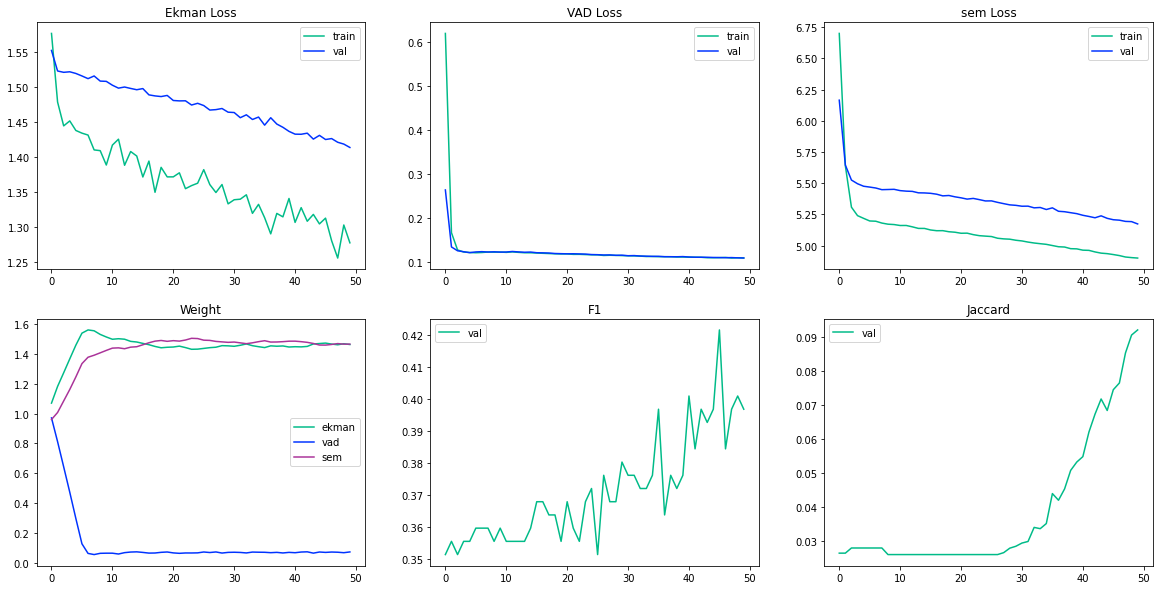

In [ ]:
exp6.plot_history()

### Test 1e-4 lr

In [ ]:
# 1e-4
config = {
    "dataset": "combined",
    "val_dataset": "combined",
    "gradNorm": True,
    "alpha": 2,
    "dropout": 0.5,
    'h_size': 256,
    'weight_decay': 1e-5,
}

exp7 = TrainingManager(dataloaders, config, wandb=False)

In [ ]:
exp7.evaluate()

TEST SET (combined)
Total Loss = 4.826
Ekman Loss = 0.719
VAD Loss = 0.090
sem Loss = 4.017
F1 = 0.7531
MSE = 0.0081
Jaccard = 0.4203
-----------------------
EVALUATING WITH BEST NET
TEST SET (combined)
Total Loss = 4.800
Ekman Loss = 0.693
VAD Loss = 0.090
sem Loss = 4.017
F1 = 0.7621
MSE = 0.0081
Jaccard = 0.4150


In [ ]:
exp7.train(epochs=50)

  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 1: train ekman_loss = 0.874, vad loss = 0.342, sem loss = 4.387
Epoch 1: val ekman loss = 1.019, vad loss = 0.117, sem loss = 4.229
Epoch 1: f1 = 0.599, jaccard = 0.342
Epoch 1: avg. loss_weights = [1.1770825386047363, 0.33282309770584106, 1.4900940656661987], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 2: train ekman_loss = 0.812, vad loss = 0.100, sem loss = 4.141
Epoch 2: val ekman loss = 1.000, vad loss = 0.099, sem loss = 4.219
Epoch 2: f1 = 0.628, jaccard = 0.350
Epoch 2: avg. loss_weights = [1.1500089168548584, 0.40099599957466125, 1.448994517326355], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 3: train ekman_loss = 0.794, vad loss = 0.096, sem loss = 4.130
Epoch 3: val ekman loss = 1.012, vad loss = 0.098, sem loss = 4.192
Epoch 3: f1 = 0.607, jaccard = 0.357
Epoch 3: avg. loss_weights = [1.18861722946167, 0.32886436581611633, 1.4825185537338257], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 4: train ekman_loss = 0.775, vad loss = 0.094, sem loss = 4.131
Epoch 4: val ekman loss = 0.971, vad loss = 0.098, sem loss = 4.174
Epoch 4: f1 = 0.649, jaccard = 0.345
Epoch 4: avg. loss_weights = [1.1909688711166382, 0.2958963215351105, 1.513135552406311], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 5: train ekman_loss = 0.761, vad loss = 0.095, sem loss = 4.119
Epoch 5: val ekman loss = 0.985, vad loss = 0.097, sem loss = 4.188
Epoch 5: f1 = 0.616, jaccard = 0.369
Epoch 5: avg. loss_weights = [1.2039848566055298, 0.271067351102829, 1.524947166442871], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 6: train ekman_loss = 0.781, vad loss = 0.093, sem loss = 4.122
Epoch 6: val ekman loss = 0.969, vad loss = 0.096, sem loss = 4.190
Epoch 6: f1 = 0.632, jaccard = 0.354
Epoch 6: avg. loss_weights = [1.1955500841140747, 0.2652852237224579, 1.5391654968261719], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 7: train ekman_loss = 0.751, vad loss = 0.093, sem loss = 4.114
Epoch 7: val ekman loss = 1.015, vad loss = 0.097, sem loss = 4.170
Epoch 7: f1 = 0.595, jaccard = 0.370
Epoch 7: avg. loss_weights = [1.2029889822006226, 0.25188499689102173, 1.5451256036758423], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 8: train ekman_loss = 0.739, vad loss = 0.093, sem loss = 4.110
Epoch 8: val ekman loss = 0.984, vad loss = 0.097, sem loss = 4.175
Epoch 8: f1 = 0.636, jaccard = 0.366
Epoch 8: avg. loss_weights = [1.1922048330307007, 0.25986018776893616, 1.5479352474212646], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 9: train ekman_loss = 0.758, vad loss = 0.093, sem loss = 4.092
Epoch 9: val ekman loss = 0.976, vad loss = 0.095, sem loss = 4.171
Epoch 9: f1 = 0.628, jaccard = 0.356
Epoch 9: avg. loss_weights = [1.1666182279586792, 0.2730366885662079, 1.56034517288208], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 10: train ekman_loss = 0.743, vad loss = 0.093, sem loss = 4.108
Epoch 10: val ekman loss = 0.968, vad loss = 0.095, sem loss = 4.167
Epoch 10: f1 = 0.636, jaccard = 0.359
Epoch 10: avg. loss_weights = [1.155002474784851, 0.27030715346336365, 1.5746906995773315], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 11: train ekman_loss = 0.743, vad loss = 0.092, sem loss = 4.083
Epoch 11: val ekman loss = 0.975, vad loss = 0.095, sem loss = 4.233
Epoch 11: f1 = 0.640, jaccard = 0.360
Epoch 11: avg. loss_weights = [1.1629064083099365, 0.2621660530567169, 1.5749270915985107], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 12: train ekman_loss = 0.741, vad loss = 0.093, sem loss = 4.086
Epoch 12: val ekman loss = 1.020, vad loss = 0.096, sem loss = 4.196
Epoch 12: f1 = 0.603, jaccard = 0.361
Epoch 12: avg. loss_weights = [1.1610223054885864, 0.26179906725883484, 1.5771782398223877], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 13: train ekman_loss = 0.736, vad loss = 0.092, sem loss = 4.080
Epoch 13: val ekman loss = 1.011, vad loss = 0.096, sem loss = 4.239
Epoch 13: f1 = 0.624, jaccard = 0.341
Epoch 13: avg. loss_weights = [1.1488062143325806, 0.271192342042923, 1.5800011157989502], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 14: train ekman_loss = 0.717, vad loss = 0.092, sem loss = 4.083
Epoch 14: val ekman loss = 0.957, vad loss = 0.095, sem loss = 4.175
Epoch 14: f1 = 0.628, jaccard = 0.346
Epoch 14: avg. loss_weights = [1.1315507888793945, 0.29211685061454773, 1.5763319730758667], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 15: train ekman_loss = 0.714, vad loss = 0.091, sem loss = 4.073
Epoch 15: val ekman loss = 0.971, vad loss = 0.097, sem loss = 4.137
Epoch 15: f1 = 0.624, jaccard = 0.369
Epoch 15: avg. loss_weights = [1.1048389673233032, 0.3117242455482483, 1.5834368467330933], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 16: train ekman_loss = 0.716, vad loss = 0.091, sem loss = 4.064
Epoch 16: val ekman loss = 0.973, vad loss = 0.097, sem loss = 4.144
Epoch 16: f1 = 0.649, jaccard = 0.366
Epoch 16: avg. loss_weights = [1.1018891334533691, 0.29973605275154114, 1.5983742475509644], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 17: train ekman_loss = 0.714, vad loss = 0.091, sem loss = 4.062
Epoch 17: val ekman loss = 0.963, vad loss = 0.101, sem loss = 4.134
Epoch 17: f1 = 0.624, jaccard = 0.378
Epoch 17: avg. loss_weights = [1.1213358640670776, 0.2737736105918884, 1.6048907041549683], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 18: train ekman_loss = 0.708, vad loss = 0.091, sem loss = 4.062
Epoch 18: val ekman loss = 0.980, vad loss = 0.095, sem loss = 4.192
Epoch 18: f1 = 0.624, jaccard = 0.352
Epoch 18: avg. loss_weights = [1.1175382137298584, 0.2804719805717468, 1.601989507675171], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 19: train ekman_loss = 0.723, vad loss = 0.092, sem loss = 4.069
Epoch 19: val ekman loss = 0.970, vad loss = 0.098, sem loss = 4.178
Epoch 19: f1 = 0.632, jaccard = 0.372
Epoch 19: avg. loss_weights = [1.1082653999328613, 0.2790512144565582, 1.6126837730407715], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 20: train ekman_loss = 0.728, vad loss = 0.091, sem loss = 4.062
Epoch 20: val ekman loss = 0.937, vad loss = 0.096, sem loss = 4.155
Epoch 20: f1 = 0.657, jaccard = 0.353
Epoch 20: avg. loss_weights = [1.1034891605377197, 0.28222447633743286, 1.6142860651016235], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 21: train ekman_loss = 0.693, vad loss = 0.091, sem loss = 4.046
Epoch 21: val ekman loss = 0.945, vad loss = 0.095, sem loss = 4.115
Epoch 21: f1 = 0.649, jaccard = 0.372
Epoch 21: avg. loss_weights = [1.08585524559021, 0.2947850823402405, 1.6193592548370361], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 22: train ekman_loss = 0.718, vad loss = 0.091, sem loss = 4.044
Epoch 22: val ekman loss = 0.976, vad loss = 0.097, sem loss = 4.182
Epoch 22: f1 = 0.653, jaccard = 0.379
Epoch 22: avg. loss_weights = [1.0918267965316772, 0.29622894525527954, 1.6119441986083984], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 23: train ekman_loss = 0.730, vad loss = 0.091, sem loss = 4.060
Epoch 23: val ekman loss = 0.945, vad loss = 0.096, sem loss = 4.142
Epoch 23: f1 = 0.657, jaccard = 0.364
Epoch 23: avg. loss_weights = [1.1031811237335205, 0.28599318861961365, 1.6108264923095703], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 24: train ekman_loss = 0.736, vad loss = 0.091, sem loss = 4.040
Epoch 24: val ekman loss = 0.988, vad loss = 0.094, sem loss = 4.194
Epoch 24: f1 = 0.645, jaccard = 0.366
Epoch 24: avg. loss_weights = [1.1115056276321411, 0.2845141589641571, 1.6039804220199585], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 25: train ekman_loss = 0.686, vad loss = 0.090, sem loss = 4.029
Epoch 25: val ekman loss = 0.965, vad loss = 0.096, sem loss = 4.119
Epoch 25: f1 = 0.636, jaccard = 0.368
Epoch 25: avg. loss_weights = [1.097690463066101, 0.2979680597782135, 1.6043401956558228], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 26: train ekman_loss = 0.676, vad loss = 0.091, sem loss = 4.031
Epoch 26: val ekman loss = 0.956, vad loss = 0.095, sem loss = 4.098
Epoch 26: f1 = 0.636, jaccard = 0.379
Epoch 26: avg. loss_weights = [1.0914674997329712, 0.29182764887809753, 1.6167057752609253], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 27: train ekman_loss = 0.717, vad loss = 0.091, sem loss = 4.038
Epoch 27: val ekman loss = 0.953, vad loss = 0.095, sem loss = 4.105
Epoch 27: f1 = 0.645, jaccard = 0.381
Epoch 27: avg. loss_weights = [1.0754022598266602, 0.30344846844673157, 1.6211490631103516], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 28: train ekman_loss = 0.678, vad loss = 0.090, sem loss = 4.025
Epoch 28: val ekman loss = 0.943, vad loss = 0.095, sem loss = 4.113
Epoch 28: f1 = 0.653, jaccard = 0.381
Epoch 28: avg. loss_weights = [1.0626660585403442, 0.3054109811782837, 1.6319234371185303], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 29: train ekman_loss = 0.689, vad loss = 0.090, sem loss = 4.021
Epoch 29: val ekman loss = 0.939, vad loss = 0.096, sem loss = 4.120
Epoch 29: f1 = 0.645, jaccard = 0.374
Epoch 29: avg. loss_weights = [1.051562786102295, 0.30622708797454834, 1.6422107219696045], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 30: train ekman_loss = 0.669, vad loss = 0.091, sem loss = 4.016
Epoch 30: val ekman loss = 0.950, vad loss = 0.094, sem loss = 4.161
Epoch 30: f1 = 0.636, jaccard = 0.377
Epoch 30: avg. loss_weights = [1.054755687713623, 0.2939450740814209, 1.6512993574142456], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 31: train ekman_loss = 0.692, vad loss = 0.090, sem loss = 4.015
Epoch 31: val ekman loss = 0.951, vad loss = 0.095, sem loss = 4.095
Epoch 31: f1 = 0.616, jaccard = 0.398
Epoch 31: avg. loss_weights = [1.0587098598480225, 0.3019912540912628, 1.6392992734909058], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 32: train ekman_loss = 0.685, vad loss = 0.090, sem loss = 4.014
Epoch 32: val ekman loss = 0.947, vad loss = 0.094, sem loss = 4.095
Epoch 32: f1 = 0.661, jaccard = 0.377
Epoch 32: avg. loss_weights = [1.0565556287765503, 0.3046141266822815, 1.6388298273086548], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 33: train ekman_loss = 0.667, vad loss = 0.090, sem loss = 4.000
Epoch 33: val ekman loss = 0.951, vad loss = 0.093, sem loss = 4.093
Epoch 33: f1 = 0.640, jaccard = 0.381
Epoch 33: avg. loss_weights = [1.0506093502044678, 0.3150906264781952, 1.6342997550964355], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 34: train ekman_loss = 0.678, vad loss = 0.090, sem loss = 4.006
Epoch 34: val ekman loss = 0.938, vad loss = 0.093, sem loss = 4.110
Epoch 34: f1 = 0.657, jaccard = 0.382
Epoch 34: avg. loss_weights = [1.0266879796981812, 0.3283456265926361, 1.6449673175811768], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 35: train ekman_loss = 0.658, vad loss = 0.090, sem loss = 3.996
Epoch 35: val ekman loss = 0.952, vad loss = 0.094, sem loss = 4.150
Epoch 35: f1 = 0.636, jaccard = 0.366
Epoch 35: avg. loss_weights = [1.009545922279358, 0.339277982711792, 1.651175856590271], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 36: train ekman_loss = 0.669, vad loss = 0.090, sem loss = 4.002
Epoch 36: val ekman loss = 0.963, vad loss = 0.095, sem loss = 4.123
Epoch 36: f1 = 0.636, jaccard = 0.372
Epoch 36: avg. loss_weights = [1.025028109550476, 0.3186344802379608, 1.6563372611999512], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 37: train ekman_loss = 0.654, vad loss = 0.090, sem loss = 3.992
Epoch 37: val ekman loss = 0.944, vad loss = 0.094, sem loss = 4.099
Epoch 37: f1 = 0.645, jaccard = 0.389
Epoch 37: avg. loss_weights = [1.0203298330307007, 0.3222316801548004, 1.6574379205703735], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 38: train ekman_loss = 0.653, vad loss = 0.090, sem loss = 3.988
Epoch 38: val ekman loss = 0.930, vad loss = 0.094, sem loss = 4.078
Epoch 38: f1 = 0.645, jaccard = 0.391
Epoch 38: avg. loss_weights = [1.0039480924606323, 0.32132530212402344, 1.6747263669967651], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 39: train ekman_loss = 0.648, vad loss = 0.090, sem loss = 3.993
Epoch 39: val ekman loss = 0.969, vad loss = 0.094, sem loss = 4.109
Epoch 39: f1 = 0.632, jaccard = 0.373
Epoch 39: avg. loss_weights = [0.9981563687324524, 0.3278169631958008, 1.6740261316299438], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 40: train ekman_loss = 0.651, vad loss = 0.091, sem loss = 3.987
Epoch 40: val ekman loss = 0.968, vad loss = 0.094, sem loss = 4.095
Epoch 40: f1 = 0.607, jaccard = 0.376
Epoch 40: avg. loss_weights = [0.9915791153907776, 0.33077472448349, 1.6776463985443115], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 41: train ekman_loss = 0.675, vad loss = 0.090, sem loss = 3.989
Epoch 41: val ekman loss = 0.926, vad loss = 0.093, sem loss = 4.080
Epoch 41: f1 = 0.632, jaccard = 0.374
Epoch 41: avg. loss_weights = [0.994830310344696, 0.3282817006111145, 1.6768884658813477], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 42: train ekman_loss = 0.627, vad loss = 0.089, sem loss = 3.971
Epoch 42: val ekman loss = 0.935, vad loss = 0.094, sem loss = 4.095
Epoch 42: f1 = 0.645, jaccard = 0.395
Epoch 42: avg. loss_weights = [0.9866385459899902, 0.3388938307762146, 1.6744670867919922], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 43: train ekman_loss = 0.630, vad loss = 0.090, sem loss = 3.975
Epoch 43: val ekman loss = 0.944, vad loss = 0.095, sem loss = 4.083
Epoch 43: f1 = 0.632, jaccard = 0.370
Epoch 43: avg. loss_weights = [0.9705191850662231, 0.3539595305919647, 1.675520658493042], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 44: train ekman_loss = 0.661, vad loss = 0.090, sem loss = 3.980
Epoch 44: val ekman loss = 0.923, vad loss = 0.095, sem loss = 4.074
Epoch 44: f1 = 0.636, jaccard = 0.385
Epoch 44: avg. loss_weights = [0.9823073744773865, 0.3441619575023651, 1.673531174659729], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 45: train ekman_loss = 0.649, vad loss = 0.092, sem loss = 3.971
Epoch 45: val ekman loss = 0.926, vad loss = 0.094, sem loss = 4.102
Epoch 45: f1 = 0.628, jaccard = 0.371
Epoch 45: avg. loss_weights = [0.9980959892272949, 0.3029485046863556, 1.6989552974700928], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 46: train ekman_loss = 0.660, vad loss = 0.093, sem loss = 3.961
Epoch 46: val ekman loss = 0.984, vad loss = 0.094, sem loss = 4.092
Epoch 46: f1 = 0.616, jaccard = 0.390
Epoch 46: avg. loss_weights = [1.0056581497192383, 0.26503029465675354, 1.7293117046356201], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 47: train ekman_loss = 0.655, vad loss = 0.090, sem loss = 3.965
Epoch 47: val ekman loss = 0.941, vad loss = 0.094, sem loss = 4.070
Epoch 47: f1 = 0.645, jaccard = 0.387
Epoch 47: avg. loss_weights = [0.9785212278366089, 0.3076208233833313, 1.7138577699661255], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 48: train ekman_loss = 0.644, vad loss = 0.089, sem loss = 3.962
Epoch 48: val ekman loss = 0.934, vad loss = 0.094, sem loss = 4.061
Epoch 48: f1 = 0.657, jaccard = 0.384
Epoch 48: avg. loss_weights = [0.98283851146698, 0.32288679480552673, 1.6942739486694336], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 49: train ekman_loss = 0.626, vad loss = 0.089, sem loss = 3.948
Epoch 49: val ekman loss = 0.965, vad loss = 0.094, sem loss = 4.073
Epoch 49: f1 = 0.624, jaccard = 0.380
Epoch 49: avg. loss_weights = [0.9724276065826416, 0.343742698431015, 1.683829426765442], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 50: train ekman_loss = 0.615, vad loss = 0.090, sem loss = 3.950
Epoch 50: val ekman loss = 1.007, vad loss = 0.094, sem loss = 4.072
Epoch 50: f1 = 0.628, jaccard = 0.393
Epoch 50: avg. loss_weights = [0.9691435694694519, 0.3452208638191223, 1.6856364011764526], tensor([1.5959, 0.9976, 7.6281], device='cuda:0')


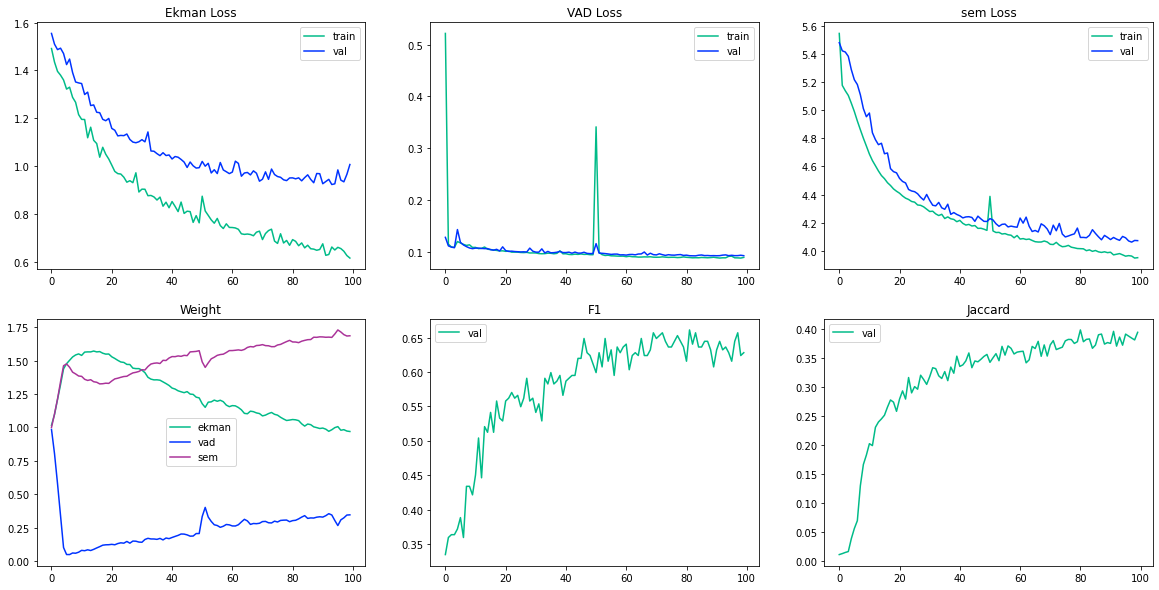

In [ ]:
exp7.plot_history()

### Test 3e-4 lr

In [ ]:
# 1e-4
config = {
    "dataset": "combined",
    "val_dataset": "combined",
    "gradNorm": True,
    "alpha": 2,
    "dropout": 0.5,
    'h_size': 256,
    'weight_decay': 1e-5,
    'lr': 3e-4,
}

exp8 = TrainingManager(dataloaders, config, wandb=False)

In [ ]:
exp8.evaluate()

TEST SET (combined)
Total Loss = 4.630
Ekman Loss = 0.589
VAD Loss = 0.091
sem Loss = 3.950
F1 = 0.7853
MSE = 0.0082
Jaccard = 0.4373
-----------------------
EVALUATING WITH BEST NET
TEST SET (combined)
Total Loss = 4.678
Ekman Loss = 0.619
VAD Loss = 0.094
sem Loss = 3.964
F1 = 0.7639
MSE = 0.0089
Jaccard = 0.4323


In [ ]:
exp8.train(epochs=50)

  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 1: train ekman_loss = 0.790, vad loss = 0.225, sem loss = 4.353
Epoch 1: val ekman loss = 1.007, vad loss = 0.130, sem loss = 4.113
Epoch 1: f1 = 0.607, jaccard = 0.360
Epoch 1: avg. loss_weights = [1.0362119674682617, 0.4005793333053589, 1.5632082223892212], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 2: train ekman_loss = 0.678, vad loss = 0.106, sem loss = 4.008
Epoch 2: val ekman loss = 0.974, vad loss = 0.103, sem loss = 4.089
Epoch 2: f1 = 0.649, jaccard = 0.380
Epoch 2: avg. loss_weights = [1.001965045928955, 0.46657732129096985, 1.531457543373108], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 3: train ekman_loss = 0.670, vad loss = 0.098, sem loss = 3.994
Epoch 3: val ekman loss = 0.927, vad loss = 0.101, sem loss = 4.077
Epoch 3: f1 = 0.657, jaccard = 0.379
Epoch 3: avg. loss_weights = [1.0105866193771362, 0.41339877247810364, 1.5760152339935303], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 4: train ekman_loss = 0.648, vad loss = 0.097, sem loss = 3.991
Epoch 4: val ekman loss = 0.960, vad loss = 0.102, sem loss = 4.180
Epoch 4: f1 = 0.636, jaccard = 0.365
Epoch 4: avg. loss_weights = [1.0039970874786377, 0.4034894108772278, 1.5925135612487793], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 5: train ekman_loss = 0.652, vad loss = 0.097, sem loss = 3.991
Epoch 5: val ekman loss = 0.942, vad loss = 0.097, sem loss = 4.163
Epoch 5: f1 = 0.636, jaccard = 0.386
Epoch 5: avg. loss_weights = [1.0047211647033691, 0.38293027877807617, 1.6123487949371338], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 6: train ekman_loss = 0.643, vad loss = 0.096, sem loss = 3.970
Epoch 6: val ekman loss = 0.946, vad loss = 0.101, sem loss = 4.060
Epoch 6: f1 = 0.628, jaccard = 0.402
Epoch 6: avg. loss_weights = [0.995118260383606, 0.37636837363243103, 1.628514051437378], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 7: train ekman_loss = 0.645, vad loss = 0.095, sem loss = 3.974
Epoch 7: val ekman loss = 0.997, vad loss = 0.100, sem loss = 4.066
Epoch 7: f1 = 0.616, jaccard = 0.390
Epoch 7: avg. loss_weights = [1.0050017833709717, 0.3538270890712738, 1.6411713361740112], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 8: train ekman_loss = 0.644, vad loss = 0.095, sem loss = 3.975
Epoch 8: val ekman loss = 1.001, vad loss = 0.097, sem loss = 4.165
Epoch 8: f1 = 0.636, jaccard = 0.387
Epoch 8: avg. loss_weights = [0.990641713142395, 0.3639879524707794, 1.6453701257705688], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 9: train ekman_loss = 0.643, vad loss = 0.095, sem loss = 3.973
Epoch 9: val ekman loss = 0.961, vad loss = 0.104, sem loss = 4.144
Epoch 9: f1 = 0.632, jaccard = 0.374
Epoch 9: avg. loss_weights = [0.9829144477844238, 0.37275129556655884, 1.644333839416504], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 10: train ekman_loss = 0.622, vad loss = 0.095, sem loss = 3.963
Epoch 10: val ekman loss = 1.095, vad loss = 0.100, sem loss = 4.306
Epoch 10: f1 = 0.624, jaccard = 0.371
Epoch 10: avg. loss_weights = [0.9696415066719055, 0.3827724754810333, 1.6475856304168701], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 11: train ekman_loss = 0.633, vad loss = 0.093, sem loss = 3.952
Epoch 11: val ekman loss = 0.946, vad loss = 0.096, sem loss = 4.142
Epoch 11: f1 = 0.645, jaccard = 0.364
Epoch 11: avg. loss_weights = [0.956047773361206, 0.39646926522254944, 1.647483229637146], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 12: train ekman_loss = 0.623, vad loss = 0.094, sem loss = 3.961
Epoch 12: val ekman loss = 1.062, vad loss = 0.097, sem loss = 4.079
Epoch 12: f1 = 0.599, jaccard = 0.399
Epoch 12: avg. loss_weights = [0.9671950936317444, 0.4078522324562073, 1.6249531507492065], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 13: train ekman_loss = 0.617, vad loss = 0.095, sem loss = 3.956
Epoch 13: val ekman loss = 0.982, vad loss = 0.100, sem loss = 4.100
Epoch 13: f1 = 0.620, jaccard = 0.392
Epoch 13: avg. loss_weights = [0.9637660384178162, 0.4049558639526367, 1.631277084350586], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 14: train ekman_loss = 0.620, vad loss = 0.093, sem loss = 3.959
Epoch 14: val ekman loss = 0.976, vad loss = 0.103, sem loss = 4.082
Epoch 14: f1 = 0.669, jaccard = 0.399
Epoch 14: avg. loss_weights = [0.9508099555969238, 0.40773066878318787, 1.6414583921432495], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 15: train ekman_loss = 0.618, vad loss = 0.093, sem loss = 3.949
Epoch 15: val ekman loss = 0.938, vad loss = 0.101, sem loss = 4.072
Epoch 15: f1 = 0.645, jaccard = 0.406
Epoch 15: avg. loss_weights = [0.935122549533844, 0.42117393016815186, 1.643703579902649], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 16: train ekman_loss = 0.606, vad loss = 0.094, sem loss = 3.944
Epoch 16: val ekman loss = 0.998, vad loss = 0.110, sem loss = 4.055
Epoch 16: f1 = 0.661, jaccard = 0.389
Epoch 16: avg. loss_weights = [0.9274613261222839, 0.4306120276451111, 1.6419265270233154], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 17: train ekman_loss = 0.601, vad loss = 0.094, sem loss = 3.931
Epoch 17: val ekman loss = 0.933, vad loss = 0.100, sem loss = 4.042
Epoch 17: f1 = 0.661, jaccard = 0.392
Epoch 17: avg. loss_weights = [0.9188912510871887, 0.43811747431755066, 1.642991065979004], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 18: train ekman_loss = 0.619, vad loss = 0.096, sem loss = 3.961
Epoch 18: val ekman loss = 0.999, vad loss = 0.102, sem loss = 4.127
Epoch 18: f1 = 0.624, jaccard = 0.394
Epoch 18: avg. loss_weights = [0.9213393330574036, 0.4122234284877777, 1.6664376258850098], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 19: train ekman_loss = 0.606, vad loss = 0.094, sem loss = 3.936
Epoch 19: val ekman loss = 0.986, vad loss = 0.097, sem loss = 4.060
Epoch 19: f1 = 0.636, jaccard = 0.386
Epoch 19: avg. loss_weights = [0.931425154209137, 0.40306439995765686, 1.665510892868042], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 20: train ekman_loss = 0.602, vad loss = 0.093, sem loss = 3.924
Epoch 20: val ekman loss = 1.022, vad loss = 0.096, sem loss = 4.050
Epoch 20: f1 = 0.607, jaccard = 0.405
Epoch 20: avg. loss_weights = [0.911870539188385, 0.4307127594947815, 1.6574162244796753], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 21: train ekman_loss = 0.588, vad loss = 0.093, sem loss = 3.926
Epoch 21: val ekman loss = 1.006, vad loss = 0.099, sem loss = 4.028
Epoch 21: f1 = 0.624, jaccard = 0.392
Epoch 21: avg. loss_weights = [0.9003979563713074, 0.4523375332355499, 1.6472645998001099], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 22: train ekman_loss = 0.590, vad loss = 0.094, sem loss = 3.913
Epoch 22: val ekman loss = 1.017, vad loss = 0.095, sem loss = 4.020
Epoch 22: f1 = 0.620, jaccard = 0.404
Epoch 22: avg. loss_weights = [0.8978928923606873, 0.44220930337905884, 1.659896969795227], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 23: train ekman_loss = 0.568, vad loss = 0.093, sem loss = 3.898
Epoch 23: val ekman loss = 1.047, vad loss = 0.100, sem loss = 4.023
Epoch 23: f1 = 0.591, jaccard = 0.400
Epoch 23: avg. loss_weights = [0.8860005736351013, 0.4408606290817261, 1.6731388568878174], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 24: train ekman_loss = 0.574, vad loss = 0.093, sem loss = 3.903
Epoch 24: val ekman loss = 0.960, vad loss = 0.097, sem loss = 4.009
Epoch 24: f1 = 0.665, jaccard = 0.403
Epoch 24: avg. loss_weights = [0.8799824714660645, 0.42901670932769775, 1.6910004615783691], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 25: train ekman_loss = 0.580, vad loss = 0.092, sem loss = 3.897
Epoch 25: val ekman loss = 0.979, vad loss = 0.097, sem loss = 4.032
Epoch 25: f1 = 0.636, jaccard = 0.417
Epoch 25: avg. loss_weights = [0.870472252368927, 0.44794535636901855, 1.6815828084945679], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 26: train ekman_loss = 0.565, vad loss = 0.094, sem loss = 3.896
Epoch 26: val ekman loss = 0.995, vad loss = 0.096, sem loss = 4.041
Epoch 26: f1 = 0.632, jaccard = 0.389
Epoch 26: avg. loss_weights = [0.871515154838562, 0.4411507248878479, 1.6873339414596558], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 27: train ekman_loss = 0.563, vad loss = 0.093, sem loss = 3.887
Epoch 27: val ekman loss = 0.994, vad loss = 0.098, sem loss = 4.099
Epoch 27: f1 = 0.645, jaccard = 0.397
Epoch 27: avg. loss_weights = [0.8475648760795593, 0.438109815120697, 1.7143257856369019], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 28: train ekman_loss = 0.563, vad loss = 0.093, sem loss = 3.893
Epoch 28: val ekman loss = 0.958, vad loss = 0.101, sem loss = 4.009
Epoch 28: f1 = 0.661, jaccard = 0.403
Epoch 28: avg. loss_weights = [0.8421404361724854, 0.44952937960624695, 1.7083300352096558], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 29: train ekman_loss = 0.571, vad loss = 0.092, sem loss = 3.880
Epoch 29: val ekman loss = 0.981, vad loss = 0.097, sem loss = 4.025
Epoch 29: f1 = 0.616, jaccard = 0.406
Epoch 29: avg. loss_weights = [0.8598944544792175, 0.4315367341041565, 1.708569049835205], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 30: train ekman_loss = 0.568, vad loss = 0.091, sem loss = 3.878
Epoch 30: val ekman loss = 0.988, vad loss = 0.095, sem loss = 4.115
Epoch 30: f1 = 0.616, jaccard = 0.391
Epoch 30: avg. loss_weights = [0.8542218804359436, 0.4378066062927246, 1.7079715728759766], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 31: train ekman_loss = 0.585, vad loss = 0.092, sem loss = 3.880
Epoch 31: val ekman loss = 0.986, vad loss = 0.095, sem loss = 4.010
Epoch 31: f1 = 0.653, jaccard = 0.397
Epoch 31: avg. loss_weights = [0.8664150238037109, 0.4540432393550873, 1.6795425415039062], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 32: train ekman_loss = 0.556, vad loss = 0.092, sem loss = 3.870
Epoch 32: val ekman loss = 0.975, vad loss = 0.100, sem loss = 4.039
Epoch 32: f1 = 0.624, jaccard = 0.405
Epoch 32: avg. loss_weights = [0.8757222890853882, 0.4634343683719635, 1.6608424186706543], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 33: train ekman_loss = 0.558, vad loss = 0.092, sem loss = 3.872
Epoch 33: val ekman loss = 0.988, vad loss = 0.099, sem loss = 4.019
Epoch 33: f1 = 0.669, jaccard = 0.410
Epoch 33: avg. loss_weights = [0.8644776344299316, 0.4666600525379181, 1.668862223625183], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 34: train ekman_loss = 0.537, vad loss = 0.091, sem loss = 3.863
Epoch 34: val ekman loss = 0.978, vad loss = 0.095, sem loss = 4.048
Epoch 34: f1 = 0.632, jaccard = 0.402
Epoch 34: avg. loss_weights = [0.84244704246521, 0.4650576114654541, 1.692495346069336], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 35: train ekman_loss = 0.524, vad loss = 0.092, sem loss = 3.868
Epoch 35: val ekman loss = 0.945, vad loss = 0.098, sem loss = 4.121
Epoch 35: f1 = 0.636, jaccard = 0.401
Epoch 35: avg. loss_weights = [0.8339571952819824, 0.4585350453853607, 1.7075090408325195], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 36: train ekman_loss = 0.546, vad loss = 0.092, sem loss = 3.860
Epoch 36: val ekman loss = 1.014, vad loss = 0.098, sem loss = 4.060
Epoch 36: f1 = 0.661, jaccard = 0.396
Epoch 36: avg. loss_weights = [0.8183483481407166, 0.4555119276046753, 1.7261399030685425], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 37: train ekman_loss = 0.549, vad loss = 0.091, sem loss = 3.846
Epoch 37: val ekman loss = 0.986, vad loss = 0.098, sem loss = 4.062
Epoch 37: f1 = 0.628, jaccard = 0.397
Epoch 37: avg. loss_weights = [0.8172560930252075, 0.468843549489975, 1.713900089263916], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 38: train ekman_loss = 0.542, vad loss = 0.091, sem loss = 3.852
Epoch 38: val ekman loss = 1.047, vad loss = 0.094, sem loss = 4.060
Epoch 38: f1 = 0.632, jaccard = 0.404
Epoch 38: avg. loss_weights = [0.8098260164260864, 0.4841085374355316, 1.7060658931732178], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 39: train ekman_loss = 0.533, vad loss = 0.092, sem loss = 3.835
Epoch 39: val ekman loss = 0.948, vad loss = 0.096, sem loss = 4.033
Epoch 39: f1 = 0.678, jaccard = 0.425
Epoch 39: avg. loss_weights = [0.8138349652290344, 0.4588544964790344, 1.7273106575012207], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 40: train ekman_loss = 0.537, vad loss = 0.093, sem loss = 3.854
Epoch 40: val ekman loss = 0.976, vad loss = 0.095, sem loss = 4.016
Epoch 40: f1 = 0.649, jaccard = 0.406
Epoch 40: avg. loss_weights = [0.805223286151886, 0.4470008313655853, 1.7477760314941406], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 41: train ekman_loss = 0.548, vad loss = 0.093, sem loss = 3.863
Epoch 41: val ekman loss = 0.987, vad loss = 0.096, sem loss = 4.036
Epoch 41: f1 = 0.674, jaccard = 0.411
Epoch 41: avg. loss_weights = [0.8151092529296875, 0.44280174374580383, 1.7420895099639893], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 42: train ekman_loss = 0.521, vad loss = 0.092, sem loss = 3.838
Epoch 42: val ekman loss = 1.003, vad loss = 0.094, sem loss = 4.008
Epoch 42: f1 = 0.645, jaccard = 0.421
Epoch 42: avg. loss_weights = [0.8208422064781189, 0.45138493180274963, 1.7277734279632568], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 43: train ekman_loss = 0.519, vad loss = 0.091, sem loss = 3.820
Epoch 43: val ekman loss = 1.020, vad loss = 0.096, sem loss = 4.130
Epoch 43: f1 = 0.620, jaccard = 0.376
Epoch 43: avg. loss_weights = [0.802946925163269, 0.47439950704574585, 1.722653865814209], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 44: train ekman_loss = 0.512, vad loss = 0.092, sem loss = 3.816
Epoch 44: val ekman loss = 1.029, vad loss = 0.096, sem loss = 4.019
Epoch 44: f1 = 0.636, jaccard = 0.415
Epoch 44: avg. loss_weights = [0.791103184223175, 0.48207876086235046, 1.7268182039260864], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 45: train ekman_loss = 0.533, vad loss = 0.092, sem loss = 3.828
Epoch 45: val ekman loss = 0.994, vad loss = 0.095, sem loss = 4.050
Epoch 45: f1 = 0.636, jaccard = 0.393
Epoch 45: avg. loss_weights = [0.7961147427558899, 0.4574284255504608, 1.7464566230773926], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 46: train ekman_loss = 0.531, vad loss = 0.092, sem loss = 3.826
Epoch 46: val ekman loss = 1.022, vad loss = 0.095, sem loss = 4.045
Epoch 46: f1 = 0.636, jaccard = 0.400
Epoch 46: avg. loss_weights = [0.7995074987411499, 0.45098844170570374, 1.7495050430297852], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 47: train ekman_loss = 0.506, vad loss = 0.092, sem loss = 3.823
Epoch 47: val ekman loss = 1.048, vad loss = 0.097, sem loss = 4.007
Epoch 47: f1 = 0.620, jaccard = 0.408
Epoch 47: avg. loss_weights = [0.7884175777435303, 0.4713599383831024, 1.7402222156524658], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 48: train ekman_loss = 0.527, vad loss = 0.091, sem loss = 3.809
Epoch 48: val ekman loss = 0.982, vad loss = 0.094, sem loss = 4.039
Epoch 48: f1 = 0.653, jaccard = 0.405
Epoch 48: avg. loss_weights = [0.7986274361610413, 0.47914695739746094, 1.7222251892089844], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 49: train ekman_loss = 0.502, vad loss = 0.092, sem loss = 3.796
Epoch 49: val ekman loss = 1.035, vad loss = 0.095, sem loss = 4.024
Epoch 49: f1 = 0.612, jaccard = 0.408
Epoch 49: avg. loss_weights = [0.7849845290184021, 0.49527910351753235, 1.7197356224060059], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 50: train ekman_loss = 0.482, vad loss = 0.092, sem loss = 3.794
Epoch 50: val ekman loss = 1.062, vad loss = 0.095, sem loss = 4.011
Epoch 50: f1 = 0.616, jaccard = 0.408
Epoch 50: avg. loss_weights = [0.777241587638855, 0.5056412816047668, 1.7171177864074707], tensor([1.5388, 1.0576, 7.6030], device='cuda:0')


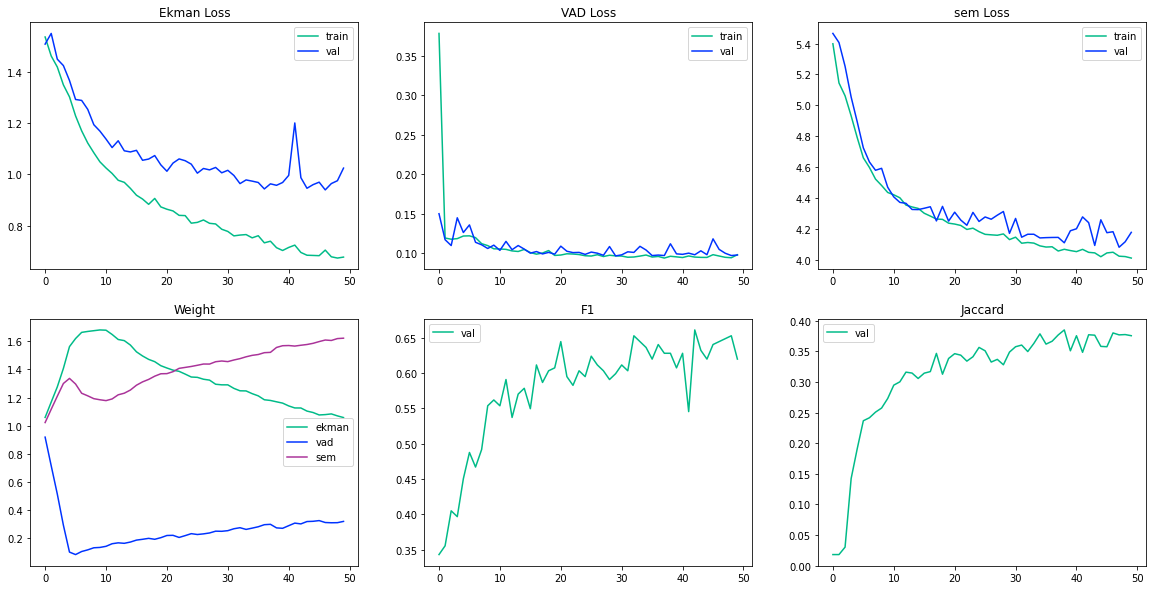

In [ ]:
exp8.plot_history()

### Test 5e-4 lr

In [ ]:
# 5e-4
config = {
    "dataset": "combined",
    "val_dataset": "combined",
    "gradNorm": True,
    "alpha": 2,
    "dropout": 0.5,
    'h_size': 256,
    'weight_decay': 1e-5,
    'lr': 5e-4,
}

exp9 = TrainingManager(dataloaders, config, wandb=False)

In [ ]:
exp9.evaluate()

TEST SET (combined)
Total Loss = 4.559
Ekman Loss = 0.480
VAD Loss = 0.094
sem Loss = 3.984
F1 = 0.8462
MSE = 0.0089
Jaccard = 0.4467
-----------------------
EVALUATING WITH BEST NET
TEST SET (combined)
Total Loss = 4.591
Ekman Loss = 0.560
VAD Loss = 0.092
sem Loss = 3.939
F1 = 0.7961
MSE = 0.0085
Jaccard = 0.4341


In [ ]:
exp9.train(epochs=50)

  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 1: train ekman_loss = 0.847, vad loss = 0.215, sem loss = 4.410
Epoch 1: val ekman loss = 1.038, vad loss = 0.124, sem loss = 4.168
Epoch 1: f1 = 0.612, jaccard = 0.372
Epoch 1: avg. loss_weights = [0.9324489831924438, 0.4813039302825928, 1.586246371269226], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 2: train ekman_loss = 0.651, vad loss = 0.107, sem loss = 3.969
Epoch 2: val ekman loss = 1.019, vad loss = 0.103, sem loss = 4.049
Epoch 2: f1 = 0.632, jaccard = 0.396
Epoch 2: avg. loss_weights = [0.9294334053993225, 0.5409584641456604, 1.5296080112457275], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 3: train ekman_loss = 0.632, vad loss = 0.103, sem loss = 3.954
Epoch 3: val ekman loss = 0.959, vad loss = 0.102, sem loss = 4.177
Epoch 3: f1 = 0.657, jaccard = 0.376
Epoch 3: avg. loss_weights = [0.9283881187438965, 0.49926698207855225, 1.5723448991775513], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 4: train ekman_loss = 0.623, vad loss = 0.098, sem loss = 3.934
Epoch 4: val ekman loss = 0.976, vad loss = 0.100, sem loss = 4.059
Epoch 4: f1 = 0.624, jaccard = 0.388
Epoch 4: avg. loss_weights = [0.9157739281654358, 0.4932020306587219, 1.5910241603851318], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 5: train ekman_loss = 0.627, vad loss = 0.096, sem loss = 3.946
Epoch 5: val ekman loss = 0.981, vad loss = 0.103, sem loss = 4.169
Epoch 5: f1 = 0.657, jaccard = 0.388
Epoch 5: avg. loss_weights = [0.900185227394104, 0.4867573082447052, 1.6130577325820923], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 6: train ekman_loss = 0.598, vad loss = 0.097, sem loss = 3.946
Epoch 6: val ekman loss = 0.952, vad loss = 0.108, sem loss = 4.059
Epoch 6: f1 = 0.653, jaccard = 0.403
Epoch 6: avg. loss_weights = [0.8954689502716064, 0.4796172082424164, 1.6249141693115234], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 7: train ekman_loss = 0.607, vad loss = 0.095, sem loss = 3.926
Epoch 7: val ekman loss = 0.964, vad loss = 0.098, sem loss = 4.144
Epoch 7: f1 = 0.632, jaccard = 0.379
Epoch 7: avg. loss_weights = [0.8679635524749756, 0.4951106309890747, 1.6369253396987915], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 8: train ekman_loss = 0.600, vad loss = 0.095, sem loss = 3.928
Epoch 8: val ekman loss = 1.011, vad loss = 0.101, sem loss = 4.129
Epoch 8: f1 = 0.628, jaccard = 0.364
Epoch 8: avg. loss_weights = [0.8542759418487549, 0.5016083121299744, 1.6441160440444946], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 9: train ekman_loss = 0.595, vad loss = 0.095, sem loss = 3.921
Epoch 9: val ekman loss = 1.210, vad loss = 0.098, sem loss = 4.181
Epoch 9: f1 = 0.583, jaccard = 0.392
Epoch 9: avg. loss_weights = [0.8323017358779907, 0.49556830525398254, 1.67212975025177], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 10: train ekman_loss = 0.608, vad loss = 0.095, sem loss = 3.925
Epoch 10: val ekman loss = 0.993, vad loss = 0.096, sem loss = 4.042
Epoch 10: f1 = 0.620, jaccard = 0.407
Epoch 10: avg. loss_weights = [0.837291955947876, 0.4847363829612732, 1.677971363067627], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 11: train ekman_loss = 0.600, vad loss = 0.096, sem loss = 3.921
Epoch 11: val ekman loss = 1.032, vad loss = 0.101, sem loss = 4.089
Epoch 11: f1 = 0.661, jaccard = 0.387
Epoch 11: avg. loss_weights = [0.8480833768844604, 0.4834013879299164, 1.6685154438018799], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 12: train ekman_loss = 0.593, vad loss = 0.096, sem loss = 3.908
Epoch 12: val ekman loss = 0.997, vad loss = 0.100, sem loss = 4.044
Epoch 12: f1 = 0.640, jaccard = 0.405
Epoch 12: avg. loss_weights = [0.8401193618774414, 0.5016853213310242, 1.6581952571868896], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 13: train ekman_loss = 0.599, vad loss = 0.095, sem loss = 3.902
Epoch 13: val ekman loss = 1.116, vad loss = 0.099, sem loss = 4.152
Epoch 13: f1 = 0.603, jaccard = 0.383
Epoch 13: avg. loss_weights = [0.8326538801193237, 0.5124073028564453, 1.6549394130706787], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 14: train ekman_loss = 0.585, vad loss = 0.095, sem loss = 3.893
Epoch 14: val ekman loss = 0.989, vad loss = 0.098, sem loss = 4.043
Epoch 14: f1 = 0.653, jaccard = 0.396
Epoch 14: avg. loss_weights = [0.8385102152824402, 0.5055794715881348, 1.655909538269043], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 15: train ekman_loss = 0.575, vad loss = 0.095, sem loss = 3.898
Epoch 15: val ekman loss = 1.037, vad loss = 0.098, sem loss = 4.186
Epoch 15: f1 = 0.665, jaccard = 0.386
Epoch 15: avg. loss_weights = [0.8307415246963501, 0.5033491253852844, 1.6659092903137207], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 16: train ekman_loss = 0.570, vad loss = 0.096, sem loss = 3.887
Epoch 16: val ekman loss = 1.054, vad loss = 0.103, sem loss = 4.041
Epoch 16: f1 = 0.665, jaccard = 0.385
Epoch 16: avg. loss_weights = [0.8186658620834351, 0.5119125843048096, 1.6694211959838867], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 17: train ekman_loss = 0.598, vad loss = 0.096, sem loss = 3.882
Epoch 17: val ekman loss = 0.979, vad loss = 0.096, sem loss = 4.052
Epoch 17: f1 = 0.628, jaccard = 0.393
Epoch 17: avg. loss_weights = [0.809684693813324, 0.5181378126144409, 1.6721765995025635], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 18: train ekman_loss = 0.548, vad loss = 0.094, sem loss = 3.884
Epoch 18: val ekman loss = 0.993, vad loss = 0.097, sem loss = 4.061
Epoch 18: f1 = 0.620, jaccard = 0.397
Epoch 18: avg. loss_weights = [0.8147886395454407, 0.522029459476471, 1.6631819009780884], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 19: train ekman_loss = 0.578, vad loss = 0.096, sem loss = 3.877
Epoch 19: val ekman loss = 1.006, vad loss = 0.108, sem loss = 4.093
Epoch 19: f1 = 0.636, jaccard = 0.396
Epoch 19: avg. loss_weights = [0.7974231243133545, 0.5109517574310303, 1.6916252374649048], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 20: train ekman_loss = 0.573, vad loss = 0.095, sem loss = 3.885
Epoch 20: val ekman loss = 0.956, vad loss = 0.099, sem loss = 4.031
Epoch 20: f1 = 0.665, jaccard = 0.408
Epoch 20: avg. loss_weights = [0.7960371971130371, 0.5163396000862122, 1.687622308731079], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 21: train ekman_loss = 0.546, vad loss = 0.094, sem loss = 3.864
Epoch 21: val ekman loss = 0.990, vad loss = 0.098, sem loss = 4.078
Epoch 21: f1 = 0.636, jaccard = 0.397
Epoch 21: avg. loss_weights = [0.7774011492729187, 0.5312878489494324, 1.6913113594055176], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 22: train ekman_loss = 0.540, vad loss = 0.094, sem loss = 3.879
Epoch 22: val ekman loss = 1.052, vad loss = 0.100, sem loss = 4.049
Epoch 22: f1 = 0.640, jaccard = 0.401
Epoch 22: avg. loss_weights = [0.7563059329986572, 0.5450595021247864, 1.698635220527649], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 23: train ekman_loss = 0.541, vad loss = 0.094, sem loss = 3.852
Epoch 23: val ekman loss = 0.964, vad loss = 0.095, sem loss = 4.023
Epoch 23: f1 = 0.649, jaccard = 0.400
Epoch 23: avg. loss_weights = [0.7682889103889465, 0.5282629132270813, 1.7034480571746826], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 24: train ekman_loss = 0.543, vad loss = 0.094, sem loss = 3.847
Epoch 24: val ekman loss = 1.027, vad loss = 0.098, sem loss = 4.045
Epoch 24: f1 = 0.624, jaccard = 0.417
Epoch 24: avg. loss_weights = [0.7493289709091187, 0.5327799916267395, 1.7178899049758911], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 25: train ekman_loss = 0.518, vad loss = 0.095, sem loss = 3.854
Epoch 25: val ekman loss = 1.065, vad loss = 0.105, sem loss = 4.050
Epoch 25: f1 = 0.640, jaccard = 0.411
Epoch 25: avg. loss_weights = [0.7385039329528809, 0.5480926632881165, 1.7134034633636475], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 26: train ekman_loss = 0.539, vad loss = 0.094, sem loss = 3.843
Epoch 26: val ekman loss = 1.038, vad loss = 0.096, sem loss = 4.013
Epoch 26: f1 = 0.661, jaccard = 0.413
Epoch 26: avg. loss_weights = [0.7287387251853943, 0.5580302476882935, 1.7132314443588257], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 27: train ekman_loss = 0.530, vad loss = 0.094, sem loss = 3.850
Epoch 27: val ekman loss = 0.997, vad loss = 0.096, sem loss = 4.064
Epoch 27: f1 = 0.665, jaccard = 0.414
Epoch 27: avg. loss_weights = [0.7232112884521484, 0.5683428645133972, 1.7084459066390991], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 28: train ekman_loss = 0.513, vad loss = 0.094, sem loss = 3.828
Epoch 28: val ekman loss = 1.082, vad loss = 0.097, sem loss = 4.098
Epoch 28: f1 = 0.628, jaccard = 0.400
Epoch 28: avg. loss_weights = [0.7296514511108398, 0.5532175302505493, 1.7171310186386108], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 29: train ekman_loss = 0.568, vad loss = 0.096, sem loss = 3.876
Epoch 29: val ekman loss = 1.083, vad loss = 0.097, sem loss = 4.067
Epoch 29: f1 = 0.616, jaccard = 0.399
Epoch 29: avg. loss_weights = [0.7359534502029419, 0.5504568815231323, 1.713589072227478], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 30: train ekman_loss = 0.517, vad loss = 0.095, sem loss = 3.849
Epoch 30: val ekman loss = 1.047, vad loss = 0.098, sem loss = 4.027
Epoch 30: f1 = 0.624, jaccard = 0.407
Epoch 30: avg. loss_weights = [0.7304619550704956, 0.544909656047821, 1.7246283292770386], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 31: train ekman_loss = 0.528, vad loss = 0.093, sem loss = 3.806
Epoch 31: val ekman loss = 1.012, vad loss = 0.097, sem loss = 4.035
Epoch 31: f1 = 0.653, jaccard = 0.410
Epoch 31: avg. loss_weights = [0.7187333106994629, 0.5593326687812805, 1.7219340801239014], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 32: train ekman_loss = 0.533, vad loss = 0.094, sem loss = 3.818
Epoch 32: val ekman loss = 1.036, vad loss = 0.101, sem loss = 4.074
Epoch 32: f1 = 0.632, jaccard = 0.405
Epoch 32: avg. loss_weights = [0.7102148532867432, 0.571256160736084, 1.7185295820236206], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 33: train ekman_loss = 0.499, vad loss = 0.094, sem loss = 3.818
Epoch 33: val ekman loss = 1.083, vad loss = 0.099, sem loss = 4.061
Epoch 33: f1 = 0.620, jaccard = 0.409
Epoch 33: avg. loss_weights = [0.6880496740341187, 0.5894792079925537, 1.7224706411361694], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 34: train ekman_loss = 0.511, vad loss = 0.094, sem loss = 3.799
Epoch 34: val ekman loss = 1.030, vad loss = 0.100, sem loss = 4.017
Epoch 34: f1 = 0.669, jaccard = 0.404
Epoch 34: avg. loss_weights = [0.6720847487449646, 0.6031392812728882, 1.724776029586792], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 35: train ekman_loss = 0.500, vad loss = 0.095, sem loss = 3.817
Epoch 35: val ekman loss = 1.055, vad loss = 0.101, sem loss = 4.036
Epoch 35: f1 = 0.636, jaccard = 0.398
Epoch 35: avg. loss_weights = [0.672389030456543, 0.6080378890037537, 1.7195733785629272], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 36: train ekman_loss = 0.511, vad loss = 0.093, sem loss = 3.798
Epoch 36: val ekman loss = 1.075, vad loss = 0.099, sem loss = 4.026
Epoch 36: f1 = 0.649, jaccard = 0.403
Epoch 36: avg. loss_weights = [0.6771515607833862, 0.6271075010299683, 1.6957404613494873], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 37: train ekman_loss = 0.508, vad loss = 0.095, sem loss = 3.798
Epoch 37: val ekman loss = 1.061, vad loss = 0.096, sem loss = 4.018
Epoch 37: f1 = 0.665, jaccard = 0.412
Epoch 37: avg. loss_weights = [0.6660633087158203, 0.6373304724693298, 1.696606159210205], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 38: train ekman_loss = 0.494, vad loss = 0.094, sem loss = 3.792
Epoch 38: val ekman loss = 1.028, vad loss = 0.098, sem loss = 4.008
Epoch 38: f1 = 0.669, jaccard = 0.415
Epoch 38: avg. loss_weights = [0.6580734848976135, 0.6340761780738831, 1.7078512907028198], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 39: train ekman_loss = 0.489, vad loss = 0.095, sem loss = 3.803
Epoch 39: val ekman loss = 1.051, vad loss = 0.096, sem loss = 4.106
Epoch 39: f1 = 0.640, jaccard = 0.412
Epoch 39: avg. loss_weights = [0.660197913646698, 0.6166036128997803, 1.7231988906860352], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 40: train ekman_loss = 0.503, vad loss = 0.093, sem loss = 3.794
Epoch 40: val ekman loss = 1.027, vad loss = 0.096, sem loss = 4.198
Epoch 40: f1 = 0.632, jaccard = 0.407
Epoch 40: avg. loss_weights = [0.6707932949066162, 0.6042393445968628, 1.7249675989151], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 41: train ekman_loss = 0.477, vad loss = 0.094, sem loss = 3.791
Epoch 41: val ekman loss = 0.999, vad loss = 0.098, sem loss = 4.029
Epoch 41: f1 = 0.645, jaccard = 0.397
Epoch 41: avg. loss_weights = [0.6595456004142761, 0.6165839433670044, 1.7238706350326538], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 42: train ekman_loss = 0.474, vad loss = 0.094, sem loss = 3.796
Epoch 42: val ekman loss = 1.040, vad loss = 0.099, sem loss = 4.059
Epoch 42: f1 = 0.640, jaccard = 0.418
Epoch 42: avg. loss_weights = [0.6421685218811035, 0.6375170946121216, 1.7203150987625122], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 43: train ekman_loss = 0.482, vad loss = 0.093, sem loss = 3.771
Epoch 43: val ekman loss = 1.040, vad loss = 0.103, sem loss = 4.051
Epoch 43: f1 = 0.665, jaccard = 0.404
Epoch 43: avg. loss_weights = [0.6327447891235352, 0.6559639573097229, 1.7112915515899658], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 44: train ekman_loss = 0.473, vad loss = 0.094, sem loss = 3.777
Epoch 44: val ekman loss = 1.037, vad loss = 0.096, sem loss = 4.008
Epoch 44: f1 = 0.632, jaccard = 0.421
Epoch 44: avg. loss_weights = [0.6209545731544495, 0.6691457033157349, 1.7098995447158813], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 45: train ekman_loss = 0.443, vad loss = 0.092, sem loss = 3.765
Epoch 45: val ekman loss = 1.066, vad loss = 0.096, sem loss = 4.021
Epoch 45: f1 = 0.620, jaccard = 0.423
Epoch 45: avg. loss_weights = [0.6024430394172668, 0.6869581937789917, 1.7105987071990967], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 46: train ekman_loss = 0.475, vad loss = 0.095, sem loss = 3.780
Epoch 46: val ekman loss = 1.065, vad loss = 0.096, sem loss = 4.163
Epoch 46: f1 = 0.632, jaccard = 0.387
Epoch 46: avg. loss_weights = [0.6032351851463318, 0.7050188779830933, 1.6917462348937988], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 47: train ekman_loss = 0.456, vad loss = 0.093, sem loss = 3.774
Epoch 47: val ekman loss = 1.067, vad loss = 0.097, sem loss = 4.024
Epoch 47: f1 = 0.636, jaccard = 0.422
Epoch 47: avg. loss_weights = [0.5905835628509521, 0.7085622549057007, 1.700853943824768], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 48: train ekman_loss = 0.470, vad loss = 0.093, sem loss = 3.749
Epoch 48: val ekman loss = 1.070, vad loss = 0.096, sem loss = 4.063
Epoch 48: f1 = 0.628, jaccard = 0.396
Epoch 48: avg. loss_weights = [0.5905928015708923, 0.7154074907302856, 1.6939986944198608], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 49: train ekman_loss = 0.474, vad loss = 0.094, sem loss = 3.761
Epoch 49: val ekman loss = 1.041, vad loss = 0.099, sem loss = 4.100
Epoch 49: f1 = 0.636, jaccard = 0.408
Epoch 49: avg. loss_weights = [0.5888924598693848, 0.7129185199737549, 1.6981892585754395], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 50: train ekman_loss = 0.467, vad loss = 0.094, sem loss = 3.762
Epoch 50: val ekman loss = 1.027, vad loss = 0.099, sem loss = 4.048
Epoch 50: f1 = 0.640, jaccard = 0.417
Epoch 50: avg. loss_weights = [0.5840652585029602, 0.7149351239204407, 1.7009987831115723], tensor([1.6268, 1.0855, 7.5766], device='cuda:0')


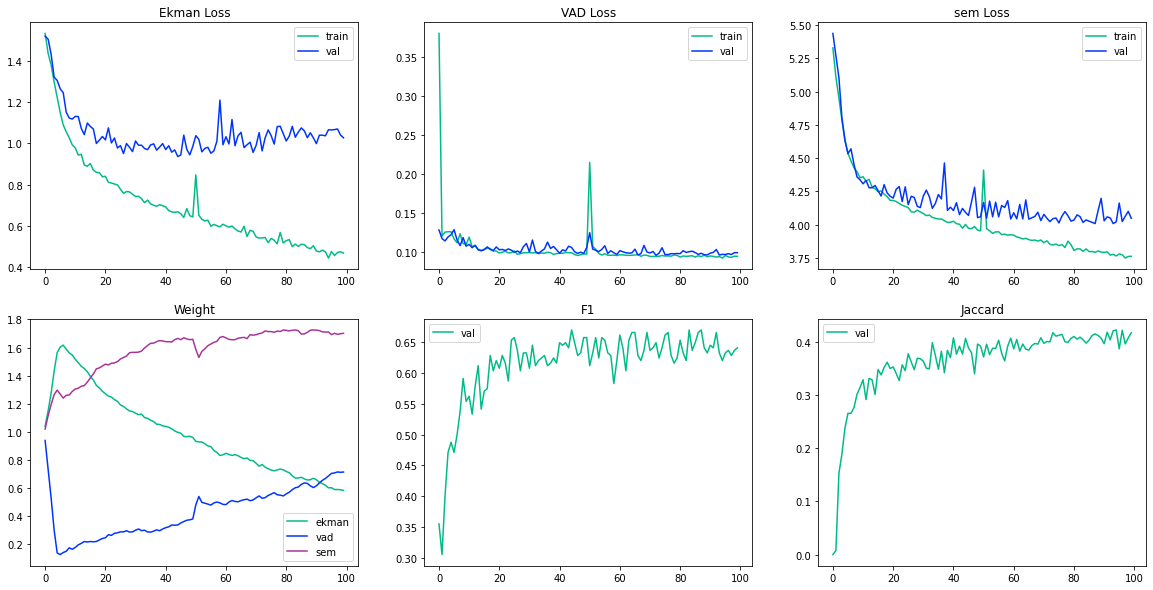

In [ ]:
exp9.plot_history()

### w/o gradNorm

In [ ]:
config = {
    "dataset": "combined",
    "val_dataset": "combined",
    "gradNorm": False,
    "alpha": 2,
    "dropout": 0.5,
    'h_size': 256,
    'weight_decay': 1e-5,
    'lr': 5e-4,
}

exp10 = TrainingManager(dataloaders, config, wandb=False)

In [ ]:
exp10.evaluate()

TEST SET (combined)
Total Loss = 4.597
Ekman Loss = 0.466
VAD Loss = 0.093
sem Loss = 4.038
F1 = 0.8444
MSE = 0.0087
Jaccard = 0.4354
-----------------------
EVALUATING WITH BEST NET
TEST SET (combined)
Total Loss = 4.595
Ekman Loss = 0.533
VAD Loss = 0.095
sem Loss = 3.967
F1 = 0.8157
MSE = 0.0090
Jaccard = 0.4408


In [ ]:
exp10.train(epochs=50)

  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 1: train ekman_loss = 0.876, vad loss = 0.221, sem loss = 4.429
Epoch 1: val ekman loss = 1.081, vad loss = 0.136, sem loss = 4.216
Epoch 1: f1 = 0.599, jaccard = 0.381


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 2: train ekman_loss = 0.660, vad loss = 0.107, sem loss = 3.999
Epoch 2: val ekman loss = 0.946, vad loss = 0.105, sem loss = 4.091
Epoch 2: f1 = 0.665, jaccard = 0.390


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 3: train ekman_loss = 0.636, vad loss = 0.095, sem loss = 3.981
Epoch 3: val ekman loss = 1.074, vad loss = 0.098, sem loss = 4.218
Epoch 3: f1 = 0.612, jaccard = 0.363


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 4: train ekman_loss = 0.622, vad loss = 0.096, sem loss = 3.982
Epoch 4: val ekman loss = 0.964, vad loss = 0.097, sem loss = 4.052
Epoch 4: f1 = 0.657, jaccard = 0.392


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 5: train ekman_loss = 0.637, vad loss = 0.095, sem loss = 3.996
Epoch 5: val ekman loss = 1.020, vad loss = 0.103, sem loss = 4.115
Epoch 5: f1 = 0.628, jaccard = 0.377


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 6: train ekman_loss = 0.645, vad loss = 0.095, sem loss = 3.999
Epoch 6: val ekman loss = 0.983, vad loss = 0.095, sem loss = 4.168
Epoch 6: f1 = 0.674, jaccard = 0.355


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 7: train ekman_loss = 0.609, vad loss = 0.094, sem loss = 3.979
Epoch 7: val ekman loss = 0.998, vad loss = 0.099, sem loss = 4.090
Epoch 7: f1 = 0.632, jaccard = 0.395


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 8: train ekman_loss = 0.640, vad loss = 0.096, sem loss = 3.988
Epoch 8: val ekman loss = 0.961, vad loss = 0.109, sem loss = 4.082
Epoch 8: f1 = 0.661, jaccard = 0.371


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 9: train ekman_loss = 0.608, vad loss = 0.094, sem loss = 3.951
Epoch 9: val ekman loss = 1.035, vad loss = 0.099, sem loss = 4.119
Epoch 9: f1 = 0.645, jaccard = 0.373


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 10: train ekman_loss = 0.628, vad loss = 0.094, sem loss = 3.964
Epoch 10: val ekman loss = 0.988, vad loss = 0.096, sem loss = 4.232
Epoch 10: f1 = 0.669, jaccard = 0.385


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 11: train ekman_loss = 0.603, vad loss = 0.094, sem loss = 3.971
Epoch 11: val ekman loss = 0.971, vad loss = 0.098, sem loss = 4.078
Epoch 11: f1 = 0.657, jaccard = 0.366


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 12: train ekman_loss = 0.595, vad loss = 0.092, sem loss = 3.958
Epoch 12: val ekman loss = 1.026, vad loss = 0.098, sem loss = 4.056
Epoch 12: f1 = 0.636, jaccard = 0.387


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 13: train ekman_loss = 0.573, vad loss = 0.092, sem loss = 3.941
Epoch 13: val ekman loss = 1.046, vad loss = 0.101, sem loss = 4.160
Epoch 13: f1 = 0.632, jaccard = 0.366


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 14: train ekman_loss = 0.607, vad loss = 0.093, sem loss = 3.961
Epoch 14: val ekman loss = 1.025, vad loss = 0.097, sem loss = 4.133
Epoch 14: f1 = 0.603, jaccard = 0.388


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 15: train ekman_loss = 0.577, vad loss = 0.093, sem loss = 3.954
Epoch 15: val ekman loss = 0.986, vad loss = 0.095, sem loss = 4.063
Epoch 15: f1 = 0.661, jaccard = 0.391


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 16: train ekman_loss = 0.584, vad loss = 0.093, sem loss = 3.953
Epoch 16: val ekman loss = 1.043, vad loss = 0.115, sem loss = 4.078
Epoch 16: f1 = 0.636, jaccard = 0.399


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 17: train ekman_loss = 0.595, vad loss = 0.095, sem loss = 3.974
Epoch 17: val ekman loss = 1.054, vad loss = 0.098, sem loss = 4.095
Epoch 17: f1 = 0.620, jaccard = 0.390


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 18: train ekman_loss = 0.574, vad loss = 0.096, sem loss = 3.953
Epoch 18: val ekman loss = 1.026, vad loss = 0.097, sem loss = 4.033
Epoch 18: f1 = 0.645, jaccard = 0.406


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 19: train ekman_loss = 0.569, vad loss = 0.091, sem loss = 3.938
Epoch 19: val ekman loss = 1.050, vad loss = 0.093, sem loss = 4.101
Epoch 19: f1 = 0.628, jaccard = 0.369


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 20: train ekman_loss = 0.552, vad loss = 0.093, sem loss = 3.934
Epoch 20: val ekman loss = 1.074, vad loss = 0.097, sem loss = 4.070
Epoch 20: f1 = 0.603, jaccard = 0.394


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 21: train ekman_loss = 0.549, vad loss = 0.093, sem loss = 3.918
Epoch 21: val ekman loss = 1.021, vad loss = 0.096, sem loss = 4.026
Epoch 21: f1 = 0.665, jaccard = 0.411


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 22: train ekman_loss = 0.573, vad loss = 0.093, sem loss = 3.934
Epoch 22: val ekman loss = 0.992, vad loss = 0.097, sem loss = 4.058
Epoch 22: f1 = 0.649, jaccard = 0.395


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 23: train ekman_loss = 0.555, vad loss = 0.093, sem loss = 3.923
Epoch 23: val ekman loss = 1.096, vad loss = 0.116, sem loss = 4.213
Epoch 23: f1 = 0.645, jaccard = 0.361


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 24: train ekman_loss = 0.564, vad loss = 0.094, sem loss = 3.915
Epoch 24: val ekman loss = 1.051, vad loss = 0.098, sem loss = 4.147
Epoch 24: f1 = 0.628, jaccard = 0.371


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 25: train ekman_loss = 0.529, vad loss = 0.094, sem loss = 3.916
Epoch 25: val ekman loss = 1.101, vad loss = 0.097, sem loss = 4.071
Epoch 25: f1 = 0.636, jaccard = 0.400


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 26: train ekman_loss = 0.545, vad loss = 0.092, sem loss = 3.908
Epoch 26: val ekman loss = 1.055, vad loss = 0.096, sem loss = 4.073
Epoch 26: f1 = 0.636, jaccard = 0.390


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 27: train ekman_loss = 0.547, vad loss = 0.092, sem loss = 3.907
Epoch 27: val ekman loss = 1.028, vad loss = 0.100, sem loss = 4.043
Epoch 27: f1 = 0.682, jaccard = 0.381


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 28: train ekman_loss = 0.550, vad loss = 0.092, sem loss = 3.914
Epoch 28: val ekman loss = 1.130, vad loss = 0.097, sem loss = 4.276
Epoch 28: f1 = 0.653, jaccard = 0.369


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 29: train ekman_loss = 0.533, vad loss = 0.093, sem loss = 3.916
Epoch 29: val ekman loss = 0.992, vad loss = 0.095, sem loss = 4.040
Epoch 29: f1 = 0.653, jaccard = 0.401


  0%|          | 0/245 [00:00<?, ?it/s]

updating best net
Epoch 30: train ekman_loss = 0.519, vad loss = 0.091, sem loss = 3.883
Epoch 30: val ekman loss = 0.998, vad loss = 0.099, sem loss = 4.014
Epoch 30: f1 = 0.674, jaccard = 0.403


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 31: train ekman_loss = 0.549, vad loss = 0.093, sem loss = 3.908
Epoch 31: val ekman loss = 1.069, vad loss = 0.098, sem loss = 4.104
Epoch 31: f1 = 0.640, jaccard = 0.417


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 32: train ekman_loss = 0.523, vad loss = 0.093, sem loss = 3.896
Epoch 32: val ekman loss = 1.023, vad loss = 0.097, sem loss = 4.051
Epoch 32: f1 = 0.645, jaccard = 0.420


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 33: train ekman_loss = 0.508, vad loss = 0.094, sem loss = 3.888
Epoch 33: val ekman loss = 1.062, vad loss = 0.095, sem loss = 4.086
Epoch 33: f1 = 0.632, jaccard = 0.405


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 34: train ekman_loss = 0.531, vad loss = 0.092, sem loss = 3.889
Epoch 34: val ekman loss = 1.113, vad loss = 0.094, sem loss = 4.060
Epoch 34: f1 = 0.620, jaccard = 0.394


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 35: train ekman_loss = 0.501, vad loss = 0.092, sem loss = 3.887
Epoch 35: val ekman loss = 1.124, vad loss = 0.110, sem loss = 4.054
Epoch 35: f1 = 0.607, jaccard = 0.404


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 36: train ekman_loss = 0.530, vad loss = 0.093, sem loss = 3.880
Epoch 36: val ekman loss = 1.183, vad loss = 0.095, sem loss = 4.149
Epoch 36: f1 = 0.624, jaccard = 0.391


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 37: train ekman_loss = 0.509, vad loss = 0.093, sem loss = 3.881
Epoch 37: val ekman loss = 1.143, vad loss = 0.093, sem loss = 4.066
Epoch 37: f1 = 0.640, jaccard = 0.416


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 38: train ekman_loss = 0.512, vad loss = 0.095, sem loss = 3.887
Epoch 38: val ekman loss = 1.148, vad loss = 0.098, sem loss = 4.081
Epoch 38: f1 = 0.603, jaccard = 0.403


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 39: train ekman_loss = 0.511, vad loss = 0.092, sem loss = 3.876
Epoch 39: val ekman loss = 1.105, vad loss = 0.099, sem loss = 4.023
Epoch 39: f1 = 0.607, jaccard = 0.383


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 40: train ekman_loss = 0.478, vad loss = 0.091, sem loss = 3.880
Epoch 40: val ekman loss = 1.069, vad loss = 0.097, sem loss = 4.102
Epoch 40: f1 = 0.624, jaccard = 0.388


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 41: train ekman_loss = 0.465, vad loss = 0.091, sem loss = 3.871
Epoch 41: val ekman loss = 1.061, vad loss = 0.097, sem loss = 4.041
Epoch 41: f1 = 0.624, jaccard = 0.407


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 42: train ekman_loss = 0.490, vad loss = 0.094, sem loss = 3.862
Epoch 42: val ekman loss = 1.091, vad loss = 0.095, sem loss = 4.055
Epoch 42: f1 = 0.628, jaccard = 0.412


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 43: train ekman_loss = 0.466, vad loss = 0.092, sem loss = 3.851
Epoch 43: val ekman loss = 1.107, vad loss = 0.094, sem loss = 4.121
Epoch 43: f1 = 0.636, jaccard = 0.368


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 44: train ekman_loss = 0.492, vad loss = 0.094, sem loss = 3.881
Epoch 44: val ekman loss = 1.124, vad loss = 0.096, sem loss = 4.044
Epoch 44: f1 = 0.616, jaccard = 0.396


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 45: train ekman_loss = 0.460, vad loss = 0.091, sem loss = 3.834
Epoch 45: val ekman loss = 1.117, vad loss = 0.093, sem loss = 4.028
Epoch 45: f1 = 0.599, jaccard = 0.397


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 46: train ekman_loss = 0.456, vad loss = 0.093, sem loss = 3.849
Epoch 46: val ekman loss = 1.161, vad loss = 0.096, sem loss = 4.097
Epoch 46: f1 = 0.661, jaccard = 0.396


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 47: train ekman_loss = 0.453, vad loss = 0.092, sem loss = 3.845
Epoch 47: val ekman loss = 1.195, vad loss = 0.095, sem loss = 4.066
Epoch 47: f1 = 0.657, jaccard = 0.391


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 48: train ekman_loss = 0.445, vad loss = 0.091, sem loss = 3.837
Epoch 48: val ekman loss = 1.119, vad loss = 0.094, sem loss = 4.024
Epoch 48: f1 = 0.620, jaccard = 0.408


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 49: train ekman_loss = 0.427, vad loss = 0.091, sem loss = 3.848
Epoch 49: val ekman loss = 1.140, vad loss = 0.096, sem loss = 4.064
Epoch 49: f1 = 0.624, jaccard = 0.400


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch 50: train ekman_loss = 0.442, vad loss = 0.092, sem loss = 3.845
Epoch 50: val ekman loss = 1.111, vad loss = 0.098, sem loss = 4.090
Epoch 50: f1 = 0.661, jaccard = 0.391


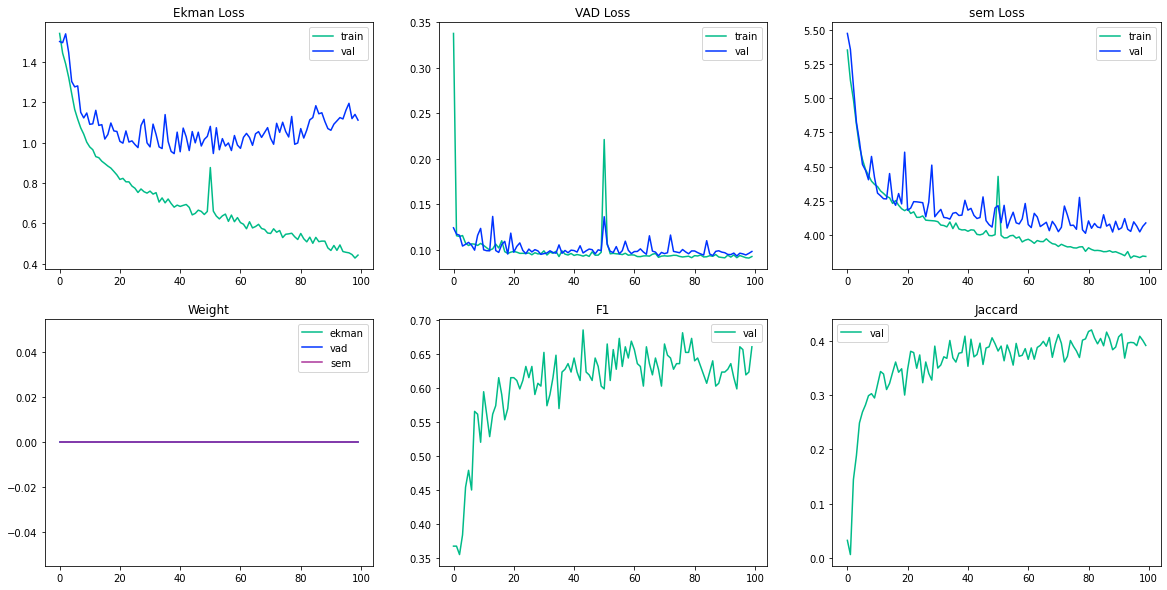

In [ ]:
exp10.plot_history()